The `Grizli` pipeline allows you to fully reduce a given set of HST grism observations with essentially two steps:

* Run an archive query with [`hsaquery`](https://github.com/gbrammer/esa-hsaquery)

* Process the associations found with the query with `grizli.auto_script.go`.

Here, "association" usually simply means "any Hubble exposures that overlap" and doesn't require that all observations were taken with the same observing program, instrument, grism position angle, epoch, filter, etc.  The code does all of the exposure-level book-keeping and the products are drizzled image mosaics, extracted 1D and 2D grism spectra and fits to the spectra.

**NB**: The pipeline works fine with just imaging and no grism exposures!

In [7]:
#cell 1
%matplotlib inline

In [8]:
#cell 2
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli.pipeline import auto_script 
from grizli import utils
from grizli import fitting
from grizli import multifit #original line, replaced by cell above 

utils.set_warnings()
print('\n Grizli version: ', grizli.__version__)


 Grizli version:  0.8.0-45-g977ade9


In [9]:
#cell 3
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


## Query the HST archive ##

The `hsaquery` module can be used to programaticaly query the HST archive and find exposures from different programs (and instruments) that overlap on the sky.  The example below is tailored for a single pointing from a single program, but the query parameters can be expanded to search much more broadly for archival data.

In [10]:
#cell 4
### Generate a query for the WFC3/ERS grism data

## !! new query tools since ESA database changed in summer 2018
# https://github.com/gbrammer/mastquery
from mastquery import query, overlaps

# "parent" query is grism exposures in GO-11359.  Can also query the archive on position with
# box=[ra, dec, radius_in_arcmin]
parent = query.run_query(box=None, proposal_id=[12945], instruments=['WFC3/IR', 'ACS/WFC'], 
                         filters=['G102','G141'])

# ### "overlap" query finds anything that overlaps with the exposures 
# ### in the parent query
# extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

# ## To match *just* the grism visits, add, e.g., the following:
# extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['F105W', 'F814W','G102'], 
                              proposal_id=[12945], instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC']) 
                              #,extra={'target_name':'CL1059-12.0'}, close=False)

get_correct_exptime: read failed
Iter #1, N_Patch = 14


 0 j105908m1246 164.779 -12.773
get_correct_exptime: read failed
target_name
-----------
CL1059-12.0 

filter j105908m1246         WFC3/IR F105W    1      -1.0
filter j105908m1246          WFC3/IR G102    1      -1.0


 1 j105900m1253 164.747 -12.878
get_correct_exptime: read failed
target_name
-----------
        ANY
CL1059-12.1 

filter j105900m1253         ACS/WFC F814W    1      -1.0
filter j105900m1253         WFC3/IR F105W    1      -1.0
filter j105900m1253          WFC3/IR G102    1      -1.0


 2 j105912m1254 164.794 -12.903
get_correct_exptime: read failed
target_name
-----------
CL1059-12.2 

filter j105912m1254         WFC3/IR F105W    1      -1.0
filter j105912m1254          WFC3/IR G102    1      -1.0


 3 j105836m1254 164.644 -12.893
get_correct_exptime: read failed
target_name
-----------
CL1059-12.3 

filter j105836m1254         WFC3/IR F105W    1      -1.0
filter j105836m1254          WFC3/IR G102    1      -1.0


In [11]:
#cell 5
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  []

# id            ra         dec        e(b-v)   filters
j105908m1246  164.77900  -12.77300   0.0281   F105W,G102
j105900m1253  164.74700  -12.87800   0.0273   F105W,F814W,G102
j105912m1254  164.79400  -12.90300   0.0270   F105W,G102
j105836m1254  164.64400  -12.89300   0.0291   F105W,G102
j113812m1134  174.55400  -11.57300   0.0172   F105W,G102
j113848m1134  174.70000  -11.57500   0.0174   F105W,G102
j113736m1125  174.39300  -11.42300   0.0217   F105W,G102
j122756m1136  186.98400  -11.60300   0.0409   F105W,F814W,G102
j122752m1140  186.96700  -11.66100   0.0398   F105W,G102
j122816m1132  187.07100  -11.52800   0.0433   F105W,G102
j130132m1138  195.37900  -11.62600   0.0411   F105W,F814W,G102
j130120m1133  195.34100  -11.54500   0.0415   F105W,G102
j130132m1142  195.38900  -11.69800   0.0407   F105W,F814W,G102
j130100m1131  195.24700  -11.52100   0.0405   F105W,G102


In [12]:
#cell 6
#os.chdir('/Users/brammer/3DHST/Spectra/Work/Grizli/Demo-18.05.22/')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Pipeline processing - #

** In principle, all of the steps outlined below can be executed with a single call to** `auto_script.go`, from fetching the data to extracting spectra and performing the redshift / line fits.  The processing steps been broken out individually here to show the processing at each step.

** The same pipeline can be used to process imaging-only fields.**  Simply run the queries as above to find the imaging exposures you want to processes and run everything the same way.  The pipeline steps related to the grism exposures will simply be skipped.

In [14]:
#cell 7
# Do everything for the query from fetching the data to generating the contamination model
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)

"CHANGE FILE DIRECTORY HERE"
root = 'j113812m1134'
IS_PARALLEL = False # Set to True for parallel programs like WISPS

if False:
    # This line would do everything below
    auto_script.go(root=root, maglim=[19,21], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync='cp', gaia_by_date=True, is_parallel_field=IS_PARALLEL, 
                   run_fit=False, only_preprocess=True, run_extractions=False)

HOME_PATH =  /data2/jrcooper/notebooks/reduction/EDisCS


# - Individual steps - #

## Fetch data from the HST archive ##
`Grizli` can automatically fetch HST data from the ESA Hubble Science archive (and, optionally, the Amazon S3 bucket).  The `fetch_files` script fetches the exposures listed in the archive query above.  It also fetches associated WFC3/IR persistence products from the persistence database.

The first time you run the script, a lot more information will be printed to the screen as the exposures are retrieved and the script runs the reprocessing code to flatten the IR backgrounds.  Below the "skip" message simply indicate that files have already been downloaded.

In [15]:
#cell 8 THIS TAKES A LONG TIME
### Fetch data, reprocess WFC3/IR for backgrounds, fetch WFC3/IR persistence productss

# If s3_sync, then sync from the Hubble Amazon S3 bucket with awscli, 
# otherwise get from the ESA archive.
os.chdir(HOME_PATH)

import grizli.pipeline
from grizli.pipeline import auto_script
# Is awscli available and connected? 
s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
if s3_status == 0:
    s3_sync='cp'  # As of late October 2018, 's3 sync' not working with 'stpubdata'
else:
    s3_sync=False # Fetch from ESA archive
    
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True, 
                        reprocess_parallel=True, s3_sync=s3_sync)

Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$uc72113oi_pfl.fits
/home/jrcooper/grizli/iref/uc72113oi_pfl.fits exists
Calib: NPOLFILE=N/A
Calib: IDCTAB=iref$w3m18525i_idc.fits
/home/jrcooper/grizli/iref/w3m18525i_idc.fits exists
Calib: PFLTFILE=iref$u4m1335li_pfl.fits
/home/jrcooper/grizli/iref/u4m1335li_pfl.fits exists


## Parse visit associations ##
`Grizli` builds its own associations based on anything it finds in the `RAW` directory.  Visits are usually defined in the exposure filenames.  For example, for the single exposure, `ib6o03ntq_flt.fits`, the characters `b6o` identify the observing program and the visit identifier  is `03`.  You can also build visits combining all exposures in a given filter taken at the same position angle, which can be useful for some programs executed in parallel where exposures taken at a similar time could have different visit IDs in the filename.  

**NB:** Generally one should process "visits" as groups of exposures in a given filter that were taken with a single guide star acquisition.  

The parsing script also associates grism exposures with corresponding direct images, based on the visit, exposure order and exposure footprints on the sky.

In [16]:
#cell 11
# Demo combining by PA / filter.  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1138-11.0-c1b-05-122.0-F105W 4
CL1138-11.0-c1b-05-122.0-G102 4

 == Grism groups ==

ic1b-122.0-f105w 4 ic1b-122.0-g102 4


ic1b-122.0-f105w                4
ic1b-122.0-g102                 4


In [17]:
#cell 12
######################
### Parse visit associations for most normal programs
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=IS_PARALLEL)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

CL1138-11.0-c1b-05-122.0-F105W 4
CL1138-11.0-c1b-05-122.0-G102 4

 == Grism groups ==

cl1138-11.0-c1b-05-122.0-f105w 4 cl1138-11.0-c1b-05-122.0-g102 4


cl1138-11.0-c1b-05-122.0-f105w  4
cl1138-11.0-c1b-05-122.0-g102   4


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `./RAW` to `./Prep/`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The script also runs on *imaging-only* visits, performing the background subtraction and astrometric alignment but skipping anything related to grism processing.

The `auto_script.preprocess` command below runs the processing script for the two direct/grism pairs of the ERS observations and for the overlapping imaging visits identified in the initial query.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes a few minutes to run per visit.  It only needs to be run once.

**NB** If you restart the pipeline after a previous run, it will skip preprocessing any visit where the file `{visit-product}_dr?_sci.fits` is found (i.e., the "Skip" messages below).  If you want to force reprocessing of a visit, delete that file.

In [18]:
#####################
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['NSC', 'PS1','SDSS','GAIA','WISE'] 
# As of v0.8.0-8, can use the NOAO source catalog (NSC) here, which 
# is defined over much of the sky and appears to be well aligned to GAIA.  
# However, sometimes it's not clear how to apply the best quality control 
# to the NSC sources.  Here, for example, there seem to be a number of spurious 
# NSC sources that make the initial alignment RMS fairly high. 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)

0 cl1138-11.0-c1b-05-122.0-f105w 4 cl1138-11.0-c1b-05-122.0-g102 4
Skip cl1138-11.0-c1b-05-122.0-f105w
Skip cl1138-11.0-c1b-05-122.0-f105w
Skip cl1138-11.0-c1b-05-122.0-g102
utils.fix_flt_nan: ic1b05tyq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b05u5q_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b05ujq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b05tvq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b05ucq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b05uhq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b05uaq_flt.fits[SCI,1] NaNPixels=0
utils.fix_flt_nan: ic1b05u3q_flt.fits[SCI,1] NaNPixels=0


In [19]:
!ls wfc3*sci.fits # individual drizzled visits

ls: cannot access wfc3*sci.fits: No such file or directory


In [20]:
# Results of the intra-visit alignment.  
# Should be small as these are just FGS drift on a single guide star
!ls *shifts.log
print('')
!cat *shifts.log

cl1138-11.0-c1b-05-122.0-f105w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['ic1b05tvq_flt.fits'] = ['ic1b05tyq_flt.fits']
# match['ic1b05u3q_flt.fits'] = ['ic1b05u5q_flt.fits']
# match['ic1b05uaq_flt.fits'] = ['ic1b05ucq_flt.fits']
# match['ic1b05uhq_flt.fits'] = ['ic1b05ujq_flt.fits']
ic1b05tvq_flt.fits   0.000   0.000  0.00000  1.00000    50  0.000  0.000
ic1b05u3q_flt.fits   0.030  -0.015  0.00000  1.00000    44  0.055  0.033
ic1b05uaq_flt.fits   0.115  -0.006  0.00000  1.00000    43  0.055  0.028
ic1b05uhq_flt.fits   0.038  -0.032  0.00000  1.00000    42  0.023  0.035


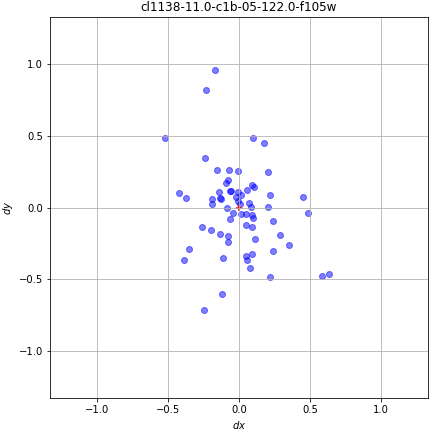

In [21]:
# Show the alignment w.r.t the external NOAO Source Catalog (NSC)
Image(filename = "./cl1138-11.0-c1b-05-122.0-f105w_wcs.png") 


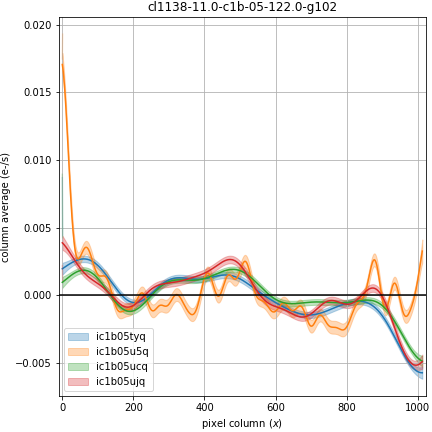

In [22]:
# Show the alignment of one HST visit to another, note tight 
# plot range compared to previous
Image(filename = "./cl1138-11.0-c1b-05-122.0-g102_column.png") 

In [23]:
# Check wcs.log files that a few objects were found, no large rotations
# and rms (second to last column) isn't too large

# Here, the F098M/G102 visit was the first processed and was aligned 
# to the NSC, with RMS~0.8 WFC3/IR pix.  Subsequent visits are aligned to 
# previously processed HST visits so that at least the relative HST astrometry
# is as good as possible.  Here, the F140W/G141 visit was run second and was 
# therefore aligned to F098M, resulting in much better precision than with the
# external catalog (RMS < 0.1 pix).

# Cat wcs.log files in order they were generated
!grep " 0 " `ls -ltr *wcs.log | awk '{print $9}'` | sed "s/  */ /g"

# columns: 
# "visit"  0  xshift yshift rot scale rms N

 0 -0.6311 -0.0627 0.0032 1.00001 0.190 66


### Alignment failures ###

The main failure mode of the `auto_script.preprocess` script is failure to compute a reliable alignment to the external reference.  This can happen, e.g., if there are not enough alignment sources (i.e., zero) within the field of view or if the original astrometry of the exposures obtained from the archive is offset from the reference by more than ~10 pixels.  This can almost always be remedied by running `grizli.pipeline.auto_script.manual_alignment` after the files have been fetched, which prompts the user to interactively mark sources in the image and reference catalog using DS9.

In [24]:
if False: # Don't run
    catalogs = ['PS1','SDSS','GAIA','WISE']
    auto_script.manual_alignment(field_root=root, HOME_PATH=HOME_PATH, skip=True, 
                                 catalogs=catalogs, radius=15, visit_list=None)

### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

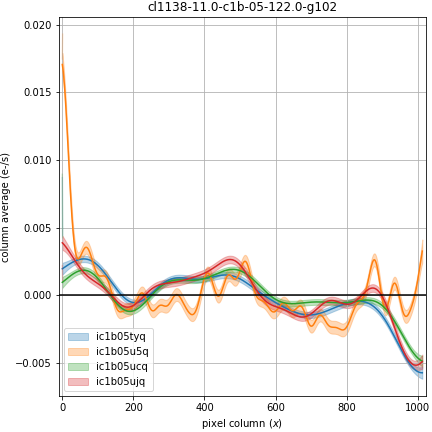

In [25]:
from IPython.display import Image
Image(filename = "./cl1138-11.0-c1b-05-122.0-g102_column.png", width=600, height=600)

### Fine alignment to GAIA DR2 ###

The initial visit alignment scripts often show small drifts such that the differen't visits don't perfectly overlap.  The script below performs an additional realignment to the visits internally and also to an external reference, usually GAIA DR2.

In [26]:
# Fine alignment of the visits relative to each other and absolute to GAIA DR2
if len(glob.glob('{0}*fine.png'.format(root))) == 0:
    fine_catalogs = ['GAIA','PS1','SDSS','WISE']
    out = auto_script.fine_alignment(field_root=root, HOME_PATH=HOME_PATH, 
                                     min_overlap=0.2, stopme=False, ref_err=0.08, 
                                     catalogs=fine_catalogs, NITER=1, maglim=[17,23],
                                     shift_only=True, method='Powell', redrizzle=False, 
                                     radius=10, program_str=None, match_str=[], 
                                     gaia_by_date=True)

    # Update headers with the result from the fine alignment
    # Original FLTs are archived to FineBkup
    auto_script.update_wcs_headers_with_fine(root)
    
visits, res = np.load('{0}_fine.npy'.format(root))
shifts = res.x.reshape((-1,2))/10.
for i, visit in enumerate(visits):
    print('{0:35}  {1:6.2f}  {2:6.2f}'.format(visit['product'], shifts[i,0], shifts[i,1]))

cl1138-11.0-c1b-05-122.0-f105w         0.04    0.01


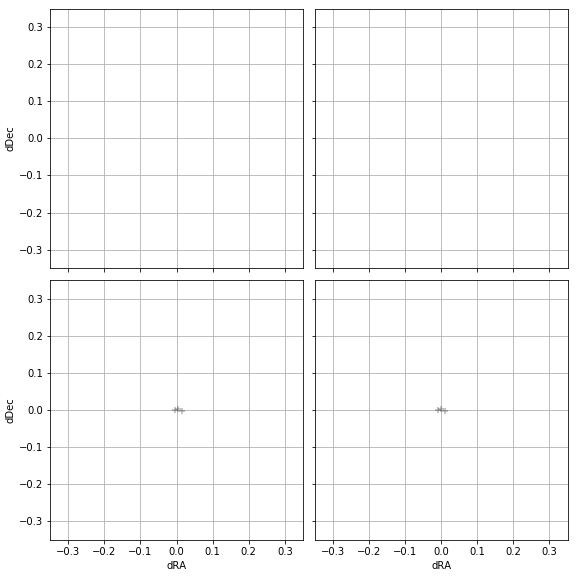

In [27]:
# Show the results of fine alignment.  
# Top panels are alignment between the visits.  + in the bottom panels are 
# residuals of the external reference, here GAIA DR2.
#
# Small drift between individual visits removed.  
# Fairly large GAIA offsets probably due to ~6 years between 
# WFC3/ERS and GAIA epoch 2015.5.
Image(filename='{0}_fine.png'.format(root))

## Make combined mosaics for each available filter ##

These are used to generate a photometric catalog and also for the direct image reference for the grism

In [28]:
# Drizzle mosaics in each filter and combine all IR filters
combine_all_filters=True
if len(glob.glob('{0}-ir_dr?_sci.fits'.format(root))) == 0:

    ## Mosaic WCS
    wcs_ref_file = '{0}_wcs-ref.fits'.format(root)
    if not os.path.exists(wcs_ref_file):
        auto_script.make_reference_wcs(info, output=wcs_ref_file, 
                           filters=['G800L', 'G102', 'G141'], 
                           pad_reference=90, pixel_scale=None,
                           get_hdu=True)

    # All combined
    IR_filters = ['F105W', 'F110W', 'F125W', 'F140W', 'F160W', 
                  'F098M', 'F139M', 'F127M', 'F153M']

    optical_filters = ['F814W', 'F606W', 'F435W', 'F850LP', 'F702W', 'F555W', 'F438W', 'F475W', 'F625W', 'F775W', 'F225W', 'F275W', 'F300W', 'F390W']

    if combine_all_filters:
        auto_script.drizzle_overlaps(root, 
                                 filters=IR_filters+optical_filters, 
                                 min_nexp=1, 
                                 make_combined=True,
                                 ref_image=wcs_ref_file,
                                 drizzle_filters=False) 

    ## IR filters
    auto_script.drizzle_overlaps(root, filters=IR_filters, 
                                 min_nexp=1, 
                                 make_combined=(not combine_all_filters),
                                 ref_image=wcs_ref_file) 

    # Fill IR filter mosaics with scaled combined data so they can be used 
    # as grism reference
    auto_script.fill_filter_mosaics(root)

    ## Optical filters

    mosaics = glob.glob('{0}-ir_dr?_sci.fits'.format(root))

    auto_script.drizzle_overlaps(root, filters=optical_filters,
        make_combined=(len(mosaics) == 0), ref_image=wcs_ref_file,
        min_nexp=2) 

In [29]:
!ls -1 j*_dr?_sci.fits

j113812m1134-f105w_drz_sci.fits
j113812m1134-ir_drz_sci.fits


## Generate a photometric catalog ##

Run source detection on the combined mosaic `{root}-ir_dr[cz]_sci.fits` and generates a catalog and segmentation image.  

Then perform simple matched-aperture photometry on the different available filter mosaics (in this case F098M and F140W from the direct imaging).  In principle the template fitting code shown below can incorporate this photometric information, though that's not currently done by default.

In [30]:
## Run SEP (~SExtractor clone) catalog on the "ir" combined image
## and generate a photometric catalog with aperture photometry in all available bands
if not os.path.exists('{0}_phot.fits'.format(root)):
    get_background=False # SExtractor background subtraction
    tab = auto_script.multiband_catalog(field_root=root, threshold=1.8,
                                        detection_background=get_background,
                                        photometry_background=get_background) 
    
files = glob.glob('{0}-ir*'.format(root)) + glob.glob('*phot*fits')
for file in files:
    print(file)
    
phot = utils.GTable.gread('{0}_phot.fits'.format(root))
print('{0}Metadata{0}'.format('\n'+'='*20+'\n'))
for k in phot.meta:
    print('{0}:\t{1}'.format(k, phot.meta[k]))

j113812m1134-ir_drz_sci.fits
j113812m1134-ir_bkg.fits
j113812m1134-ir_seg.fits
j113812m1134-ir.cat.fits
j113812m1134-ir_drz_wht.fits
j113812m1134_phot.fits

Metadata

MINAREA:	5
CLEAN:	True
DEBCONT:	0.005
DEBTHRSH:	32
FILTER_TYPE:	conv
THRESHOLD:	1.8
ZP:	26.26887001774306
PLAM:	10551.047
FNU:	1.1283712e-07
FLAM:	3.0386574e-20
UJY2DN:	8.861796202091552
DRZ_FILE:	j113812m1134-ir_drz_sci.fits
WHT_FILE:	j113812m1134-ir_drz_wht.fits
GET_BACK:	False
ERR_SCALE:	0.5137168169021606
APER_0:	6.00000000000013
ASEC_0:	0.36
APER_1:	8.33500000000018
ASEC_1:	0.5001
APER_2:	16.33700000000036
ASEC_2:	0.9802200000000001
APER_3:	20.00000000000043
ASEC_3:	1.2
F105W_ZP:	26.26887001774306
F105W_PLAM:	10551.047
F105W_FNU:	1.1283712e-07
F105W_FLAM:	3.0386574e-20
F105W_uJy2dn:	8.861796202091552
F105W_DRZ_FILE:	j113812m1134-f105w_drz_sci.fits
F105W_WHT_FILE:	j113812m1134-f105w_drz_wht.fits
F105W_GET_BACK:	False
F105W_ERR_SCALE:	0.5137168169021606
F105W_aper_0:	6.00000000000013
F105W_asec_0:	0.36
F105W_aper_1:	8.

In [31]:
phot[:2].show_in_notebook()

## Building the grism exposure container: `multifit.GroupFLT` ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

The `grism_prep` script iterates on the refined polynomial model `refine_niter` times.

### Save state ###

You can optionally dump saved data (i.e., `grp.save_full_data()`) for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.  The `grism_prep` script does this automatically.

In [32]:
files = glob.glob('*GrismFLT.fits')
if len(files) == 0:
    ### Grism contamination model
    os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

    # Which filter to use as direct image?  Will try in order of the list until a match is found.
    gris_ref = {'G141': ['F140W', 'F160W'], 
                'G102': ['F105W', 'F098M', 'F110W']}

    x = auto_script.grism_prep(field_root=root, refine_niter=3,
                                 gris_ref_filters=gris_ref)

    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)
    
else:
    grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                            catalog='{0}-ir.cat.fits'.format(root), 
                            cpu_count=-1, sci_extn=1, pad=256)

Load ic1b05ujq.01.GrismFLT.fits!
Load ic1b05tyq.01.GrismFLT.fits!
Load ic1b05ucq.01.GrismFLT.fits!
Load ic1b05u5q.01.GrismFLT.fits!
Files loaded - 4.05 sec.


### The final contamination model ###

IndexError: list index out of range

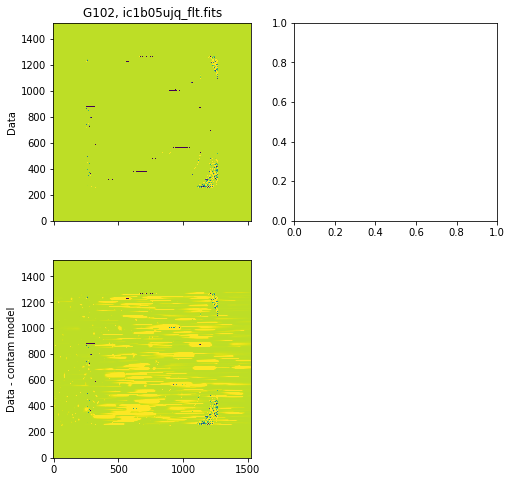

In [33]:
# Show the results of the contamination model
### Show FLT residuals
cmap = 'viridis_r'
vm = [-0.01, 0.1]

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(221)
flt = grp.FLTs[0] # G102

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([])
ax.set_ylabel('Data')

ax = fig.add_subplot(223)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_ylabel('Data - contam model')

ax = fig.add_subplot(222)
flt = grp.FLTs[4] # G141

ax.imshow(flt.grism['SCI'], vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')
ax.set_title('{0}, {1}'.format(flt.grism.filter, flt.grism.parent_file))
ax.set_xticklabels([]); ax.set_yticklabels([])

ax = fig.add_subplot(224)
ax.imshow(flt.grism['SCI'] - flt.model, vmin=vm[0], vmax=vm[1], cmap=cmap,
          interpolation='Nearest', origin='lower')

ax.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(510,790); ax.set_ylim(610,890)

fig.tight_layout(pad=1)

### Parameters for object fitting
### Read in LDP and match

In [35]:
## USE THIS ONE
h = open('/data2/jrcooper/notebooks/reduction/EDisCS/j113812m1134/Extractions/b_LDP_q.txt', 'r')
lines = h.readlines()[1:]
h.close()   
z_LDP       = []  
id_HST      = []   
ra_HST      = []
dec_HST     = [] 

for line in lines: 
    a = line.split()     
    z_LDP.append(float(a[3]))
    ra_HST.append(float(a[1]))
    dec_HST.append(float(a[2]))



z_LDP     = np.array(z_LDP)
ra_HST    = np.array(ra_HST)
dec_HST   = np.array(dec_HST)
id_HST     = np.array(id_HST)   


In [36]:
#### Store fit parameters to `fit_args.npy` for batch-mode processing

# Drizzle parameters for line maps
pline = auto_script.DITHERED_PLINE
#print(pline) 

sig = 0.007 
z = np.arange(0,2,.001)
for i in z_LDP:
    p_z = np.exp(-(z - i)**2/(2*sig**2))/((2*np.pi)**0.5/sig)

spec_prior = [z,p_z]
tuple
a = tuple(spec_prior)

# Generate the parameter dictionary
args = auto_script.generate_fit_params(field_root=root, prior=a, 
                                       MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                                fsps=True, sys_err = 0.03, fcontam=0.2, zr=[0.05, 3.4], 
                                save_file='fit_args.npy')

Saved arguments to fit_args.npy.


### Field PSF file ### 
Make an average effective PSF for each available IR filter by evaluating the field-dependent PSF across the final mosaic and drizzling to a common output.  Also make an extension with a PSF on the pixel grid of the drizzled line map parameters generated above (`pline`).  Each PSF is generated with the native pixel grid and 2/4x oversampling for use with, e.g., [GALFIT](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html).

*NB* There is currently no ePSF for F098M, so F105W is used (http://www.stsci.edu/~jayander/STDPSFs/WFC3IR/).


In [37]:
# Make PSF file
if not os.path.exists('{0}-f105w_psf.fits'.format(root)):
    auto_script.field_psf(root=root, HOME_PATH=HOME_PATH)

['j113812m1134-f105w_psf.fits'] 

Filename: j113812m1134-f105w_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  PSF         LINE1 ImageHDU        29   (60, 60)   float32   
  2  PSF         LINE2 ImageHDU        29   (120, 120)   float32   
  3  PSF         LINE4 ImageHDU        29   (240, 240)   float32   
  4  PSF         DRIZ1 ImageHDU        29   (100, 100)   float32   
  5  PSF         DRIZ2 ImageHDU        29   (200, 200)   float32   
  6  PSF         DRIZ4 ImageHDU        29   (400, 400)   float32   


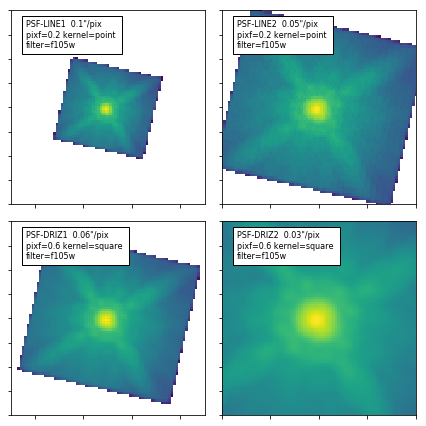

In [38]:
# Show the PSFs
print(glob.glob('*psf.fits'),'\n')

im = pyfits.open('{0}-f105w_psf.fits'.format(root))
im.info()

fig = plt.figure(figsize=[6,6])
for i, ext in enumerate([1,2,4,5]):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(np.log10(im[ext].data))
    
    h = im[ext].header
    label = '{0}-{1}  {2}"/pix \npixf={3} kernel={4} \nfilter={5}'.format(h['EXTNAME'],
                     h['EXTVER'], h['PSCALE'], h['PIXFRAC'], h['KERNEL'], h['FILTER'])
    
    ax.text(0.08, 0.95, label, ha='left', va='top', 
            transform=ax.transAxes, size=8, color='k',
            bbox={'fc':'w'})
    
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    sh = im[ext].data.shape
    ax.set_xlim(sh[1]/2-40, sh[1]/2+40)
    ax.set_ylim(sh[0]/2-40, sh[0]/2+40)
    
fig.tight_layout(pad=1)

## Extract and fit individual spectra ##

In [39]:
os.chdir('../Extractions')

In [40]:
### Find IDs of specific objects to extract
import grizli.pipeline
from grizli.pipeline import auto_script
import astropy.units as u
tab = utils.GTable()
#tab['ra'] = [174.4118633,174.3686397,174.3797582,174.3845889,174.397861,174.412518,174.3670438,174.3742016,174.3804661,174.4072525,174.4070533,174.3933064,174.3931596,174.3691858,174.3688672,174.3690021,174.3688063,174.3672425,174.3665378,174.3921713,174.3933575,174.4087276,174.4123249,174.3767788,174.3748348,174.3787987,174.3708528,174.3812335,174.3814446,174.382614,174.3791532,174.385079,174.3849722,174.3773103,174.3779308,174.3717816,174.3848934,174.3771574,174.3727826,174.3734838,174.3913213,174.3869972,174.3864554,174.3866813,174.3799761,174.3879,174.3961038,174.3945939,174.3946899,174.3980747,174.3941714,174.3810396,174.3811199,174.3759067,174.3738911,174.3804884,174.3793689,174.3769608,174.3739911,174.3941685,174.4011006,174.3778083,174.3928164,174.3804512,174.3851616,174.380016,174.3801094,174.3965471,174.3884755,174.3910637,174.387964,174.3913192,174.3914445,174.3802608,174.3800891,174.3800327,174.390005,174.3766207,174.3861459,174.3751421,174.4029965,174.3937154,174.3938229,174.4006638,174.400634,174.4004205,174.3959245,174.3834155,174.410023,174.4110051,174.3941949,174.4079271,174.3832748,174.3723437,174.3752115,174.3881324,174.40738,174.4075371,174.4038001,174.3776531,174.3985774,174.4051396,174.4012677,174.3806377,174.3716552,174.3846171,174.3850321,174.3871291,174.3974057,174.3707338,174.4001625,174.4103907,174.4104152,174.370494,174.3832325,174.3716295,174.3823567,174.3849623,174.4010585,174.3748725,174.4069045,174.3850529,174.4107016,174.3988903,174.3771158,174.4048342,174.373967,174.4067188,174.4034601,174.4040355,174.4038954,174.3922065,174.3925352,174.4026382,174.3995775,174.3831676,174.3978151,174.394407,174.3943988,174.3804665,174.3799555,174.4073365,174.3810505,174.3989021,174.4118035,174.3862916,174.3950565,174.3815119,174.4114332,174.4089518,174.4086337,174.3783956,174.3835116,174.3833891,174.3772125,174.3767481,174.3763366,174.3686133,174.3846834,174.3765115,174.3710509,174.3811286,174.3810785,174.3878796,174.3714472,174.3696215,174.3837304,174.3799637,174.3975855,174.408378,174.389328,174.4031666,174.3689918,174.3821339,174.3731581,174.3684657,174.3997755,174.3966998,174.4092418,174.3988337,174.4026826,174.399456,174.3943523,174.4099742,174.4053917,174.381934,174.3701956,174.3878967,174.403905,174.411098,174.3935612,174.4090161,174.387054,174.3865922,174.3829451,174.3755649,174.4105957,174.3842971,174.3809018,174.409077,174.408885,174.3994039,174.3691348,174.3796697,174.4095749,174.4049898,174.378185,174.387129,174.4055909,174.4055366,174.4057687,174.4054303,174.4003571,174.3982444,174.4062903,174.4061453,174.3997543,174.3820729,174.3840378,174.3682332,174.3686231,174.3949571,174.3994276,174.3875546,174.3964459,174.4050611,174.394733,174.3806533,174.3815379,174.3955579,174.3894354,174.401443,174.3935624,174.3934467,174.4084085,174.401406,174.3988417,174.3707744,174.4083716,174.4092932,174.4034055,174.3907952,174.3682603,174.3968084,174.395399,174.3981921,174.3752158,174.3711835,174.3986423,174.3842199,174.4028942,174.3918513,174.3917949,174.3996218,174.4063234,174.3943757,174.3907661,174.3867227,174.4020477,174.4020128,174.3996745,174.3861347,174.3837594,174.4056763,174.3677452,174.3945288,174.4021971,174.4080006,174.3782513,174.3986636,174.3678685,174.3740759,174.3721,174.3722116,174.3823471,174.3954012,174.3750514,174.3992077,174.4014894,174.3749131,174.407115,174.3823573,174.3673895,174.3785874,174.3838518,174.400227,174.4071072,174.4071757,174.3945508,174.3776495,174.3726168,174.3786074,174.4013678,174.3726654,174.4058475,174.3865453,174.3724778,174.3747123,174.3748985,174.3801947,174.4056129,174.399787,174.3948029,174.3943262,174.3814047,174.4094231,174.3891988,174.3785227,174.4020965,174.366548,174.4030109,174.4029031,174.3710936,174.3701846,174.399441,174.3849507,174.3997734,174.3855422,174.385701,174.3940045,174.3774031,174.404311,174.3888625,174.368653,174.392602,174.386554,174.3951195,174.3862442,174.3884426,174.3933544,174.4037673,174.3962347,174.3957018,174.3962323,174.3742381,174.3999549,174.3997852,174.3847455,174.3748441,174.3749965,174.3827494,174.36688,174.3972047,174.4012877,174.4033545,174.4032237,174.3922029,174.3793299,174.3700605,174.3941671,174.3776026,174.3996319,174.3814074,174.4024752,174.4025639,174.3715811,174.3735299,174.380875,174.3824583,174.377477,174.3731738,174.373008,174.3702185,174.3953243,174.3863515,174.3702485,174.4002528,174.4029622,174.3655957,174.3892633,174.39352,174.3948536,174.393928,174.377719,174.3672721,174.406376,174.3657231,174.3972316,174.3684152,174.3808368,174.3739879,174.397792,174.399329,174.4060634,174.3955529,174.389342,174.3835584,174.4032463,174.3726363,174.3902532,174.3832384,174.3968654,174.4053413,174.3734288,174.3908544,174.3691144,174.3745796,174.3744327,174.3707195,174.3909923,174.3763947,174.3730874,174.3707268,174.4030591,174.3910123,174.3949013,174.4014471,174.3801271,174.4053426,174.3658806,174.4046002,174.4019161,174.4015301,174.3906148,174.3731218,174.3860184,174.3821069,174.3916208,174.3915034,174.3736736,174.4044422,174.3705266,174.3983853,174.397938,174.3769437,174.3816981,174.3854264,174.3685865,174.3764316,174.3735563,174.4045562,174.4047738,174.3661968,174.3821705,174.4051944,174.383714,174.3684348,174.404838,174.3959258,174.3956777,174.382061,174.3995164,174.3766376,174.4025186,174.3805095,174.3953532,174.3686929,174.3688924,174.3685074,174.3835799,174.4012345,174.3854665,174.366571,174.3984712,174.3736616,174.3907737,174.384933,174.3682905,174.3673654,174.3947067,174.3956914,174.4015167,174.366419,174.3663184,174.3677471,174.3913106,174.3816995,174.3816084,174.3918781,174.3677641,174.4021059,174.3903793,174.3807377,174.3831399,174.4066423,174.3762605,174.3871168,174.3928499,174.3785797,174.4050567,174.4037366,174.3746231,174.395452,174.3842919,174.4009807,174.4007248,174.3803011,174.3877482,174.3841823,174.392275,174.3828127,174.404194,174.3887049,174.3810874,174.3957987,174.3999629,174.3999316,174.3852252,174.3947081,174.393336,174.3962873,174.4037769,174.4025584,174.3950435,174.3972366,174.3896022,174.4014372,174.3985801,174.4042522,174.4056772,174.4008711,174.4036353,174.4023552]
#tab['dec'] = [-11.42853799,-11.43392584,-11.44203982,-11.44097895,-11.43806378,-11.43475228,-11.40947934,-11.40777854,-11.40653533,-11.41045374,-11.40955852,-11.43885947,-11.43889343,-11.40906908,-11.40907182,-11.4347663,-11.43440486,-11.42673946,-11.42402156,-11.43908326,-11.4387369,-11.43550106,-11.43466296,-11.4415287,-11.44184637,-11.44110515,-11.44092653,-11.44075424,-11.44073077,-11.44090179,-11.44046386,-11.44052153,-11.44043305,-11.44010887,-11.43995076,-11.43966209,-11.43957531,-11.4391517,-11.43900826,-11.43880573,-11.43874973,-11.43845038,-11.43867664,-11.43854369,-11.43819859,-11.43797968,-11.4376107,-11.43791397,-11.43765249,-11.43769736,-11.43748824,-11.43737302,-11.4373696,-11.43733843,-11.43729457,-11.43737927,-11.43731216,-11.43716304,-11.43700523,-11.43715061,-11.43695245,-11.43738873,-11.43667961,-11.43660114,-11.43664056,-11.4368921,-11.43669941,-11.43640085,-11.43636224,-11.43614048,-11.43615751,-11.43621187,-11.4360709,-11.43625207,-11.43621388,-11.43604582,-11.43592263,-11.43581439,-11.43547686,-11.4354173,-11.43523482,-11.43517732,-11.43513747,-11.43511685,-11.43503007,-11.43502985,-11.43511864,-11.43511806,-11.43490389,-11.43487456,-11.43484514,-11.43562152,-11.43480915,-11.43491464,-11.43477839,-11.43473346,-11.435125,-11.43478885,-11.43450863,-11.4344837,-11.43407238,-11.43416257,-11.43422246,-11.43398363,-11.4339249,-11.43405881,-11.43413046,-11.43387524,-11.43378928,-11.43378818,-11.43354809,-11.43384645,-11.43361901,-11.43329336,-11.43371806,-11.43326885,-11.43317077,-11.43311573,-11.43309383,-11.43334678,-11.43294878,-11.43297176,-11.43254428,-11.43249794,-11.4324047,-11.43238153,-11.43246462,-11.43243397,-11.4324398,-11.43246459,-11.43238497,-11.43315044,-11.43261653,-11.43210802,-11.43205931,-11.43208309,-11.43196333,-11.43262748,-11.43217416,-11.43225441,-11.43230031,-11.4315085,-11.43148172,-11.43134974,-11.43134326,-11.43122554,-11.43114979,-11.43111243,-11.43107744,-11.43195058,-11.43130636,-11.43085946,-11.4309923,-11.43080579,-11.43107831,-11.43115216,-11.43162236,-11.43083445,-11.43064685,-11.43052335,-11.43049765,-11.43052102,-11.43044758,-11.4304767,-11.43026676,-11.43032658,-11.43025434,-11.43036853,-11.43009585,-11.4299374,-11.42997225,-11.42979159,-11.42926305,-11.42930552,-11.42928875,-11.42927311,-11.42913779,-11.42911706,-11.42920944,-11.42908388,-11.42906351,-11.42903199,-11.42903966,-11.428905,-11.42885695,-11.42880471,-11.42879791,-11.42879156,-11.4287385,-11.4290915,-11.42882846,-11.4286187,-11.42860604,-11.42850556,-11.42853758,-11.42846891,-11.42839968,-11.42833504,-11.42823358,-11.42813814,-11.4279825,-11.42794405,-11.42793854,-11.42789301,-11.42790229,-11.42788122,-11.42786879,-11.42785784,-11.42781333,-11.42760363,-11.42768704,-11.4279682,-11.42738644,-11.42729563,-11.42734539,-11.42734684,-11.42725568,-11.4272588,-11.42723385,-11.42708004,-11.42701326,-11.42675426,-11.4272413,-11.42673909,-11.42669072,-11.42663224,-11.42653873,-11.42645318,-11.42641739,-11.42655658,-11.42630766,-11.42620436,-11.42640751,-11.42625184,-11.42613881,-11.42602471,-11.42594957,-11.42595832,-11.42584453,-11.42578177,-11.42569227,-11.42563155,-11.42562447,-11.42506475,-11.42467519,-11.42462967,-11.42458801,-11.42452296,-11.424535,-11.42417356,-11.42398218,-11.42404442,-11.42395455,-11.4239113,-11.42380833,-11.4241093,-11.42374028,-11.42372406,-11.4236061,-11.42353652,-11.42352977,-11.42356248,-11.42347299,-11.42346748,-11.42341684,-11.42333948,-11.42322254,-11.42321213,-11.42338193,-11.4231503,-11.42315317,-11.42316601,-11.42307617,-11.42304559,-11.42307567,-11.42301023,-11.42358478,-11.42286573,-11.42277898,-11.42269527,-11.42277888,-11.42261934,-11.42257668,-11.4224877,-11.42248283,-11.42266092,-11.42249751,-11.42238369,-11.4223102,-11.42228857,-11.42223818,-11.4222577,-11.42221041,-11.42197042,-11.42192727,-11.42192789,-11.42188319,-11.4221875,-11.42196477,-11.42174339,-11.42169342,-11.42159139,-11.42159263,-11.42154861,-11.42155793,-11.42149116,-11.42133729,-11.42123386,-11.42122765,-11.42128559,-11.42134311,-11.42129676,-11.42118796,-11.42106807,-11.42105894,-11.42097638,-11.42090431,-11.42085083,-11.42083516,-11.42108404,-11.42086033,-11.42080707,-11.42080744,-11.42071458,-11.42064634,-11.42068774,-11.42052511,-11.42045126,-11.42028535,-11.42025722,-11.42032373,-11.42001829,-11.42040404,-11.42030859,-11.41992769,-11.41964469,-11.4196182,-11.41981048,-11.41922171,-11.41919473,-11.41918333,-11.41914083,-11.41907501,-11.41893541,-11.4188827,-11.41890119,-11.4188498,-11.41853853,-11.41854232,-11.4181411,-11.41815863,-11.41800258,-11.41799289,-11.41834506,-11.4180769,-11.41792495,-11.41782528,-11.41823586,-11.41768962,-11.41773111,-11.41771763,-11.41746561,-11.41740475,-11.41737048,-11.4174037,-11.4172372,-11.41729615,-11.41717035,-11.41710237,-11.41709022,-11.41702467,-11.41689284,-11.41685202,-11.4167902,-11.41675159,-11.41694998,-11.41661692,-11.41660054,-11.41650823,-11.41651522,-11.41624324,-11.41612911,-11.41589484,-11.41570574,-11.41570162,-11.4157157,-11.41566355,-11.41567259,-11.41559252,-11.41568055,-11.41575505,-11.41545817,-11.41544078,-11.41539232,-11.41533708,-11.41510099,-11.41503168,-11.41501003,-11.41507477,-11.41482434,-11.41484798,-11.41462203,-11.41462011,-11.41464731,-11.41454381,-11.41450683,-11.41449022,-11.41448697,-11.41442341,-11.41438362,-11.41437638,-11.41431681,-11.41419201,-11.41402041,-11.41402811,-11.41405514,-11.4138771,-11.41386694,-11.41375663,-11.41375997,-11.41364712,-11.41350653,-11.413318,-11.41314819,-11.41305758,-11.41288839,-11.4127817,-11.41266544,-11.41259104,-11.41246816,-11.41291447,-11.41268732,-11.41237211,-11.41235695,-11.41226611,-11.41216348,-11.4121622,-11.41180646,-11.41186404,-11.41175891,-11.41189794,-11.41163934,-11.41149071,-11.41140638,-11.41135733,-11.41131546,-11.4116813,-11.41154078,-11.41161017,-11.41123261,-11.41090604,-11.41075214,-11.41071288,-11.41066829,-11.41067879,-11.41091285,-11.41052618,-11.41051927,-11.41046357,-11.41045116,-11.41039976,-11.41032549,-11.41039541,-11.41028855,-11.41025512,-11.41020973,-11.41010301,-11.41000598,-11.40994451,-11.4098655,-11.40970717,-11.40974273,-11.40965623,-11.40955383,-11.40941978,-11.40938211,-11.40929036,-11.40920089,-11.40934505,-11.40864362,-11.40844014,-11.40846545,-11.40839585,-11.40831762,-11.40849842,-11.40816308,-11.40791683,-11.40792574,-11.40781022,-11.40795797,-11.40788815,-11.40735788,-11.40744121,-11.40703858,-11.40682265,-11.40669668,-11.40679066,-11.40643416,-11.40644136,-11.40572145,-11.40547421,-11.40520698,-11.40522151,-11.40546231,-11.40514909,-11.40515372,-11.40511544,-11.40476582,-11.40521459,-11.4055198,-11.40445166,-11.40359569,-11.40297454]
tab['ra'] = ra_HST
tab['dec'] = dec_HST
idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'
tab.show_in_notebook()

### Extract 2D spectra "beams" ###

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable and portable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

In pipeline mode, the function below is called with `ids=[], maglim=[mag_min, mag_max]` and all objects in the reference catalog with `mag_min < MAG_AUTO < mag_max` are extracted.  The redshift fits are performed if `run_fit=True`.

In [41]:
for id_i in source_ids:
    auto_script.extract(field_root=root, prior=a, MW_EBV=tabs[0].meta['MW_EBV'], 
                                pline=pline, fit_only_beams=True, run_fit=True, poly_order=7, 
                           grp=grp, diff=True)

0/163: 282 3
j113812m1134_00282.beams.fits
1/163: 7 1
j113812m1134_00007.beams.fits
2/163: 261 1
j113812m1134_00261.beams.fits
3/163: 318 1
j113812m1134_00318.beams.fits
4/163: 362 1
j113812m1134_00362.beams.fits
5/163: 102 0
6/163: 371 1
j113812m1134_00371.beams.fits
7/163: 328 1
j113812m1134_00328.beams.fits
8/163: 337 0
9/163: 324 1
j113812m1134_00324.beams.fits
10/163: 15 0
11/163: 25 0
12/163: 116 1
j113812m1134_00116.beams.fits
13/163: 340 0
14/163: 93 1
j113812m1134_00093.beams.fits
15/163: 345 0
16/163: 194 1
j113812m1134_00194.beams.fits
17/163: 111 0
18/163: 301 0
19/163: 204 0
20/163: 395 0
21/163: 306 1
j113812m1134_00306.beams.fits
22/163: 214 0
23/163: 396 0
24/163: 189 0
25/163: 11 0
26/163: 4 0
27/163: 415 0
28/163: 20 0
29/163: 49 0
30/163: 164 0
31/163: 392 0
32/163: 336 0
33/163: 211 0
34/163: 6 0
35/163: 303 0
36/163: 219 0
37/163: 127 0
38/163: 149 0
39/163: 152 0
40/163: 399 0
41/163: 26 0
42/163: 377 0
43/163: 80 0
44/163: 276 0
45/163: 368 0
46/163: 231 0
47/163

  0.7991   59281.4 (0.6279) 124/341
  0.8064   59368.6 (0.6279) 125/341
  0.8136   59492.6 (0.6279) 126/341
  0.8209   59526.4 (0.6279) 127/341
  0.8282   59537.0 (0.6279) 128/341
  0.8355   59573.0 (0.6279) 129/341
  0.8428   59491.1 (0.6279) 130/341
  0.8502   59456.2 (0.6279) 131/341
  0.8576   59548.2 (0.6279) 132/341
  0.8651   59647.6 (0.6279) 133/341
  0.8726   59585.8 (0.6279) 134/341
  0.8801   59627.4 (0.6279) 135/341
  0.8876   59637.2 (0.6279) 136/341
  0.8952   59646.6 (0.6279) 137/341
  0.9028   59720.5 (0.6279) 138/341
  0.9104   59791.5 (0.6279) 139/341
  0.9181   59795.4 (0.6279) 140/341
  0.9257   59756.9 (0.6279) 141/341
  0.9335   59771.5 (0.6279) 142/341
  0.9412   59813.3 (0.6279) 143/341
  0.9490   59795.8 (0.6279) 144/341
  0.9568   59818.6 (0.6279) 145/341
  0.9646   59821.8 (0.6279) 146/341
  0.9725   59772.3 (0.6279) 147/341
  0.9804   59791.2 (0.6279) 148/341
  0.9884   59772.4 (0.6279) 149/341
  0.9963   59814.8 (0.6279) 150/341
  1.0043   59895.0 (0.6279) 

  2.8780   59705.2 (0.6279) 316/341
  2.8935   59697.8 (0.6279) 317/341
  2.9091   59624.1 (0.6279) 318/341
  2.9248   59479.3 (0.6279) 319/341
  2.9405   59334.8 (0.6279) 320/341
  2.9563   59201.8 (0.6279) 321/341
  2.9722   59036.8 (0.6279) 322/341
  2.9881   58946.0 (0.6279) 323/341
  3.0041   58783.9 (3.0041) 324/341
  3.0201   58540.5 (3.0201) 325/341
  3.0362   58473.9 (3.0362) 326/341
  3.0524   58637.8 (3.0362) 327/341
  3.0686   58887.4 (3.0362) 328/341
  3.0850   59060.2 (3.0362) 329/341
  3.1013   59206.4 (3.0362) 330/341
  3.1178   59276.7 (3.0362) 331/341
  3.1343   59347.8 (3.0362) 332/341
  3.1508   59474.3 (3.0362) 333/341
  3.1675   59644.5 (3.0362) 334/341
  3.1842   59789.2 (3.0362) 335/341
  3.2009   59834.0 (3.0362) 336/341
  3.2178   59810.4 (3.0362) 337/341
  3.2347   59800.4 (3.0362) 338/341
  3.2517   59744.2 (3.0362) 339/341
  3.2687   59662.9 (3.0362) 340/341
  3.2858   59572.5 (3.0362) 341/341
First iteration: z_best=3.0362

- 3.0248   58498.7 (3.0248) 1/33

  0.8952    4543.4 (0.6876) 137/341
  0.9028    4552.1 (0.6876) 138/341
  0.9104    4562.0 (0.6876) 139/341
  0.9181    4557.9 (0.6876) 140/341
  0.9257    4559.1 (0.6876) 141/341
  0.9335    4553.3 (0.6876) 142/341
  0.9412    4520.7 (0.6876) 143/341
  0.9490    4436.7 (0.6876) 144/341
  0.9568    4385.9 (0.6876) 145/341
  0.9646    4326.5 (0.6876) 146/341
  0.9725    4300.7 (0.6876) 147/341
  0.9804    4317.7 (0.6876) 148/341
  0.9884    4354.3 (0.6876) 149/341
  0.9963    4338.6 (0.6876) 150/341
  1.0043    4324.5 (0.6876) 151/341
  1.0124    4334.8 (0.6876) 152/341
  1.0204    4291.9 (0.6876) 153/341
  1.0285    4267.7 (0.6876) 154/341
  1.0367    4297.6 (0.6876) 155/341
  1.0448    4252.2 (0.6876) 156/341
  1.0530    4247.5 (0.6876) 157/341
  1.0612    4220.6 (0.6876) 158/341
  1.0695    4198.9 (0.6876) 159/341
  1.0778    4147.6 (0.6876) 160/341
  1.0861    4112.0 (0.6876) 161/341
  1.0945    4055.3 (0.6876) 162/341
  1.1029    4089.8 (0.6876) 163/341
  1.1113    4091.5 (0.6876) 

  3.2858    4631.2 (0.6876) 341/341
First iteration: z_best=0.6876

- 0.6785    4052.9 (0.6785) 1/33
- 0.6790    4052.2 (0.6790) 2/33
- 0.6795    4052.2 (0.6790) 3/33
- 0.6800    4052.4 (0.6790) 4/33
- 0.6805    4052.4 (0.6790) 5/33
- 0.6810    4052.0 (0.6810) 6/33
- 0.6815    4049.8 (0.6815) 7/33
- 0.6820    4047.7 (0.6820) 8/33
- 0.6825    4045.0 (0.6825) 9/33
- 0.6830    4041.1 (0.6830) 10/33
- 0.6835    4038.0 (0.6835) 11/33
- 0.6840    4036.3 (0.6840) 12/33
- 0.6845    4034.9 (0.6845) 13/33
- 0.6850    4033.3 (0.6850) 14/33
- 0.6855    4032.1 (0.6855) 15/33
- 0.6860    4031.4 (0.6860) 16/33
- 0.6865    4029.8 (0.6865) 17/33
- 0.6870    4028.6 (0.6870) 18/33
- 0.6875    4029.6 (0.6870) 19/33
- 0.6880    4032.2 (0.6870) 20/33
- 0.6885    4034.4 (0.6870) 21/33
- 0.6890    4035.5 (0.6870) 22/33
- 0.6895    4037.5 (0.6870) 23/33
- 0.6900    4038.8 (0.6870) 24/33
- 0.6905    4040.6 (0.6870) 25/33
- 0.6910    4046.0 (0.6870) 26/33
- 0.6915    4051.5 (0.6870) 27/33
- 0.6920    4055.9 (0.6

  1.0530    3653.6 (0.2502) 157/341
  1.0612    3635.3 (0.2502) 158/341
  1.0695    3585.0 (0.2502) 159/341
  1.0778    3484.5 (1.0778) 160/341
  1.0861    3439.5 (1.0861) 161/341
  1.0945    3538.0 (1.0861) 162/341
  1.1029    3632.9 (1.0861) 163/341
  1.1113    3749.8 (1.0861) 164/341
  1.1198    3841.7 (1.0861) 165/341
  1.1283    3850.8 (1.0861) 166/341
  1.1368    3867.7 (1.0861) 167/341
  1.1454    3858.2 (1.0861) 168/341
  1.1540    3841.5 (1.0861) 169/341
  1.1626    3933.9 (1.0861) 170/341
  1.1713    4027.3 (1.0861) 171/341
  1.1800    4060.4 (1.0861) 172/341
  1.1887    4049.4 (1.0861) 173/341
  1.1975    3918.3 (1.0861) 174/341
  1.2063    3821.3 (1.0861) 175/341
  1.2151    3892.4 (1.0861) 176/341
  1.2240    3864.8 (1.0861) 177/341
  1.2329    3888.4 (1.0861) 178/341
  1.2419    3856.1 (1.0861) 179/341
  1.2509    3786.9 (1.0861) 180/341
  1.2599    3741.6 (1.0861) 181/341
  1.2689    3652.7 (1.0861) 182/341
  1.2780    3687.3 (1.0861) 183/341
  1.2872    3633.9 (1.0861) 

- 1.9724    3288.0 (1.9724) 2/33
- 1.9729    3287.4 (1.9729) 3/33
- 1.9734    3286.3 (1.9734) 4/33
- 1.9739    3285.3 (1.9739) 5/33
- 1.9744    3283.8 (1.9744) 6/33
- 1.9749    3281.7 (1.9749) 7/33
- 1.9754    3278.8 (1.9754) 8/33
- 1.9759    3275.0 (1.9759) 9/33
- 1.9764    3270.5 (1.9764) 10/33
- 1.9769    3265.2 (1.9769) 11/33
- 1.9774    3259.4 (1.9774) 12/33
- 1.9779    3253.4 (1.9779) 13/33
- 1.9784    3247.5 (1.9784) 14/33
- 1.9789    3242.1 (1.9789) 15/33
- 1.9794    3237.1 (1.9794) 16/33
- 1.9799    3232.6 (1.9799) 17/33
- 1.9804    3228.8 (1.9804) 18/33
- 1.9809    3226.2 (1.9809) 19/33
- 1.9814    3224.8 (1.9814) 20/33
- 1.9819    3224.6 (1.9819) 21/33
- 1.9824    3225.2 (1.9819) 22/33
- 1.9829    3226.6 (1.9819) 23/33
- 1.9834    3228.4 (1.9819) 24/33
- 1.9839    3230.8 (1.9819) 25/33
- 1.9844    3233.8 (1.9819) 26/33
- 1.9849    3237.3 (1.9819) 27/33
- 1.9854    3241.4 (1.9819) 28/33
- 1.9859    3246.3 (1.9819) 29/33
- 1.9864    3252.0 (1.9819) 30/33
- 1.9869    3258.5 (1.

  1.0945     719.3 (0.4789) 162/341
  1.1029     728.4 (0.4789) 163/341
  1.1113     743.1 (0.4789) 164/341
  1.1198     763.8 (0.4789) 165/341
  1.1283     778.0 (0.4789) 166/341
  1.1368     789.1 (0.4789) 167/341
  1.1454     792.2 (0.4789) 168/341
  1.1540     787.7 (0.4789) 169/341
  1.1626     770.6 (0.4789) 170/341
  1.1713     753.5 (0.4789) 171/341
  1.1800     750.5 (0.4789) 172/341
  1.1887     751.8 (0.4789) 173/341
  1.1975     761.1 (0.4789) 174/341
  1.2063     764.4 (0.4789) 175/341
  1.2151     750.1 (0.4789) 176/341
  1.2240     737.7 (0.4789) 177/341
  1.2329     767.0 (0.4789) 178/341
  1.2419     809.1 (0.4789) 179/341
  1.2509     837.8 (0.4789) 180/341
  1.2599     849.6 (0.4789) 181/341
  1.2689     862.0 (0.4789) 182/341
  1.2780     873.3 (0.4789) 183/341
  1.2872     882.3 (0.4789) 184/341
  1.2963     857.1 (0.4789) 185/341
  1.3055     843.9 (0.4789) 186/341
  1.3148     879.0 (0.4789) 187/341
  1.3240     901.2 (0.4789) 188/341
  1.3334     906.5 (0.4789) 

- 0.4751     659.9 (0.4751) 8/66
- 0.4756     659.2 (0.4756) 9/66
- 0.4761     658.8 (0.4761) 10/66
- 0.4766     658.3 (0.4766) 11/66
- 0.4771     657.9 (0.4771) 12/66
- 0.4776     657.2 (0.4776) 13/66
- 0.4781     656.4 (0.4781) 14/66
- 0.4786     655.8 (0.4786) 15/66
- 0.4791     655.6 (0.4791) 16/66
- 0.4796     655.5 (0.4796) 17/66
- 0.4801     655.5 (0.4801) 18/66
- 0.4806     655.7 (0.4801) 19/66
- 0.4811     655.9 (0.4801) 20/66
- 0.4816     656.1 (0.4801) 21/66
- 0.4821     656.4 (0.4801) 22/66
- 0.4826     657.0 (0.4801) 23/66
- 0.4831     657.6 (0.4801) 24/66
- 0.4836     658.3 (0.4801) 25/66
- 0.4841     659.2 (0.4801) 26/66
- 0.4846     660.3 (0.4801) 27/66
- 0.4851     661.5 (0.4801) 28/66
- 0.4856     662.5 (0.4801) 29/66
- 0.4861     663.7 (0.4801) 30/66
- 0.4866     664.9 (0.4801) 31/66
- 0.4871     666.2 (0.4801) 32/66
- 0.4876     667.4 (0.4801) 33/66
- 2.8039     663.7 (0.4801) 34/66
- 2.8044     663.4 (0.4801) 35/66
- 2.8049     663.2 (0.4801) 36/66
- 2.8054     662

  0.9104      53.2 (0.2402) 139/341
  0.9181      52.2 (0.2402) 140/341
  0.9257      51.5 (0.2402) 141/341
  0.9335      49.0 (0.2402) 142/341
  0.9412      50.1 (0.2402) 143/341
  0.9490      50.8 (0.2402) 144/341
  0.9568      50.3 (0.2402) 145/341
  0.9646      49.6 (0.2402) 146/341
  0.9725      49.6 (0.2402) 147/341
  0.9804      49.8 (0.2402) 148/341
  0.9884      51.1 (0.2402) 149/341
  0.9963      50.3 (0.2402) 150/341
  1.0043      49.1 (0.2402) 151/341
  1.0124      48.2 (0.2402) 152/341
  1.0204      46.2 (0.2402) 153/341
  1.0285      45.0 (0.2402) 154/341
  1.0367      45.3 (0.2402) 155/341
  1.0448      42.8 (0.2402) 156/341
  1.0530      42.4 (0.2402) 157/341
  1.0612      44.7 (0.2402) 158/341
  1.0695      45.4 (0.2402) 159/341
  1.0778      44.7 (0.2402) 160/341
  1.0861      45.0 (0.2402) 161/341
  1.0945      40.8 (0.2402) 162/341
  1.1029      40.6 (0.2402) 163/341
  1.1113      45.8 (0.2402) 164/341
  1.1198      51.1 (0.2402) 165/341
  1.1283      52.9 (0.2402) 

- 0.1146      50.3 (0.1146) 1/627
- 0.1151      50.2 (0.1151) 2/627
- 0.1156      50.2 (0.1156) 3/627
- 0.1161      50.1 (0.1161) 4/627
- 0.1166      50.0 (0.1166) 5/627
- 0.1171      49.9 (0.1171) 6/627
- 0.1176      49.8 (0.1176) 7/627
- 0.1181      49.7 (0.1181) 8/627
- 0.1186      49.6 (0.1186) 9/627
- 0.1191      49.5 (0.1191) 10/627
- 0.1196      49.4 (0.1196) 11/627
- 0.1201      49.3 (0.1201) 12/627
- 0.1206      49.2 (0.1206) 13/627
- 0.1211      49.1 (0.1211) 14/627
- 0.1216      49.0 (0.1216) 15/627
- 0.1221      49.0 (0.1221) 16/627
- 0.1226      49.0 (0.1226) 17/627
- 0.1231      49.0 (0.1226) 18/627
- 0.1236      49.1 (0.1226) 19/627
- 0.1241      49.2 (0.1226) 20/627
- 0.1246      49.3 (0.1226) 21/627
- 0.1251      49.4 (0.1226) 22/627
- 0.1256      49.4 (0.1226) 23/627
- 0.1261      49.5 (0.1226) 24/627
- 0.1266      49.5 (0.1226) 25/627
- 0.1271      49.6 (0.1226) 26/627
- 0.1276      49.7 (0.1226) 27/627
- 0.1281      49.8 (0.1226) 28/627
- 0.1286      49.9 (0.1226) 2

- 0.6241      44.6 (0.2413) 198/627
- 0.6933      46.3 (0.2413) 199/627
- 0.6938      46.0 (0.2413) 200/627
- 0.6943      45.7 (0.2413) 201/627
- 0.6948      45.3 (0.2413) 202/627
- 0.6953      44.9 (0.2413) 203/627
- 0.6958      44.4 (0.2413) 204/627
- 0.6963      44.0 (0.2413) 205/627
- 0.6968      43.5 (0.2413) 206/627
- 0.6973      43.2 (0.2413) 207/627
- 0.6978      42.9 (0.2413) 208/627
- 0.6983      42.8 (0.2413) 209/627
- 0.6988      42.8 (0.2413) 210/627
- 0.6993      42.8 (0.2413) 211/627
- 0.6998      42.9 (0.2413) 212/627
- 0.7003      43.0 (0.2413) 213/627
- 0.7008      43.1 (0.2413) 214/627
- 0.7013      43.2 (0.2413) 215/627
- 0.7018      43.4 (0.2413) 216/627
- 0.7023      43.4 (0.2413) 217/627
- 0.7028      43.5 (0.2413) 218/627
- 0.7033      43.7 (0.2413) 219/627
- 0.7038      44.0 (0.2413) 220/627
- 0.7043      44.3 (0.2413) 221/627
- 0.7048      44.6 (0.2413) 222/627
- 0.7053      44.7 (0.2413) 223/627
- 0.7058      44.9 (0.2413) 224/627
- 0.7063      45.0 (0.2413) 

- 1.3207      53.1 (1.0986) 396/627
- 1.4314      43.7 (1.0986) 397/627
- 1.4319      43.6 (1.0986) 398/627
- 1.4324      43.4 (1.0986) 399/627
- 1.4329      43.1 (1.0986) 400/627
- 1.4334      42.8 (1.0986) 401/627
- 1.4339      42.5 (1.0986) 402/627
- 1.4344      42.4 (1.0986) 403/627
- 1.4349      42.3 (1.0986) 404/627
- 1.4354      42.2 (1.0986) 405/627
- 1.4359      42.0 (1.0986) 406/627
- 1.4364      41.9 (1.0986) 407/627
- 1.4369      41.8 (1.0986) 408/627
- 1.4374      41.6 (1.0986) 409/627
- 1.4379      41.4 (1.0986) 410/627
- 1.4384      41.2 (1.0986) 411/627
- 1.4389      41.0 (1.0986) 412/627
- 1.4394      40.8 (1.0986) 413/627
- 1.4399      40.7 (1.0986) 414/627
- 1.4404      40.6 (1.0986) 415/627
- 1.4409      40.6 (1.0986) 416/627
- 1.4414      40.6 (1.0986) 417/627
- 1.4419      40.7 (1.0986) 418/627
- 1.4424      40.9 (1.0986) 419/627
- 1.4429      41.0 (1.0986) 420/627
- 1.4434      41.1 (1.0986) 421/627
- 1.4439      41.3 (1.0986) 422/627
- 1.4444      41.5 (1.0986) 

- 3.1843      44.1 (1.0986) 605/627
- 3.1848      44.1 (1.0986) 606/627
- 3.1853      44.1 (1.0986) 607/627
- 3.1858      44.1 (1.0986) 608/627
- 3.1863      44.1 (1.0986) 609/627
- 3.1868      44.1 (1.0986) 610/627
- 3.1873      44.1 (1.0986) 611/627
- 3.1878      44.1 (1.0986) 612/627
- 3.1883      44.1 (1.0986) 613/627
- 3.1888      44.1 (1.0986) 614/627
- 3.1893      44.1 (1.0986) 615/627
- 3.1898      44.1 (1.0986) 616/627
- 3.1903      44.1 (1.0986) 617/627
- 3.1908      44.1 (1.0986) 618/627
- 3.1913      44.1 (1.0986) 619/627
- 3.1918      44.1 (1.0986) 620/627
- 3.1923      44.2 (1.0986) 621/627
- 3.1928      44.2 (1.0986) 622/627
- 3.1933      44.2 (1.0986) 623/627
- 3.1938      44.2 (1.0986) 624/627
- 3.1943      44.3 (1.0986) 625/627
- 3.1948      44.3 (1.0986) 626/627
- 3.1953      44.3 (1.0986) 627/627
Drizzle line -> Hb   (17.69 33.57)
Drizzle line -> OIII-4363 (35.80 47.82)
Drizzle line -> Hd   (288.62 389.73)
Drizzle line -> NeIII-3867 (1292248.72 655819.18)
Get linema

  1.0861     333.1 (0.7012) 161/341
  1.0945     333.5 (0.7012) 162/341
  1.1029     331.4 (0.7012) 163/341
  1.1113     330.4 (0.7012) 164/341
  1.1198     334.0 (0.7012) 165/341
  1.1283     336.7 (0.7012) 166/341
  1.1368     333.3 (0.7012) 167/341
  1.1454     332.9 (0.7012) 168/341
  1.1540     332.1 (0.7012) 169/341
  1.1626     332.3 (0.7012) 170/341
  1.1713     326.2 (0.7012) 171/341
  1.1800     321.5 (0.7012) 172/341
  1.1887     320.8 (1.1887) 173/341
  1.1975     322.4 (1.1887) 174/341
  1.2063     326.8 (1.1887) 175/341
  1.2151     335.8 (1.1887) 176/341
  1.2240     341.5 (1.1887) 177/341
  1.2329     343.5 (1.1887) 178/341
  1.2419     343.6 (1.1887) 179/341
  1.2509     343.1 (1.1887) 180/341
  1.2599     343.1 (1.1887) 181/341
  1.2689     343.6 (1.1887) 182/341
  1.2780     339.6 (1.1887) 183/341
  1.2872     336.9 (1.1887) 184/341
  1.2963     334.2 (1.1887) 185/341
  1.3055     326.9 (1.1887) 186/341
  1.3148     330.7 (1.1887) 187/341
  1.3240     335.2 (1.1887) 

- 0.1200     330.0 (0.1200) 11/561
- 0.1205     329.9 (0.1205) 12/561
- 0.1210     329.8 (0.1210) 13/561
- 0.1215     329.8 (0.1215) 14/561
- 0.1220     329.8 (0.1220) 15/561
- 0.1225     329.8 (0.1220) 16/561
- 0.1230     329.8 (0.1220) 17/561
- 0.1235     329.7 (0.1235) 18/561
- 0.1240     329.7 (0.1240) 19/561
- 0.1245     329.7 (0.1240) 20/561
- 0.1250     329.9 (0.1240) 21/561
- 0.1255     330.0 (0.1240) 22/561
- 0.1260     330.0 (0.1240) 23/561
- 0.1265     330.0 (0.1240) 24/561
- 0.1270     330.0 (0.1240) 25/561
- 0.1275     330.0 (0.1240) 26/561
- 0.1280     330.1 (0.1240) 27/561
- 0.1285     330.1 (0.1240) 28/561
- 0.1290     330.2 (0.1240) 29/561
- 0.1295     330.1 (0.1240) 30/561
- 0.1300     330.2 (0.1240) 31/561
- 0.1305     330.2 (0.1240) 32/561
- 0.1310     330.3 (0.1240) 33/561
- 0.2715     328.3 (0.2715) 34/561
- 0.2720     328.2 (0.2720) 35/561
- 0.2725     328.0 (0.2725) 36/561
- 0.2730     327.9 (0.2730) 37/561
- 0.2735     327.7 (0.2735) 38/561
- 0.2740     327.6 (

- 0.6982     322.2 (0.6982) 206/561
- 0.6987     322.1 (0.6987) 207/561
- 0.6992     322.0 (0.6992) 208/561
- 0.6997     321.8 (0.6997) 209/561
- 0.7002     321.5 (0.7002) 210/561
- 0.7007     321.1 (0.7007) 211/561
- 0.7012     320.8 (0.7012) 212/561
- 0.7017     320.5 (0.7017) 213/561
- 0.7022     320.5 (0.7022) 214/561
- 0.7027     320.6 (0.7022) 215/561
- 0.7032     320.7 (0.7022) 216/561
- 0.7037     320.7 (0.7022) 217/561
- 0.7042     320.7 (0.7022) 218/561
- 0.7047     320.8 (0.7022) 219/561
- 0.7052     321.0 (0.7022) 220/561
- 0.7057     321.3 (0.7022) 221/561
- 0.7062     321.6 (0.7022) 222/561
- 0.7067     321.7 (0.7022) 223/561
- 0.7072     321.8 (0.7022) 224/561
- 0.7077     322.0 (0.7022) 225/561
- 0.7082     322.2 (0.7022) 226/561
- 0.7087     322.5 (0.7022) 227/561
- 0.7092     322.9 (0.7022) 228/561
- 0.7097     323.1 (0.7022) 229/561
- 0.7102     323.3 (0.7022) 230/561
- 0.7107     323.5 (0.7022) 231/561
- 0.7674     328.9 (0.7022) 232/561
- 0.7679     328.6 (0.7022) 

- 1.1939     321.8 (1.1844) 394/561
- 1.1944     322.0 (1.1844) 395/561
- 1.1949     322.1 (1.1844) 396/561
- 1.2990     331.9 (1.1844) 397/561
- 1.2995     331.4 (1.1844) 398/561
- 1.3000     331.0 (1.1844) 399/561
- 1.3005     330.6 (1.1844) 400/561
- 1.3010     330.2 (1.1844) 401/561
- 1.3015     329.7 (1.1844) 402/561
- 1.3020     329.2 (1.1844) 403/561
- 1.3025     328.7 (1.1844) 404/561
- 1.3030     328.1 (1.1844) 405/561
- 1.3035     327.6 (1.1844) 406/561
- 1.3040     327.3 (1.1844) 407/561
- 1.3045     327.1 (1.1844) 408/561
- 1.3050     327.0 (1.1844) 409/561
- 1.3055     326.9 (1.1844) 410/561
- 1.3060     327.0 (1.1844) 411/561
- 1.3065     327.1 (1.1844) 412/561
- 1.3070     327.2 (1.1844) 413/561
- 1.3075     327.2 (1.1844) 414/561
- 1.3080     327.3 (1.1844) 415/561
- 1.3085     327.3 (1.1844) 416/561
- 1.3090     327.5 (1.1844) 417/561
- 1.3095     327.6 (1.1844) 418/561
- 1.3100     327.9 (1.1844) 419/561
- 1.3105     328.1 (1.1844) 420/561
- 1.3110     328.2 (1.1844) 

  0.1821      62.4 (0.1821) 19/341
  0.1869      62.5 (0.1821) 20/341
  0.1916      63.0 (0.1821) 21/341
  0.1964      63.6 (0.1821) 22/341
  0.2012      64.0 (0.1821) 23/341
  0.2060      63.8 (0.1821) 24/341
  0.2108      63.4 (0.1821) 25/341
  0.2157      63.2 (0.1821) 26/341
  0.2206      63.6 (0.1821) 27/341
  0.2255      63.1 (0.1821) 28/341
  0.2304      62.5 (0.1821) 29/341
  0.2353      62.1 (0.2353) 30/341
  0.2402      62.2 (0.2353) 31/341
  0.2452      62.4 (0.2353) 32/341
  0.2502      62.4 (0.2353) 33/341
  0.2552      62.5 (0.2353) 34/341
  0.2603      62.4 (0.2353) 35/341
  0.2653      62.5 (0.2353) 36/341
  0.2704      62.9 (0.2353) 37/341
  0.2755      63.2 (0.2353) 38/341
  0.2806      63.0 (0.2353) 39/341
  0.2857      63.0 (0.2353) 40/341
  0.2909      63.3 (0.2353) 41/341
  0.2960      63.3 (0.2353) 42/341
  0.3012      63.6 (0.2353) 43/341
  0.3064      64.0 (0.2353) 44/341
  0.3117      63.9 (0.2353) 45/341
  0.3169      64.0 (0.2353) 46/341
  0.3222      64.2 (

  1.5685      62.3 (1.5277) 213/341
  1.5788      61.1 (1.5277) 214/341
  1.5891      60.2 (1.5277) 215/341
  1.5995      67.6 (1.5277) 216/341
  1.6099      70.8 (1.5277) 217/341
  1.6204      69.9 (1.5277) 218/341
  1.6309      67.8 (1.5277) 219/341
  1.6414      65.4 (1.5277) 220/341
  1.6520      64.9 (1.5277) 221/341
  1.6626      67.9 (1.5277) 222/341
  1.6733      69.4 (1.5277) 223/341
  1.6840      73.5 (1.5277) 224/341
  1.6948      71.6 (1.5277) 225/341
  1.7056      69.3 (1.5277) 226/341
  1.7164      69.6 (1.5277) 227/341
  1.7273      69.2 (1.5277) 228/341
  1.7382      66.7 (1.5277) 229/341
  1.7492      66.6 (1.5277) 230/341
  1.7602      67.9 (1.5277) 231/341
  1.7713      66.8 (1.5277) 232/341
  1.7824      67.6 (1.5277) 233/341
  1.7935      65.7 (1.5277) 234/341
  1.8047      65.8 (1.5277) 235/341
  1.8160      66.0 (1.5277) 236/341
  1.8273      66.5 (1.5277) 237/341
  1.8386      65.5 (1.5277) 238/341
  1.8500      65.8 (1.5277) 239/341
  1.8614      64.3 (1.5277) 

- 0.2343      62.0 (0.2343) 78/825
- 0.2348      62.0 (0.2348) 79/825
- 0.2353      62.1 (0.2348) 80/825
- 0.2358      62.2 (0.2348) 81/825
- 0.2363      62.3 (0.2348) 82/825
- 0.2368      62.3 (0.2348) 83/825
- 0.2373      62.3 (0.2348) 84/825
- 0.2378      62.3 (0.2348) 85/825
- 0.2383      62.2 (0.2348) 86/825
- 0.2388      62.2 (0.2348) 87/825
- 0.2393      62.2 (0.2348) 88/825
- 0.2398      62.2 (0.2348) 89/825
- 0.2403      62.2 (0.2348) 90/825
- 0.2408      62.1 (0.2348) 91/825
- 0.2413      62.1 (0.2348) 92/825
- 0.2418      62.1 (0.2348) 93/825
- 0.2423      62.2 (0.2348) 94/825
- 0.2428      62.2 (0.2348) 95/825
- 0.2433      62.3 (0.2348) 96/825
- 0.2438      62.3 (0.2348) 97/825
- 0.2443      62.3 (0.2348) 98/825
- 0.2448      62.4 (0.2348) 99/825
- 0.2758      63.2 (0.2348) 100/825
- 0.2763      63.2 (0.2348) 101/825
- 0.2768      63.2 (0.2348) 102/825
- 0.2773      63.2 (0.2348) 103/825
- 0.2778      63.1 (0.2348) 104/825
- 0.2783      63.1 (0.2348) 105/825
- 0.2788      

- 0.7818      61.1 (0.4652) 281/825
- 0.7823      61.0 (0.4652) 282/825
- 0.7828      61.0 (0.4652) 283/825
- 0.7833      61.0 (0.4652) 284/825
- 0.7838      61.0 (0.4652) 285/825
- 0.7843      61.0 (0.4652) 286/825
- 0.7848      61.0 (0.4652) 287/825
- 0.7853      61.0 (0.4652) 288/825
- 0.7858      61.0 (0.4652) 289/825
- 0.7863      61.0 (0.4652) 290/825
- 0.7868      61.1 (0.4652) 291/825
- 0.7873      63.7 (0.4652) 292/825
- 0.7878      63.8 (0.4652) 293/825
- 0.7883      63.8 (0.4652) 294/825
- 0.7888      63.9 (0.4652) 295/825
- 0.7893      63.9 (0.4652) 296/825
- 0.7898      63.9 (0.4652) 297/825
- 0.8612      62.1 (0.4652) 298/825
- 0.8617      62.1 (0.4652) 299/825
- 0.8622      62.1 (0.4652) 300/825
- 0.8627      62.1 (0.4652) 301/825
- 0.8632      62.1 (0.4652) 302/825
- 0.8637      62.1 (0.4652) 303/825
- 0.8642      62.1 (0.4652) 304/825
- 0.8647      62.2 (0.4652) 305/825
- 0.8652      62.2 (0.4652) 306/825
- 0.8657      62.2 (0.4652) 307/825
- 0.8662      62.3 (0.4652) 

- 1.5333      57.4 (1.5318) 486/825
- 1.5338      57.7 (1.5318) 487/825
- 1.5343      57.9 (1.5318) 488/825
- 1.5348      58.2 (1.5318) 489/825
- 1.5353      58.5 (1.5318) 490/825
- 1.5358      58.8 (1.5318) 491/825
- 1.5363      59.0 (1.5318) 492/825
- 1.5368      59.3 (1.5318) 493/825
- 1.5373      59.6 (1.5318) 494/825
- 1.5378      59.8 (1.5318) 495/825
- 1.6404      65.5 (1.5318) 496/825
- 1.6409      65.5 (1.5318) 497/825
- 1.6414      65.4 (1.5318) 498/825
- 1.6419      65.4 (1.5318) 499/825
- 1.6424      65.4 (1.5318) 500/825
- 1.6429      65.3 (1.5318) 501/825
- 1.6434      65.3 (1.5318) 502/825
- 1.6439      65.3 (1.5318) 503/825
- 1.6444      65.2 (1.5318) 504/825
- 1.6449      65.2 (1.5318) 505/825
- 1.6454      65.1 (1.5318) 506/825
- 1.6459      65.0 (1.5318) 507/825
- 1.6464      65.0 (1.5318) 508/825
- 1.6469      64.9 (1.5318) 509/825
- 1.6474      64.8 (1.5318) 510/825
- 1.6479      64.8 (1.5318) 511/825
- 1.6484      64.7 (1.5318) 512/825
- 1.6489      64.7 (1.5318) 

- 2.5690      63.4 (1.5318) 697/825
- 2.5695      63.4 (1.5318) 698/825
- 2.5700      63.4 (1.5318) 699/825
- 2.5705      63.4 (1.5318) 700/825
- 2.5710      63.4 (1.5318) 701/825
- 2.5715      63.4 (1.5318) 702/825
- 2.5720      63.4 (1.5318) 703/825
- 2.5725      63.4 (1.5318) 704/825
- 2.5730      63.4 (1.5318) 705/825
- 2.5735      63.4 (1.5318) 706/825
- 2.5740      63.4 (1.5318) 707/825
- 2.5745      63.4 (1.5318) 708/825
- 2.5750      63.4 (1.5318) 709/825
- 2.5755      63.4 (1.5318) 710/825
- 2.5760      63.4 (1.5318) 711/825
- 2.5765      63.4 (1.5318) 712/825
- 2.5770      63.4 (1.5318) 713/825
- 2.5775      63.4 (1.5318) 714/825
- 2.5780      63.4 (1.5318) 715/825
- 2.5785      63.4 (1.5318) 716/825
- 2.5790      63.4 (1.5318) 717/825
- 2.5795      63.4 (1.5318) 718/825
- 2.5800      63.5 (1.5318) 719/825
- 2.5805      63.5 (1.5318) 720/825
- 2.5810      63.5 (1.5318) 721/825
- 2.5815      63.5 (1.5318) 722/825
- 2.5820      63.5 (1.5318) 723/825
- 2.5825      63.5 (1.5318) 

  0.4153      76.1 (0.2108) 64/341
  0.4209      75.6 (0.2108) 65/341
  0.4266      75.5 (0.2108) 66/341
  0.4323      75.6 (0.2108) 67/341
  0.4381      75.9 (0.2108) 68/341
  0.4438      75.1 (0.2108) 69/341
  0.4496      73.9 (0.2108) 70/341
  0.4554      72.0 (0.2108) 71/341
  0.4613      70.2 (0.2108) 72/341
  0.4671      69.7 (0.4671) 73/341
  0.4730      69.7 (0.4730) 74/341
  0.4789      72.6 (0.4730) 75/341
  0.4848      75.2 (0.4730) 76/341
  0.4908      75.9 (0.4730) 77/341
  0.4968      76.7 (0.4730) 78/341
  0.5028      77.6 (0.4730) 79/341
  0.5088      77.6 (0.4730) 80/341
  0.5148      76.8 (0.4730) 81/341
  0.5209      76.4 (0.4730) 82/341
  0.5270      76.7 (0.4730) 83/341
  0.5331      76.7 (0.4730) 84/341
  0.5393      78.0 (0.4730) 85/341
  0.5454      79.1 (0.4730) 86/341
  0.5516      78.4 (0.4730) 87/341
  0.5579      77.3 (0.4730) 88/341
  0.5641      76.6 (0.4730) 89/341
  0.5704      74.2 (0.4730) 90/341
  0.5767      71.9 (0.4730) 91/341
  0.5830      70.3 (

  2.2133      76.7 (1.2240) 269/341
  2.2262      76.7 (1.2240) 270/341
  2.2391      76.7 (1.2240) 271/341
  2.2521      76.6 (1.2240) 272/341
  2.2652      76.3 (1.2240) 273/341
  2.2783      75.8 (1.2240) 274/341
  2.2914      75.4 (1.2240) 275/341
  2.3046      74.8 (1.2240) 276/341
  2.3178      72.2 (1.2240) 277/341
  2.3311      68.5 (1.2240) 278/341
  2.3445      67.8 (2.3445) 279/341
  2.3579      69.9 (2.3445) 280/341
  2.3713      72.4 (2.3445) 281/341
  2.3849      74.5 (2.3445) 282/341
  2.3984      76.1 (2.3445) 283/341
  2.4120      76.4 (2.3445) 284/341
  2.4257      77.2 (2.3445) 285/341
  2.4394      78.0 (2.3445) 286/341
  2.4532      77.6 (2.3445) 287/341
  2.4671      76.6 (2.3445) 288/341
  2.4810      76.3 (2.3445) 289/341
  2.4949      75.9 (2.3445) 290/341
  2.5089      73.0 (2.3445) 291/341
  2.5230      73.0 (2.3445) 292/341
  2.5371      73.7 (2.3445) 293/341
  2.5513      74.3 (2.3445) 294/341
  2.5655      74.9 (2.3445) 295/341
  2.5798      75.4 (2.3445) 

- 0.4621      70.0 (0.2098) 133/693
- 0.4626      70.0 (0.2098) 134/693
- 0.4631      70.0 (0.2098) 135/693
- 0.4636      70.0 (0.2098) 136/693
- 0.4641      69.9 (0.2098) 137/693
- 0.4646      69.8 (0.2098) 138/693
- 0.4651      69.8 (0.2098) 139/693
- 0.4656      69.7 (0.4656) 140/693
- 0.4661      69.7 (0.4661) 141/693
- 0.4666      69.7 (0.4666) 142/693
- 0.4671      69.7 (0.4666) 143/693
- 0.4676      69.6 (0.4676) 144/693
- 0.4681      69.6 (0.4681) 145/693
- 0.4686      69.5 (0.4686) 146/693
- 0.4691      69.5 (0.4691) 147/693
- 0.4696      69.4 (0.4696) 148/693
- 0.4701      69.3 (0.4701) 149/693
- 0.4706      69.3 (0.4706) 150/693
- 0.4711      69.3 (0.4706) 151/693
- 0.4716      69.4 (0.4706) 152/693
- 0.4721      69.4 (0.4706) 153/693
- 0.4726      69.5 (0.4706) 154/693
- 0.4731      69.7 (0.4706) 155/693
- 0.4736      69.9 (0.4706) 156/693
- 0.4741      70.1 (0.4706) 157/693
- 0.4746      70.4 (0.4706) 158/693
- 0.4751      70.7 (0.4706) 159/693
- 0.4756      71.0 (0.4706) 

- 1.0651      73.0 (0.6951) 337/693
- 1.0656      72.7 (0.6951) 338/693
- 1.0661      72.3 (0.6951) 339/693
- 1.0666      71.9 (0.6951) 340/693
- 1.0671      71.7 (0.6951) 341/693
- 1.0676      71.8 (0.6951) 342/693
- 1.0681      71.9 (0.6951) 343/693
- 1.0686      71.8 (0.6951) 344/693
- 1.0691      71.8 (0.6951) 345/693
- 1.0696      71.9 (0.6951) 346/693
- 1.0701      72.2 (0.6951) 347/693
- 1.0706      72.4 (0.6951) 348/693
- 1.0711      72.5 (0.6951) 349/693
- 1.0716      72.6 (0.6951) 350/693
- 1.0721      72.5 (0.6951) 351/693
- 1.0726      72.5 (0.6951) 352/693
- 1.0731      72.6 (0.6951) 353/693
- 1.0736      72.7 (0.6951) 354/693
- 1.0741      72.8 (0.6951) 355/693
- 1.0746      73.0 (0.6951) 356/693
- 1.0751      73.3 (0.6951) 357/693
- 1.0756      73.6 (0.6951) 358/693
- 1.0761      73.7 (0.6951) 359/693
- 1.0766      73.7 (0.6951) 360/693
- 1.0771      73.7 (0.6951) 361/693
- 1.0776      73.8 (0.6951) 362/693
- 1.0781      73.8 (0.6951) 363/693
- 1.2146      71.9 (0.6951) 

- 2.1368      69.1 (1.2246) 542/693
- 2.1373      69.0 (1.2246) 543/693
- 2.1378      68.9 (1.2246) 544/693
- 2.1383      68.9 (1.2246) 545/693
- 2.1388      68.9 (1.2246) 546/693
- 2.1393      68.9 (1.2246) 547/693
- 2.1398      68.9 (1.2246) 548/693
- 2.1403      69.0 (1.2246) 549/693
- 2.1408      69.1 (1.2246) 550/693
- 2.1413      69.2 (1.2246) 551/693
- 2.1418      69.4 (1.2246) 552/693
- 2.1423      69.5 (1.2246) 553/693
- 2.1428      69.7 (1.2246) 554/693
- 2.1433      69.9 (1.2246) 555/693
- 2.1438      70.0 (1.2246) 556/693
- 2.1443      70.2 (1.2246) 557/693
- 2.1448      70.4 (1.2246) 558/693
- 2.1453      70.5 (1.2246) 559/693
- 2.1458      70.6 (1.2246) 560/693
- 2.1463      70.8 (1.2246) 561/693
- 2.3332      68.2 (1.2246) 562/693
- 2.3337      68.1 (1.2246) 563/693
- 2.3342      68.1 (1.2246) 564/693
- 2.3347      68.0 (1.2246) 565/693
- 2.3352      67.9 (2.3352) 566/693
- 2.3357      67.9 (2.3357) 567/693
- 2.3362      67.8 (2.3362) 568/693
- 2.3367      67.8 (2.3367) 

  0.2552     385.5 (0.2402) 34/341
  0.2603     385.4 (0.2402) 35/341
  0.2653     385.6 (0.2402) 36/341
  0.2704     385.8 (0.2402) 37/341
  0.2755     386.2 (0.2402) 38/341
  0.2806     386.2 (0.2402) 39/341
  0.2857     386.0 (0.2402) 40/341
  0.2909     385.9 (0.2402) 41/341
  0.2960     386.3 (0.2402) 42/341
  0.3012     386.8 (0.2402) 43/341
  0.3064     387.4 (0.2402) 44/341
  0.3117     387.8 (0.2402) 45/341
  0.3169     387.9 (0.2402) 46/341
  0.3222     388.1 (0.2402) 47/341
  0.3275     388.3 (0.2402) 48/341
  0.3328     388.4 (0.2402) 49/341
  0.3382     388.5 (0.2402) 50/341
  0.3435     388.6 (0.2402) 51/341
  0.3489     388.6 (0.2402) 52/341
  0.3543     388.4 (0.2402) 53/341
  0.3598     388.3 (0.2402) 54/341
  0.3652     388.3 (0.2402) 55/341
  0.3707     388.0 (0.2402) 56/341
  0.3762     387.5 (0.2402) 57/341
  0.3817     386.9 (0.2402) 58/341
  0.3872     386.4 (0.2402) 59/341
  0.3928     386.0 (0.2402) 60/341
  0.3984     385.9 (0.2402) 61/341
  0.4040     385.8 (

  1.7164     555.4 (1.0530) 227/341
  1.7273     563.7 (1.0530) 228/341
  1.7382     568.0 (1.0530) 229/341
  1.7492     566.4 (1.0530) 230/341
  1.7602     566.6 (1.0530) 231/341
  1.7713     570.9 (1.0530) 232/341
  1.7824     575.6 (1.0530) 233/341
  1.7935     578.3 (1.0530) 234/341
  1.8047     577.0 (1.0530) 235/341
  1.8160     574.7 (1.0530) 236/341
  1.8273     570.6 (1.0530) 237/341
  1.8386     564.0 (1.0530) 238/341
  1.8500     554.8 (1.0530) 239/341
  1.8614     544.3 (1.0530) 240/341
  1.8729     534.0 (1.0530) 241/341
  1.8844     522.3 (1.0530) 242/341
  1.8959     507.7 (1.0530) 243/341
  1.9075     492.4 (1.0530) 244/341
  1.9192     477.7 (1.0530) 245/341
  1.9309     462.7 (1.0530) 246/341
  1.9426     448.5 (1.0530) 247/341
  1.9544     435.2 (1.0530) 248/341
  1.9663     424.4 (1.0530) 249/341
  1.9782     416.9 (1.0530) 250/341
  1.9901     410.4 (1.0530) 251/341
  2.0021     404.7 (1.0530) 252/341
  2.0141     399.1 (1.0530) 253/341
  2.0262     394.6 (1.0530) 

- 0.2359     385.2 (0.1941) 75/759
- 0.2364     385.2 (0.1941) 76/759
- 0.2369     385.2 (0.2369) 77/759
- 0.2374     385.1 (0.2374) 78/759
- 0.2379     385.1 (0.2379) 79/759
- 0.2384     385.1 (0.2384) 80/759
- 0.2389     385.1 (0.2389) 81/759
- 0.2394     385.0 (0.2394) 82/759
- 0.2399     385.0 (0.2399) 83/759
- 0.2404     385.1 (0.2399) 84/759
- 0.2409     385.1 (0.2399) 85/759
- 0.2414     385.1 (0.2399) 86/759
- 0.2419     385.1 (0.2399) 87/759
- 0.2424     385.2 (0.2399) 88/759
- 0.2429     385.2 (0.2399) 89/759
- 0.2434     385.2 (0.2399) 90/759
- 0.2439     385.3 (0.2399) 91/759
- 0.2444     385.3 (0.2399) 92/759
- 0.2449     385.4 (0.2399) 93/759
- 0.2454     385.4 (0.2399) 94/759
- 0.2459     385.4 (0.2399) 95/759
- 0.2464     385.4 (0.2399) 96/759
- 0.2469     385.4 (0.2399) 97/759
- 0.2474     385.4 (0.2399) 98/759
- 0.2479     385.4 (0.2399) 99/759
- 0.2812     386.2 (0.2399) 100/759
- 0.2817     386.2 (0.2399) 101/759
- 0.2822     386.1 (0.2399) 102/759
- 0.2827     386.

- 0.6627     384.9 (0.6552) 264/759
- 0.7195     386.3 (0.6552) 265/759
- 0.7200     386.3 (0.6552) 266/759
- 0.7205     386.3 (0.6552) 267/759
- 0.7210     386.3 (0.6552) 268/759
- 0.7215     386.3 (0.6552) 269/759
- 0.7220     386.3 (0.6552) 270/759
- 0.7225     386.3 (0.6552) 271/759
- 0.7230     386.3 (0.6552) 272/759
- 0.7235     386.3 (0.6552) 273/759
- 0.7240     386.3 (0.6552) 274/759
- 0.7245     386.3 (0.6552) 275/759
- 0.7250     386.2 (0.6552) 276/759
- 0.7255     386.2 (0.6552) 277/759
- 0.7260     386.3 (0.6552) 278/759
- 0.7265     386.3 (0.6552) 279/759
- 0.7270     386.2 (0.6552) 280/759
- 0.7275     386.2 (0.6552) 281/759
- 0.7280     386.2 (0.6552) 282/759
- 0.7285     386.2 (0.6552) 283/759
- 0.7290     386.2 (0.6552) 284/759
- 0.7295     386.2 (0.6552) 285/759
- 0.7300     386.2 (0.6552) 286/759
- 0.7305     386.2 (0.6552) 287/759
- 0.7310     386.2 (0.6552) 288/759
- 0.7315     386.2 (0.6552) 289/759
- 0.7320     386.2 (0.6552) 290/759
- 0.7325     386.3 (0.6552) 

- 1.1728     386.1 (1.0509) 453/759
- 1.1733     386.2 (1.0509) 454/759
- 1.1738     386.3 (1.0509) 455/759
- 1.1743     386.3 (1.0509) 456/759
- 1.1748     386.4 (1.0509) 457/759
- 1.1753     386.4 (1.0509) 458/759
- 1.1758     386.5 (1.0509) 459/759
- 1.1763     386.6 (1.0509) 460/759
- 1.1768     386.7 (1.0509) 461/759
- 1.1773     386.7 (1.0509) 462/759
- 1.2884     385.1 (1.0509) 463/759
- 1.2889     385.1 (1.0509) 464/759
- 1.2894     385.0 (1.0509) 465/759
- 1.2899     385.0 (1.0509) 466/759
- 1.2904     385.0 (1.0509) 467/759
- 1.2909     385.0 (1.0509) 468/759
- 1.2914     384.9 (1.0509) 469/759
- 1.2919     384.9 (1.0509) 470/759
- 1.2924     384.9 (1.0509) 471/759
- 1.2929     384.9 (1.0509) 472/759
- 1.2934     384.9 (1.0509) 473/759
- 1.2939     384.9 (1.0509) 474/759
- 1.2944     384.9 (1.0509) 475/759
- 1.2949     384.9 (1.0509) 476/759
- 1.2954     384.9 (1.0509) 477/759
- 1.2959     384.9 (1.0509) 478/759
- 1.2964     385.0 (1.0509) 479/759
- 1.2969     385.0 (1.0509) 

- 2.5833     383.9 (1.0509) 642/759
- 2.5838     383.9 (1.0509) 643/759
- 2.5843     383.9 (1.0509) 644/759
- 2.5848     383.9 (1.0509) 645/759
- 2.5853     384.0 (1.0509) 646/759
- 2.5858     384.0 (1.0509) 647/759
- 2.5863     384.0 (1.0509) 648/759
- 2.5868     384.0 (1.0509) 649/759
- 2.5873     384.0 (1.0509) 650/759
- 2.5878     384.0 (1.0509) 651/759
- 2.5883     384.0 (1.0509) 652/759
- 2.5888     384.0 (1.0509) 653/759
- 2.5893     384.0 (1.0509) 654/759
- 2.5898     384.0 (1.0509) 655/759
- 2.5903     384.0 (1.0509) 656/759
- 2.5908     384.0 (1.0509) 657/759
- 2.5913     384.0 (1.0509) 658/759
- 2.5918     384.0 (1.0509) 659/759
- 2.5923     384.0 (1.0509) 660/759
- 2.8341     387.7 (1.0509) 661/759
- 2.8346     387.7 (1.0509) 662/759
- 2.8351     387.7 (1.0509) 663/759
- 2.8356     387.7 (1.0509) 664/759
- 2.8361     387.7 (1.0509) 665/759
- 2.8366     387.7 (1.0509) 666/759
- 2.8371     387.7 (1.0509) 667/759
- 2.8376     387.7 (1.0509) 668/759
- 2.8381     387.7 (1.0509) 

  0.4554     105.7 (0.1774) 71/341
  0.4613     107.0 (0.1774) 72/341
  0.4671     107.4 (0.1774) 73/341
  0.4730     107.0 (0.1774) 74/341
  0.4789     107.0 (0.1774) 75/341
  0.4848     107.2 (0.1774) 76/341
  0.4908     107.3 (0.1774) 77/341
  0.4968     107.3 (0.1774) 78/341
  0.5028     107.2 (0.1774) 79/341
  0.5088     107.2 (0.1774) 80/341
  0.5148     107.2 (0.1774) 81/341
  0.5209     107.2 (0.1774) 82/341
  0.5270     107.2 (0.1774) 83/341
  0.5331     107.2 (0.1774) 84/341
  0.5393     107.3 (0.1774) 85/341
  0.5454     107.3 (0.1774) 86/341
  0.5516     107.4 (0.1774) 87/341
  0.5579     107.6 (0.1774) 88/341
  0.5641     107.9 (0.1774) 89/341
  0.5704     107.8 (0.1774) 90/341
  0.5767     107.7 (0.1774) 91/341
  0.5830     107.5 (0.1774) 92/341
  0.5893     107.6 (0.1774) 93/341
  0.5957     107.4 (0.1774) 94/341
  0.6021     107.3 (0.1774) 95/341
  0.6085     107.5 (0.1774) 96/341
  0.6150     106.9 (0.1774) 97/341
  0.6214     106.5 (0.1774) 98/341
  0.6279     107.5 (

  2.1246     107.8 (1.2509) 262/341
  2.1371     104.9 (1.2509) 263/341
  2.1497     107.8 (1.2509) 264/341
  2.1623     107.7 (1.2509) 265/341
  2.1750     107.6 (1.2509) 266/341
  2.1877     107.4 (1.2509) 267/341
  2.2005     107.3 (1.2509) 268/341
  2.2133     107.4 (1.2509) 269/341
  2.2262     107.5 (1.2509) 270/341
  2.2391     107.4 (1.2509) 271/341
  2.2521     107.4 (1.2509) 272/341
  2.2652     107.5 (1.2509) 273/341
  2.2783     107.8 (1.2509) 274/341
  2.2914     108.0 (1.2509) 275/341
  2.3046     108.1 (1.2509) 276/341
  2.3178     108.2 (1.2509) 277/341
  2.3311     108.2 (1.2509) 278/341
  2.3445     108.1 (1.2509) 279/341
  2.3579     108.0 (1.2509) 280/341
  2.3713     107.9 (1.2509) 281/341
  2.3849     107.7 (1.2509) 282/341
  2.3984     107.5 (1.2509) 283/341
  2.4120     107.4 (1.2509) 284/341
  2.4257     107.5 (1.2509) 285/341
  2.4394     107.5 (1.2509) 286/341
  2.4532     107.5 (1.2509) 287/341
  2.4671     107.5 (1.2509) 288/341
  2.4810     107.7 (1.2509) 

- 0.2884     107.9 (0.1769) 110/891
- 0.2889     107.9 (0.1769) 111/891
- 0.2894     107.9 (0.1769) 112/891
- 0.2899     107.9 (0.1769) 113/891
- 0.2904     107.9 (0.1769) 114/891
- 0.2909     107.9 (0.1769) 115/891
- 0.2914     107.9 (0.1769) 116/891
- 0.2919     107.9 (0.1769) 117/891
- 0.2924     107.9 (0.1769) 118/891
- 0.2929     107.9 (0.1769) 119/891
- 0.2934     107.9 (0.1769) 120/891
- 0.2939     107.9 (0.1769) 121/891
- 0.2944     107.9 (0.1769) 122/891
- 0.2949     107.9 (0.1769) 123/891
- 0.2954     107.9 (0.1769) 124/891
- 0.2959     108.0 (0.1769) 125/891
- 0.2964     108.0 (0.1769) 126/891
- 0.2969     108.0 (0.1769) 127/891
- 0.2974     108.0 (0.1769) 128/891
- 0.2979     108.0 (0.1769) 129/891
- 0.2984     108.1 (0.1769) 130/891
- 0.2989     108.1 (0.1769) 131/891
- 0.2994     108.1 (0.1769) 132/891
- 0.3551     107.8 (0.1769) 133/891
- 0.3556     107.7 (0.1769) 134/891
- 0.3561     107.7 (0.1769) 135/891
- 0.3566     107.7 (0.1769) 136/891
- 0.3571     107.7 (0.1769) 

- 0.7841     104.9 (0.1769) 313/891
- 0.7846     105.0 (0.1769) 314/891
- 0.7851     105.0 (0.1769) 315/891
- 0.7856     105.1 (0.1769) 316/891
- 0.7861     105.1 (0.1769) 317/891
- 0.7866     105.2 (0.1769) 318/891
- 0.7871     105.2 (0.1769) 319/891
- 0.7876     105.2 (0.1769) 320/891
- 0.7881     105.3 (0.1769) 321/891
- 0.7886     105.3 (0.1769) 322/891
- 0.7891     105.3 (0.1769) 323/891
- 0.7896     105.3 (0.1769) 324/891
- 0.7901     105.3 (0.1769) 325/891
- 0.7906     105.3 (0.1769) 326/891
- 0.7911     105.3 (0.1769) 327/891
- 0.7916     105.4 (0.1769) 328/891
- 0.7921     108.0 (0.1769) 329/891
- 0.7926     108.1 (0.1769) 330/891
- 0.9005     106.5 (0.1769) 331/891
- 0.9010     106.4 (0.1769) 332/891
- 0.9015     106.3 (0.1769) 333/891
- 0.9020     106.2 (0.1769) 334/891
- 0.9025     106.1 (0.1769) 335/891
- 0.9030     106.0 (0.1769) 336/891
- 0.9035     105.9 (0.1769) 337/891
- 0.9040     105.8 (0.1769) 338/891
- 0.9045     105.7 (0.1769) 339/891
- 0.9050     105.7 (0.1769) 

- 1.3565     106.4 (1.2514) 505/891
- 1.3570     106.4 (1.2514) 506/891
- 1.3575     106.4 (1.2514) 507/891
- 1.3580     106.4 (1.2514) 508/891
- 1.3585     106.3 (1.2514) 509/891
- 1.3590     106.3 (1.2514) 510/891
- 1.3595     106.3 (1.2514) 511/891
- 1.3600     106.3 (1.2514) 512/891
- 1.3605     106.2 (1.2514) 513/891
- 1.3610     106.3 (1.2514) 514/891
- 1.3615     106.3 (1.2514) 515/891
- 1.3620     106.3 (1.2514) 516/891
- 1.3625     106.4 (1.2514) 517/891
- 1.3630     106.4 (1.2514) 518/891
- 1.3635     106.4 (1.2514) 519/891
- 1.3640     106.4 (1.2514) 520/891
- 1.3645     106.5 (1.2514) 521/891
- 1.3650     106.5 (1.2514) 522/891
- 1.3655     106.6 (1.2514) 523/891
- 1.3660     106.6 (1.2514) 524/891
- 1.3665     106.6 (1.2514) 525/891
- 1.3670     106.7 (1.2514) 526/891
- 1.3675     106.8 (1.2514) 527/891
- 1.3680     106.8 (1.2514) 528/891
- 1.4537     107.8 (1.2514) 529/891
- 1.4542     107.8 (1.2514) 530/891
- 1.4547     107.8 (1.2514) 531/891
- 1.4552     107.7 (1.2514) 

- 2.2483     107.4 (1.2514) 705/891
- 2.2488     107.4 (1.2514) 706/891
- 2.2493     107.4 (1.2514) 707/891
- 2.2498     107.4 (1.2514) 708/891
- 2.2503     107.4 (1.2514) 709/891
- 2.2508     107.4 (1.2514) 710/891
- 2.2513     107.4 (1.2514) 711/891
- 2.2518     107.4 (1.2514) 712/891
- 2.2523     107.4 (1.2514) 713/891
- 2.2528     107.4 (1.2514) 714/891
- 2.2533     107.4 (1.2514) 715/891
- 2.2538     107.4 (1.2514) 716/891
- 2.2543     107.4 (1.2514) 717/891
- 2.2548     107.4 (1.2514) 718/891
- 2.2553     107.4 (1.2514) 719/891
- 2.2558     107.4 (1.2514) 720/891
- 2.2563     107.4 (1.2514) 721/891
- 2.2568     107.4 (1.2514) 722/891
- 2.2573     107.4 (1.2514) 723/891
- 2.2578     107.4 (1.2514) 724/891
- 2.2583     107.4 (1.2514) 725/891
- 2.2588     107.4 (1.2514) 726/891
- 2.4036     107.4 (1.2514) 727/891
- 2.4041     107.4 (1.2514) 728/891
- 2.4046     107.4 (1.2514) 729/891
- 2.4051     107.4 (1.2514) 730/891
- 2.4056     107.4 (1.2514) 731/891
- 2.4061     107.4 (1.2514) 

Drizzle line -> OIII (54.87 28.25)
Drizzle line -> Hb   (13.30 9.65)
Drizzle line -> OIII-4363 (10.01 44.65)
Drizzle line -> Hg   (4.25 48.70)
Drizzle line -> Hd   (42.28 34.80)
Drizzle line -> NeIII-3867 (169.15 312.68)
Get linemap PSF: F105W
15/163: 345
16/163: 194
1 ic1b05ujq_flt.fits G102
User templates! N=17 

  0.1000     217.8 (0.1000) 1/341
  0.1044     216.9 (0.1044) 2/341
  0.1088     217.1 (0.1044) 3/341
  0.1133     219.2 (0.1044) 4/341
  0.1177     223.0 (0.1044) 5/341
  0.1222     225.5 (0.1044) 6/341
  0.1267     227.1 (0.1044) 7/341
  0.1312     226.8 (0.1044) 8/341
  0.1358     226.9 (0.1044) 9/341
  0.1403     230.0 (0.1044) 10/341
  0.1449     233.0 (0.1044) 11/341
  0.1495     232.4 (0.1044) 12/341
  0.1541     230.3 (0.1044) 13/341
  0.1587     230.0 (0.1044) 14/341
  0.1634     230.2 (0.1044) 15/341
  0.1680     228.8 (0.1044) 16/341
  0.1727     226.8 (0.1044) 17/341
  0.1774     223.1 (0.1044) 18/341
  0.1821     218.1 (0.1044) 19/341
  0.1869     218.1 (0.1044)

  1.3615     213.8 (0.4848) 192/341
  1.3710     228.4 (0.4848) 193/341
  1.3805     231.1 (0.4848) 194/341
  1.3900     219.6 (0.4848) 195/341
  1.3996     209.0 (0.4848) 196/341
  1.4092     205.7 (0.4848) 197/341
  1.4189     198.4 (0.4848) 198/341
  1.4286     199.0 (0.4848) 199/341
  1.4383     205.5 (0.4848) 200/341
  1.4481     219.3 (0.4848) 201/341
  1.4579     234.7 (0.4848) 202/341
  1.4678     222.0 (0.4848) 203/341
  1.4776     203.9 (0.4848) 204/341
  1.4876     200.0 (0.4848) 205/341
  1.4975     207.1 (0.4848) 206/341
  1.5076     218.2 (0.4848) 207/341
  1.5176     200.5 (0.4848) 208/341
  1.5277     195.5 (0.4848) 209/341
  1.5378     220.9 (0.4848) 210/341
  1.5480     235.0 (0.4848) 211/341
  1.5582     233.3 (0.4848) 212/341
  1.5685     231.3 (0.4848) 213/341
  1.5788     231.7 (0.4848) 214/341
  1.5891     239.8 (0.4848) 215/341
  1.5995     240.7 (0.4848) 216/341
  1.6099     163.4 (0.4848) 217/341
  1.6204     174.3 (0.4848) 218/341
  1.6309     255.7 (0.4848) 

- 0.9458     145.7 (0.4854) 43/66
- 0.9463     141.4 (0.4854) 44/66
- 0.9468     138.1 (0.4854) 45/66
- 0.9473     135.6 (0.4854) 46/66
- 0.9478     134.0 (0.4854) 47/66
- 0.9483     133.1 (0.4854) 48/66
- 0.9488     133.0 (0.4854) 49/66
- 0.9493     133.7 (0.4854) 50/66
- 0.9498     135.2 (0.4854) 51/66
- 0.9503     137.7 (0.4854) 52/66
- 0.9508     141.0 (0.4854) 53/66
- 0.9513     145.1 (0.4854) 54/66
- 0.9518     149.6 (0.4854) 55/66
- 0.9523     154.6 (0.4854) 56/66
- 0.9528     159.7 (0.4854) 57/66
- 0.9533     164.4 (0.4854) 58/66
- 0.9538     168.6 (0.4854) 59/66
- 0.9543     172.4 (0.4854) 60/66
- 0.9548     176.0 (0.4854) 61/66
- 0.9553     179.5 (0.4854) 62/66
- 0.9558     182.9 (0.4854) 63/66
- 0.9563     186.1 (0.4854) 64/66
- 0.9568     188.9 (0.4854) 65/66
- 0.9573     191.5 (0.4854) 66/66
Drizzle line -> SII  (79.97 57.58)
Drizzle line -> Ha   (266.41 31.81)
Drizzle line -> OI-6302 (4.24 42.30)
Get linemap PSF: F105W
17/163: 111
18/163: 301
19/163: 204
20/163: 395
21/16

  1.1540      80.9 (0.5516) 169/341
  1.1626      80.6 (0.5516) 170/341
  1.1713      80.5 (0.5516) 171/341
  1.1800      80.7 (0.5516) 172/341
  1.1887      80.7 (0.5516) 173/341
  1.1975      80.7 (0.5516) 174/341
  1.2063      80.7 (0.5516) 175/341
  1.2151      80.7 (0.5516) 176/341
  1.2240      80.7 (0.5516) 177/341
  1.2329      80.6 (0.5516) 178/341
  1.2419      80.5 (0.5516) 179/341
  1.2509      80.4 (0.5516) 180/341
  1.2599      80.3 (0.5516) 181/341
  1.2689      80.4 (0.5516) 182/341
  1.2780      80.4 (0.5516) 183/341
  1.2872      80.3 (0.5516) 184/341
  1.2963      80.0 (0.5516) 185/341
  1.3055      80.1 (0.5516) 186/341
  1.3148      80.3 (0.5516) 187/341
  1.3240      80.5 (0.5516) 188/341
  1.3334      80.8 (0.5516) 189/341
  1.3427      81.0 (0.5516) 190/341
  1.3521      81.1 (0.5516) 191/341
  1.3615      81.4 (0.5516) 192/341
  1.3710      81.6 (0.5516) 193/341
  1.3805      81.8 (0.5516) 194/341
  1.3900      81.7 (0.5516) 195/341
  1.3996      81.7 (0.5516) 

- 0.1400      80.1 (0.1370) 21/495
- 0.1405      80.1 (0.1370) 22/495
- 0.1410      80.2 (0.1370) 23/495
- 0.1415      80.2 (0.1370) 24/495
- 0.1420      80.2 (0.1370) 25/495
- 0.1425      80.2 (0.1370) 26/495
- 0.1430      80.2 (0.1370) 27/495
- 0.1435      80.3 (0.1370) 28/495
- 0.1440      80.3 (0.1370) 29/495
- 0.1445      80.3 (0.1370) 30/495
- 0.1450      80.3 (0.1370) 31/495
- 0.1455      80.3 (0.1370) 32/495
- 0.1460      80.3 (0.1370) 33/495
- 0.2572      80.7 (0.1370) 34/495
- 0.2577      80.7 (0.1370) 35/495
- 0.2582      80.7 (0.1370) 36/495
- 0.2587      80.7 (0.1370) 37/495
- 0.2592      80.6 (0.1370) 38/495
- 0.2597      80.6 (0.1370) 39/495
- 0.2602      80.6 (0.1370) 40/495
- 0.2607      80.6 (0.1370) 41/495
- 0.2612      80.6 (0.1370) 42/495
- 0.2617      80.5 (0.1370) 43/495
- 0.2622      80.5 (0.1370) 44/495
- 0.2627      80.5 (0.1370) 45/495
- 0.2632      80.5 (0.1370) 46/495
- 0.2637      80.5 (0.1370) 47/495
- 0.2642      80.5 (0.1370) 48/495
- 0.2647      80.5 (

- 1.0904      79.1 (0.5515) 226/495
- 1.0909      79.3 (0.5515) 227/495
- 1.0914      79.5 (0.5515) 228/495
- 1.0919      79.6 (0.5515) 229/495
- 1.0924      79.8 (0.5515) 230/495
- 1.0929      79.9 (0.5515) 231/495
- 1.1616      80.6 (0.5515) 232/495
- 1.1621      80.6 (0.5515) 233/495
- 1.1626      80.6 (0.5515) 234/495
- 1.1631      80.6 (0.5515) 235/495
- 1.1636      80.5 (0.5515) 236/495
- 1.1641      80.5 (0.5515) 237/495
- 1.1646      80.5 (0.5515) 238/495
- 1.1651      80.5 (0.5515) 239/495
- 1.1656      80.5 (0.5515) 240/495
- 1.1661      80.5 (0.5515) 241/495
- 1.1666      80.5 (0.5515) 242/495
- 1.1671      80.4 (0.5515) 243/495
- 1.1676      80.4 (0.5515) 244/495
- 1.1681      80.4 (0.5515) 245/495
- 1.1686      80.4 (0.5515) 246/495
- 1.1691      80.4 (0.5515) 247/495
- 1.1696      80.5 (0.5515) 248/495
- 1.1701      80.5 (0.5515) 249/495
- 1.1706      80.5 (0.5515) 250/495
- 1.1711      80.5 (0.5515) 251/495
- 1.1716      80.5 (0.5515) 252/495
- 1.1721      80.5 (0.5515) 

- 2.1685      80.4 (0.5515) 427/495
- 2.1690      80.4 (0.5515) 428/495
- 2.1695      80.4 (0.5515) 429/495
- 2.5510      80.5 (0.5515) 430/495
- 2.5515      80.5 (0.5515) 431/495
- 2.5520      80.5 (0.5515) 432/495
- 2.5525      80.5 (0.5515) 433/495
- 2.5530      80.5 (0.5515) 434/495
- 2.5535      80.5 (0.5515) 435/495
- 2.5540      80.5 (0.5515) 436/495
- 2.5545      80.5 (0.5515) 437/495
- 2.5550      80.5 (0.5515) 438/495
- 2.5555      80.5 (0.5515) 439/495
- 2.5560      80.5 (0.5515) 440/495
- 2.5565      80.5 (0.5515) 441/495
- 2.5570      80.5 (0.5515) 442/495
- 2.5575      80.5 (0.5515) 443/495
- 2.5580      80.5 (0.5515) 444/495
- 2.5585      80.5 (0.5515) 445/495
- 2.5590      80.5 (0.5515) 446/495
- 2.5595      80.5 (0.5515) 447/495
- 2.5600      80.5 (0.5515) 448/495
- 2.5605      80.5 (0.5515) 449/495
- 2.5610      80.5 (0.5515) 450/495
- 2.5615      80.5 (0.5515) 451/495
- 2.5620      80.5 (0.5515) 452/495
- 2.5625      80.5 (0.5515) 453/495
- 2.5630      80.5 (0.5515) 

  0.7991     141.9 (0.2755) 124/341
  0.8064     142.2 (0.2755) 125/341
  0.8136     142.4 (0.2755) 126/341
  0.8209     142.3 (0.2755) 127/341
  0.8282     142.5 (0.2755) 128/341
  0.8355     142.5 (0.2755) 129/341
  0.8428     142.6 (0.2755) 130/341
  0.8502     142.6 (0.2755) 131/341
  0.8576     142.4 (0.2755) 132/341
  0.8651     142.6 (0.2755) 133/341
  0.8726     142.5 (0.2755) 134/341
  0.8801     142.5 (0.2755) 135/341
  0.8876     142.2 (0.2755) 136/341
  0.8952     142.3 (0.2755) 137/341
  0.9028     142.6 (0.2755) 138/341
  0.9104     141.6 (0.2755) 139/341
  0.9181     142.5 (0.2755) 140/341
  0.9257     142.1 (0.2755) 141/341
  0.9335     142.8 (0.2755) 142/341
  0.9412     142.6 (0.2755) 143/341
  0.9490     142.7 (0.2755) 144/341
  0.9568     143.1 (0.2755) 145/341
  0.9646     143.1 (0.2755) 146/341
  0.9725     142.9 (0.2755) 147/341
  0.9804     142.2 (0.2755) 148/341
  0.9884     141.9 (0.2755) 149/341
  0.9963     142.1 (0.2755) 150/341
  1.0043     141.7 (0.2755) 

  3.0362     142.4 (0.2755) 326/341
  3.0524     142.3 (0.2755) 327/341
  3.0686     142.4 (0.2755) 328/341
  3.0850     142.5 (0.2755) 329/341
  3.1013     142.6 (0.2755) 330/341
  3.1178     142.6 (0.2755) 331/341
  3.1343     142.3 (0.2755) 332/341
  3.1508     142.3 (0.2755) 333/341
  3.1675     142.3 (0.2755) 334/341
  3.1842     142.3 (0.2755) 335/341
  3.2009     142.2 (0.2755) 336/341
  3.2178     142.3 (0.2755) 337/341
  3.2347     142.3 (0.2755) 338/341
  3.2517     142.2 (0.2755) 339/341
  3.2687     142.2 (0.2755) 340/341
  3.2858     142.3 (0.2755) 341/341
First iteration: z_best=0.2755

- 0.2678     142.1 (0.2678) 1/264
- 0.2683     142.0 (0.2683) 2/264
- 0.2688     141.8 (0.2688) 3/264
- 0.2693     141.6 (0.2693) 4/264
- 0.2698     141.4 (0.2698) 5/264
- 0.2703     141.0 (0.2703) 6/264
- 0.2708     140.6 (0.2708) 7/264
- 0.2713     140.1 (0.2713) 8/264
- 0.2718     139.6 (0.2718) 9/264
- 0.2723     139.0 (0.2723) 10/264
- 0.2728     138.5 (0.2728) 11/264
- 0.2733     138

- 1.1700     138.5 (0.2753) 189/264
- 1.1705     138.6 (0.2753) 190/264
- 1.1710     138.8 (0.2753) 191/264
- 1.1715     139.1 (0.2753) 192/264
- 1.1720     139.3 (0.2753) 193/264
- 1.1725     139.6 (0.2753) 194/264
- 1.1730     139.9 (0.2753) 195/264
- 1.1735     140.2 (0.2753) 196/264
- 1.1740     140.5 (0.2753) 197/264
- 1.1745     140.7 (0.2753) 198/264
- 1.2771     140.5 (0.2753) 199/264
- 1.2776     140.4 (0.2753) 200/264
- 1.2781     140.2 (0.2753) 201/264
- 1.2786     140.0 (0.2753) 202/264
- 1.2791     139.8 (0.2753) 203/264
- 1.2796     139.6 (0.2753) 204/264
- 1.2801     139.4 (0.2753) 205/264
- 1.2806     139.2 (0.2753) 206/264
- 1.2811     139.1 (0.2753) 207/264
- 1.2816     139.0 (0.2753) 208/264
- 1.2821     138.8 (0.2753) 209/264
- 1.2826     138.7 (0.2753) 210/264
- 1.2831     138.6 (0.2753) 211/264
- 1.2836     138.6 (0.2753) 212/264
- 1.2841     138.5 (0.2753) 213/264
- 1.2846     138.5 (0.2753) 214/264
- 1.2851     138.5 (0.2753) 215/264
- 1.2856     138.6 (0.2753) 

  0.7217     393.2 (0.1916) 113/341
  0.7286     390.0 (0.1916) 114/341
  0.7355     392.1 (0.1916) 115/341
  0.7425     392.8 (0.1916) 116/341
  0.7495     390.8 (0.1916) 117/341
  0.7565     390.1 (0.1916) 118/341
  0.7635     392.7 (0.1916) 119/341
  0.7706     393.6 (0.1916) 120/341
  0.7777     392.8 (0.1916) 121/341
  0.7848     392.6 (0.1916) 122/341
  0.7920     392.4 (0.1916) 123/341
  0.7991     392.4 (0.1916) 124/341
  0.8064     393.6 (0.1916) 125/341
  0.8136     395.0 (0.1916) 126/341
  0.8209     395.6 (0.1916) 127/341
  0.8282     395.6 (0.1916) 128/341
  0.8355     395.4 (0.1916) 129/341
  0.8428     395.2 (0.1916) 130/341
  0.8502     395.1 (0.1916) 131/341
  0.8576     395.0 (0.1916) 132/341
  0.8651     394.4 (0.1916) 133/341
  0.8726     393.6 (0.1916) 134/341
  0.8801     392.8 (0.1916) 135/341
  0.8876     393.0 (0.1916) 136/341
  0.8952     393.4 (0.1916) 137/341
  0.9028     394.2 (0.1916) 138/341
  0.9104     395.0 (0.1916) 139/341
  0.9181     395.1 (0.1916) 

  2.6521     395.1 (2.0997) 301/341
  2.6668     394.9 (2.0997) 302/341
  2.6815     393.8 (2.0997) 303/341
  2.6962     393.1 (2.0997) 304/341
  2.7110     393.2 (2.0997) 305/341
  2.7259     393.7 (2.0997) 306/341
  2.7408     394.5 (2.0997) 307/341
  2.7558     394.8 (2.0997) 308/341
  2.7709     394.5 (2.0997) 309/341
  2.7860     393.4 (2.0997) 310/341
  2.8012     393.0 (2.0997) 311/341
  2.8164     394.4 (2.0997) 312/341
  2.8317     394.9 (2.0997) 313/341
  2.8471     394.6 (2.0997) 314/341
  2.8625     393.7 (2.0997) 315/341
  2.8780     391.3 (2.0997) 316/341
  2.8935     389.6 (2.0997) 317/341
  2.9091     389.6 (2.0997) 318/341
  2.9248     391.2 (2.0997) 319/341
  2.9405     392.9 (2.0997) 320/341
  2.9563     393.3 (2.0997) 321/341
  2.9722     393.4 (2.0997) 322/341
  2.9881     393.2 (2.0997) 323/341
  3.0041     393.3 (2.0997) 324/341
  3.0201     393.9 (2.0997) 325/341
  3.0362     394.1 (2.0997) 326/341
  3.0524     394.2 (2.0997) 327/341
  3.0686     394.1 (2.0997) 

- 0.5718     391.1 (0.1906) 152/825
- 0.5723     391.1 (0.1906) 153/825
- 0.5728     391.2 (0.1906) 154/825
- 0.5733     391.3 (0.1906) 155/825
- 0.5738     391.4 (0.1906) 156/825
- 0.5743     391.6 (0.1906) 157/825
- 0.5748     391.7 (0.1906) 158/825
- 0.5753     391.8 (0.1906) 159/825
- 0.5758     391.8 (0.1906) 160/825
- 0.5763     391.9 (0.1906) 161/825
- 0.5768     391.9 (0.1906) 162/825
- 0.5773     391.8 (0.1906) 163/825
- 0.5778     391.8 (0.1906) 164/825
- 0.5783     391.8 (0.1906) 165/825
- 0.6306     393.8 (0.1906) 166/825
- 0.6311     393.7 (0.1906) 167/825
- 0.6316     393.5 (0.1906) 168/825
- 0.6321     393.4 (0.1906) 169/825
- 0.6326     393.3 (0.1906) 170/825
- 0.6331     393.2 (0.1906) 171/825
- 0.6336     393.0 (0.1906) 172/825
- 0.6341     392.8 (0.1906) 173/825
- 0.6346     392.7 (0.1906) 174/825
- 0.6351     392.6 (0.1906) 175/825
- 0.6356     392.6 (0.1906) 176/825
- 0.6361     392.5 (0.1906) 177/825
- 0.6366     392.5 (0.1906) 178/825
- 0.6371     392.5 (0.1906) 

- 1.0777     390.0 (0.1906) 350/825
- 1.0782     390.2 (0.1906) 351/825
- 1.0787     390.5 (0.1906) 352/825
- 1.0792     390.7 (0.1906) 353/825
- 1.0797     391.0 (0.1906) 354/825
- 1.0802     391.3 (0.1906) 355/825
- 1.0807     391.5 (0.1906) 356/825
- 1.0812     391.6 (0.1906) 357/825
- 1.0817     391.8 (0.1906) 358/825
- 1.0822     392.0 (0.1906) 359/825
- 1.0827     392.1 (0.1906) 360/825
- 1.0832     392.3 (0.1906) 361/825
- 1.0837     392.5 (0.1906) 362/825
- 1.0842     392.6 (0.1906) 363/825
- 1.1517     390.3 (0.1906) 364/825
- 1.1522     390.3 (0.1906) 365/825
- 1.1527     390.2 (0.1906) 366/825
- 1.1532     390.1 (0.1906) 367/825
- 1.1537     390.1 (0.1906) 368/825
- 1.1542     390.0 (0.1906) 369/825
- 1.1547     390.0 (0.1906) 370/825
- 1.1552     390.0 (0.1906) 371/825
- 1.1557     389.9 (0.1906) 372/825
- 1.1562     389.9 (0.1906) 373/825
- 1.1567     389.8 (0.1906) 374/825
- 1.1572     389.6 (0.1906) 375/825
- 1.1577     389.5 (0.1906) 376/825
- 1.1582     389.4 (0.1906) 

- 1.7879     388.0 (1.5810) 543/825
- 1.7884     388.0 (1.5810) 544/825
- 1.7889     388.0 (1.5810) 545/825
- 1.7894     388.1 (1.5810) 546/825
- 1.7899     388.2 (1.5810) 547/825
- 1.7904     388.4 (1.5810) 548/825
- 1.7909     388.6 (1.5810) 549/825
- 1.7914     388.8 (1.5810) 550/825
- 1.7919     389.1 (1.5810) 551/825
- 1.7924     389.4 (1.5810) 552/825
- 1.7929     389.6 (1.5810) 553/825
- 1.7934     389.9 (1.5810) 554/825
- 1.7939     390.1 (1.5810) 555/825
- 1.7944     390.4 (1.5810) 556/825
- 1.7949     390.6 (1.5810) 557/825
- 1.7954     390.8 (1.5810) 558/825
- 1.7959     390.9 (1.5810) 559/825
- 1.7964     391.1 (1.5810) 560/825
- 1.7969     391.2 (1.5810) 561/825
- 1.9738     390.9 (1.5810) 562/825
- 1.9743     390.8 (1.5810) 563/825
- 1.9748     390.7 (1.5810) 564/825
- 1.9753     390.7 (1.5810) 565/825
- 1.9758     390.7 (1.5810) 566/825
- 1.9763     390.6 (1.5810) 567/825
- 1.9768     390.7 (1.5810) 568/825
- 1.9773     390.7 (1.5810) 569/825
- 1.9778     390.7 (1.5810) 

- 2.9015     389.4 (2.1005) 743/825
- 2.9020     389.4 (2.1005) 744/825
- 2.9025     389.4 (2.1005) 745/825
- 2.9030     389.4 (2.1005) 746/825
- 2.9035     389.4 (2.1005) 747/825
- 2.9040     389.4 (2.1005) 748/825
- 2.9045     389.4 (2.1005) 749/825
- 2.9050     389.5 (2.1005) 750/825
- 2.9055     389.5 (2.1005) 751/825
- 2.9060     389.5 (2.1005) 752/825
- 2.9065     389.5 (2.1005) 753/825
- 2.9070     389.5 (2.1005) 754/825
- 2.9075     389.5 (2.1005) 755/825
- 2.9080     389.5 (2.1005) 756/825
- 2.9085     389.6 (2.1005) 757/825
- 2.9090     389.6 (2.1005) 758/825
- 2.9095     389.6 (2.1005) 759/825
- 3.0540     394.2 (2.1005) 760/825
- 3.0545     394.2 (2.1005) 761/825
- 3.0550     394.2 (2.1005) 762/825
- 3.0555     394.2 (2.1005) 763/825
- 3.0560     394.2 (2.1005) 764/825
- 3.0565     394.2 (2.1005) 765/825
- 3.0570     394.2 (2.1005) 766/825
- 3.0575     394.2 (2.1005) 767/825
- 3.0580     394.2 (2.1005) 768/825
- 3.0585     394.2 (2.1005) 769/825
- 3.0590     394.2 (2.1005) 

  0.6410     898.4 (0.1727) 101/341
  0.6476     898.0 (0.1727) 102/341
  0.6542     897.6 (0.1727) 103/341
  0.6608     897.9 (0.1727) 104/341
  0.6675     898.7 (0.1727) 105/341
  0.6742     897.3 (0.1727) 106/341
  0.6809     894.7 (0.1727) 107/341
  0.6876     894.1 (0.1727) 108/341
  0.6944     893.9 (0.1727) 109/341
  0.7012     891.1 (0.7012) 110/341
  0.7080     893.1 (0.7012) 111/341
  0.7148     897.4 (0.7012) 112/341
  0.7217     897.5 (0.7012) 113/341
  0.7286     897.5 (0.7012) 114/341
  0.7355     897.3 (0.7012) 115/341
  0.7425     897.8 (0.7012) 116/341
  0.7495     898.4 (0.7012) 117/341
  0.7565     898.9 (0.7012) 118/341
  0.7635     899.0 (0.7012) 119/341
  0.7706     899.2 (0.7012) 120/341
  0.7777     899.2 (0.7012) 121/341
  0.7848     899.3 (0.7012) 122/341
  0.7920     899.2 (0.7012) 123/341
  0.7991     899.0 (0.7012) 124/341
  0.8064     898.1 (0.7012) 125/341
  0.8136     896.2 (0.7012) 126/341
  0.8209     897.5 (0.7012) 127/341
  0.8282     897.1 (0.7012) 

  2.5371     896.8 (2.3713) 293/341
  2.5513     896.3 (2.3713) 294/341
  2.5655     896.0 (2.3713) 295/341
  2.5798     895.8 (2.3713) 296/341
  2.5942     895.9 (2.3713) 297/341
  2.6086     896.8 (2.3713) 298/341
  2.6230     897.7 (2.3713) 299/341
  2.6375     897.9 (2.3713) 300/341
  2.6521     898.1 (2.3713) 301/341
  2.6668     898.4 (2.3713) 302/341
  2.6815     898.6 (2.3713) 303/341
  2.6962     898.6 (2.3713) 304/341
  2.7110     898.7 (2.3713) 305/341
  2.7259     899.0 (2.3713) 306/341
  2.7408     899.0 (2.3713) 307/341
  2.7558     898.8 (2.3713) 308/341
  2.7709     896.6 (2.3713) 309/341
  2.7860     894.5 (2.3713) 310/341
  2.8012     893.2 (2.3713) 311/341
  2.8164     893.2 (2.3713) 312/341
  2.8317     894.5 (2.3713) 313/341
  2.8471     896.7 (2.3713) 314/341
  2.8625     897.6 (2.3713) 315/341
  2.8780     896.5 (2.3713) 316/341
  2.8935     896.3 (2.3713) 317/341
  2.9091     898.4 (2.3713) 318/341
  2.9248     899.1 (2.3713) 319/341
  2.9405     899.4 (2.3713) 

- 0.7003     891.2 (0.2322) 146/594
- 0.7008     891.1 (0.7008) 147/594
- 0.7013     891.1 (0.7013) 148/594
- 0.7018     891.0 (0.7018) 149/594
- 0.7023     890.9 (0.7023) 150/594
- 0.7028     890.9 (0.7028) 151/594
- 0.7033     890.9 (0.7028) 152/594
- 0.7038     891.0 (0.7028) 153/594
- 0.7043     891.1 (0.7028) 154/594
- 0.7048     891.3 (0.7028) 155/594
- 0.7053     891.5 (0.7028) 156/594
- 0.7058     891.7 (0.7028) 157/594
- 0.7063     892.0 (0.7028) 158/594
- 0.7068     892.3 (0.7028) 159/594
- 0.7073     892.6 (0.7028) 160/594
- 0.7078     892.9 (0.7028) 161/594
- 0.7083     893.3 (0.7028) 162/594
- 0.7088     893.6 (0.7028) 163/594
- 0.7093     894.0 (0.7028) 164/594
- 0.7098     894.4 (0.7028) 165/594
- 0.8064     898.1 (0.7028) 166/594
- 0.8069     897.8 (0.7028) 167/594
- 0.8074     897.5 (0.7028) 168/594
- 0.8079     897.3 (0.7028) 169/594
- 0.8084     897.1 (0.7028) 170/594
- 0.8089     897.0 (0.7028) 171/594
- 0.8094     896.9 (0.7028) 172/594
- 0.8099     896.8 (0.7028) 

- 1.7479     893.3 (1.2314) 338/594
- 1.7484     893.2 (1.2314) 339/594
- 1.7489     893.1 (1.2314) 340/594
- 1.7494     893.1 (1.2314) 341/594
- 1.7499     893.1 (1.2314) 342/594
- 1.7504     893.1 (1.2314) 343/594
- 1.7509     893.1 (1.2314) 344/594
- 1.7514     893.1 (1.2314) 345/594
- 1.7519     893.1 (1.2314) 346/594
- 1.7524     893.2 (1.2314) 347/594
- 1.7529     893.2 (1.2314) 348/594
- 1.7534     893.2 (1.2314) 349/594
- 1.7539     893.2 (1.2314) 350/594
- 1.7544     893.2 (1.2314) 351/594
- 1.7549     893.2 (1.2314) 352/594
- 1.7554     893.2 (1.2314) 353/594
- 1.7559     893.2 (1.2314) 354/594
- 1.7564     893.2 (1.2314) 355/594
- 1.7569     893.2 (1.2314) 356/594
- 1.7574     893.3 (1.2314) 357/594
- 1.7579     893.3 (1.2314) 358/594
- 1.7584     893.4 (1.2314) 359/594
- 1.7589     893.4 (1.2314) 360/594
- 1.7594     893.5 (1.2314) 361/594
- 1.7599     893.5 (1.2314) 362/594
- 1.7604     893.6 (1.2314) 363/594
- 1.8908     896.6 (1.2314) 364/594
- 1.8913     896.5 (1.2314) 

- 2.5906     895.8 (2.3710) 527/594
- 2.5911     895.8 (2.3710) 528/594
- 2.8008     893.2 (2.3710) 529/594
- 2.8013     893.2 (2.3710) 530/594
- 2.8018     893.1 (2.3710) 531/594
- 2.8023     893.1 (2.3710) 532/594
- 2.8028     893.1 (2.3710) 533/594
- 2.8033     893.1 (2.3710) 534/594
- 2.8038     893.1 (2.3710) 535/594
- 2.8043     893.0 (2.3710) 536/594
- 2.8048     893.0 (2.3710) 537/594
- 2.8053     893.0 (2.3710) 538/594
- 2.8058     893.0 (2.3710) 539/594
- 2.8063     893.0 (2.3710) 540/594
- 2.8068     893.0 (2.3710) 541/594
- 2.8073     893.0 (2.3710) 542/594
- 2.8078     893.0 (2.3710) 543/594
- 2.8083     893.0 (2.3710) 544/594
- 2.8088     893.0 (2.3710) 545/594
- 2.8093     893.0 (2.3710) 546/594
- 2.8098     893.0 (2.3710) 547/594
- 2.8103     893.0 (2.3710) 548/594
- 2.8108     893.0 (2.3710) 549/594
- 2.8113     893.0 (2.3710) 550/594
- 2.8118     893.0 (2.3710) 551/594
- 2.8123     893.0 (2.3710) 552/594
- 2.8128     893.0 (2.3710) 553/594
- 2.8133     893.1 (2.3710) 

  0.7495     827.7 (0.1222) 117/341
  0.7565     826.9 (0.1222) 118/341
  0.7635     822.4 (0.1222) 119/341
  0.7706     827.7 (0.1222) 120/341
  0.7777     828.1 (0.1222) 121/341
  0.7848     828.1 (0.1222) 122/341
  0.7920     827.8 (0.1222) 123/341
  0.7991     827.9 (0.1222) 124/341
  0.8064     828.0 (0.1222) 125/341
  0.8136     828.2 (0.1222) 126/341
  0.8209     828.0 (0.1222) 127/341
  0.8282     827.7 (0.1222) 128/341
  0.8355     827.9 (0.1222) 129/341
  0.8428     828.1 (0.1222) 130/341
  0.8502     828.2 (0.1222) 131/341
  0.8576     828.0 (0.1222) 132/341
  0.8651     827.9 (0.1222) 133/341
  0.8726     828.1 (0.1222) 134/341
  0.8801     828.4 (0.1222) 135/341
  0.8876     828.3 (0.1222) 136/341
  0.8952     827.8 (0.1222) 137/341
  0.9028     827.9 (0.1222) 138/341
  0.9104     828.1 (0.1222) 139/341
  0.9181     828.4 (0.1222) 140/341
  0.9257     828.3 (0.1222) 141/341
  0.9335     827.7 (0.1222) 142/341
  0.9412     827.8 (0.1222) 143/341
  0.9490     828.1 (0.1222) 

  2.6962     828.3 (1.1368) 304/341
  2.7110     828.3 (1.1368) 305/341
  2.7259     828.2 (1.1368) 306/341
  2.7408     828.2 (1.1368) 307/341
  2.7558     828.4 (1.1368) 308/341
  2.7709     828.5 (1.1368) 309/341
  2.7860     828.3 (1.1368) 310/341
  2.8012     828.2 (1.1368) 311/341
  2.8164     828.5 (1.1368) 312/341
  2.8317     828.6 (1.1368) 313/341
  2.8471     828.2 (1.1368) 314/341
  2.8625     827.9 (1.1368) 315/341
  2.8780     828.1 (1.1368) 316/341
  2.8935     828.2 (1.1368) 317/341
  2.9091     827.9 (1.1368) 318/341
  2.9248     827.5 (1.1368) 319/341
  2.9405     827.7 (1.1368) 320/341
  2.9563     828.1 (1.1368) 321/341
  2.9722     828.1 (1.1368) 322/341
  2.9881     825.0 (1.1368) 323/341
  3.0041     822.5 (1.1368) 324/341
  3.0201     827.6 (1.1368) 325/341
  3.0362     828.3 (1.1368) 326/341
  3.0524     828.4 (1.1368) 327/341
  3.0686     827.7 (1.1368) 328/341
  3.0850     827.9 (1.1368) 329/341
  3.1013     828.4 (1.1368) 330/341
  3.1178     828.4 (1.1368) 

- 0.5478     827.5 (0.1202) 154/825
- 0.5483     827.7 (0.1202) 155/825
- 0.5488     827.8 (0.1202) 156/825
- 0.5493     828.0 (0.1202) 157/825
- 0.5498     828.0 (0.1202) 158/825
- 0.5503     828.1 (0.1202) 159/825
- 0.5508     828.1 (0.1202) 160/825
- 0.5513     828.1 (0.1202) 161/825
- 0.5518     828.1 (0.1202) 162/825
- 0.5523     828.1 (0.1202) 163/825
- 0.5528     828.0 (0.1202) 164/825
- 0.5533     828.0 (0.1202) 165/825
- 0.6178     824.1 (0.1202) 166/825
- 0.6183     824.0 (0.1202) 167/825
- 0.6188     824.0 (0.1202) 168/825
- 0.6193     823.9 (0.1202) 169/825
- 0.6198     823.8 (0.1202) 170/825
- 0.6203     823.6 (0.1202) 171/825
- 0.6208     823.4 (0.1202) 172/825
- 0.6213     823.2 (0.1202) 173/825
- 0.6218     822.9 (0.1202) 174/825
- 0.6223     822.6 (0.1202) 175/825
- 0.6228     822.3 (0.1202) 176/825
- 0.6233     821.9 (0.1202) 177/825
- 0.6238     821.6 (0.1202) 178/825
- 0.6243     821.3 (0.1202) 179/825
- 0.6248     821.1 (0.1202) 180/825
- 0.6253     820.9 (0.1202) 

- 1.0266     827.3 (0.1202) 343/825
- 1.0271     827.3 (0.1202) 344/825
- 1.0276     827.4 (0.1202) 345/825
- 1.0281     827.5 (0.1202) 346/825
- 1.0286     827.6 (0.1202) 347/825
- 1.0291     827.7 (0.1202) 348/825
- 1.0296     827.8 (0.1202) 349/825
- 1.0301     827.9 (0.1202) 350/825
- 1.0306     828.0 (0.1202) 351/825
- 1.0311     828.0 (0.1202) 352/825
- 1.0316     828.1 (0.1202) 353/825
- 1.0321     828.1 (0.1202) 354/825
- 1.0326     828.1 (0.1202) 355/825
- 1.0331     828.1 (0.1202) 356/825
- 1.0336     828.1 (0.1202) 357/825
- 1.0341     828.1 (0.1202) 358/825
- 1.0346     828.1 (0.1202) 359/825
- 1.0351     828.1 (0.1202) 360/825
- 1.0356     828.0 (0.1202) 361/825
- 1.0361     828.0 (0.1202) 362/825
- 1.0366     828.0 (0.1202) 363/825
- 1.1259     821.8 (0.1202) 364/825
- 1.1264     821.6 (0.1202) 365/825
- 1.1269     821.3 (0.1202) 366/825
- 1.1274     821.0 (0.1202) 367/825
- 1.1279     820.6 (0.1202) 368/825
- 1.1284     820.2 (0.1202) 369/825
- 1.1289     819.7 (0.1202) 

- 1.8687     821.2 (1.1339) 543/825
- 1.8692     821.4 (1.1339) 544/825
- 1.8697     821.6 (1.1339) 545/825
- 1.8702     822.1 (1.1339) 546/825
- 1.8707     822.6 (1.1339) 547/825
- 1.8712     823.2 (1.1339) 548/825
- 1.8717     823.8 (1.1339) 549/825
- 1.8722     824.4 (1.1339) 550/825
- 1.8727     825.0 (1.1339) 551/825
- 1.8732     825.7 (1.1339) 552/825
- 1.8737     826.3 (1.1339) 553/825
- 1.8742     826.9 (1.1339) 554/825
- 1.8747     827.6 (1.1339) 555/825
- 1.8752     828.2 (1.1339) 556/825
- 1.8757     828.7 (1.1339) 557/825
- 1.8762     829.2 (1.1339) 558/825
- 1.8767     829.8 (1.1339) 559/825
- 1.8772     830.3 (1.1339) 560/825
- 1.8777     830.7 (1.1339) 561/825
- 2.0922     827.1 (1.1339) 562/825
- 2.0927     826.8 (1.1339) 563/825
- 2.0932     826.5 (1.1339) 564/825
- 2.0937     826.2 (1.1339) 565/825
- 2.0942     825.9 (1.1339) 566/825
- 2.0947     825.5 (1.1339) 567/825
- 2.0952     825.2 (1.1339) 568/825
- 2.0957     824.8 (1.1339) 569/825
- 2.0962     824.4 (1.1339) 

- 2.8628     827.9 (1.1339) 738/825
- 2.8633     827.9 (1.1339) 739/825
- 2.8638     827.9 (1.1339) 740/825
- 2.8643     827.9 (1.1339) 741/825
- 2.8648     827.9 (1.1339) 742/825
- 2.8653     827.9 (1.1339) 743/825
- 2.8658     827.9 (1.1339) 744/825
- 2.8663     827.9 (1.1339) 745/825
- 2.8668     827.9 (1.1339) 746/825
- 2.8673     827.9 (1.1339) 747/825
- 2.8678     827.9 (1.1339) 748/825
- 2.8683     827.9 (1.1339) 749/825
- 2.8688     827.9 (1.1339) 750/825
- 2.8693     827.9 (1.1339) 751/825
- 2.8698     827.9 (1.1339) 752/825
- 2.8703     828.0 (1.1339) 753/825
- 2.8708     828.0 (1.1339) 754/825
- 2.8713     828.0 (1.1339) 755/825
- 2.8718     828.0 (1.1339) 756/825
- 2.8723     828.0 (1.1339) 757/825
- 2.8728     828.0 (1.1339) 758/825
- 2.8733     828.0 (1.1339) 759/825
- 2.9933     822.7 (1.1339) 760/825
- 2.9938     822.5 (1.1339) 761/825
- 2.9943     822.4 (1.1339) 762/825
- 2.9948     822.2 (1.1339) 763/825
- 2.9953     822.1 (1.1339) 764/825
- 2.9958     822.0 (1.1339) 

  0.6279    2269.5 (0.1222) 99/341
  0.6345    2279.5 (0.1222) 100/341
  0.6410    2283.5 (0.1222) 101/341
  0.6476    2286.1 (0.1222) 102/341
  0.6542    2286.5 (0.1222) 103/341
  0.6608    2286.3 (0.1222) 104/341
  0.6675    2285.9 (0.1222) 105/341
  0.6742    2286.0 (0.1222) 106/341
  0.6809    2286.2 (0.1222) 107/341
  0.6876    2285.8 (0.1222) 108/341
  0.6944    2285.8 (0.1222) 109/341
  0.7012    2285.9 (0.1222) 110/341
  0.7080    2286.1 (0.1222) 111/341
  0.7148    2287.0 (0.1222) 112/341
  0.7217    2287.2 (0.1222) 113/341
  0.7286    2286.8 (0.1222) 114/341
  0.7355    2286.4 (0.1222) 115/341
  0.7425    2284.6 (0.1222) 116/341
  0.7495    2285.3 (0.1222) 117/341
  0.7565    2285.8 (0.1222) 118/341
  0.7635    2285.3 (0.1222) 119/341
  0.7706    2283.9 (0.1222) 120/341
  0.7777    2283.4 (0.1222) 121/341
  0.7848    2284.8 (0.1222) 122/341
  0.7920    2285.7 (0.1222) 123/341
  0.7991    2286.4 (0.1222) 124/341
  0.8064    2286.8 (0.1222) 125/341
  0.8136    2287.3 (0.1222) 1

  2.4532    2285.7 (1.1368) 287/341
  2.4671    2286.0 (1.1368) 288/341
  2.4810    2285.9 (1.1368) 289/341
  2.4949    2286.3 (1.1368) 290/341
  2.5089    2286.8 (1.1368) 291/341
  2.5230    2287.1 (1.1368) 292/341
  2.5371    2287.0 (1.1368) 293/341
  2.5513    2286.9 (1.1368) 294/341
  2.5655    2287.1 (1.1368) 295/341
  2.5798    2287.4 (1.1368) 296/341
  2.5942    2286.9 (1.1368) 297/341
  2.6086    2287.2 (1.1368) 298/341
  2.6230    2287.6 (1.1368) 299/341
  2.6375    2287.1 (1.1368) 300/341
  2.6521    2284.6 (1.1368) 301/341
  2.6668    2282.9 (1.1368) 302/341
  2.6815    2284.0 (1.1368) 303/341
  2.6962    2286.4 (1.1368) 304/341
  2.7110    2287.3 (1.1368) 305/341
  2.7259    2286.8 (1.1368) 306/341
  2.7408    2287.3 (1.1368) 307/341
  2.7558    2287.7 (1.1368) 308/341
  2.7709    2287.4 (1.1368) 309/341
  2.7860    2287.5 (1.1368) 310/341
  2.8012    2288.0 (1.1368) 311/341
  2.8164    2288.6 (1.1368) 312/341
  2.8317    2288.6 (1.1368) 313/341
  2.8471    2288.0 (1.1368) 

  0.2603     319.6 (0.2502) 35/341
  0.2653     319.4 (0.2502) 36/341
  0.2704     319.4 (0.2502) 37/341
  0.2755     319.3 (0.2502) 38/341
  0.2806     319.0 (0.2502) 39/341
  0.2857     319.0 (0.2502) 40/341
  0.2909     319.0 (0.2502) 41/341
  0.2960     319.5 (0.2502) 42/341
  0.3012     319.8 (0.2502) 43/341
  0.3064     320.1 (0.2502) 44/341
  0.3117     319.9 (0.2502) 45/341
  0.3169     320.0 (0.2502) 46/341
  0.3222     320.2 (0.2502) 47/341
  0.3275     320.4 (0.2502) 48/341
  0.3328     320.2 (0.2502) 49/341
  0.3382     320.1 (0.2502) 50/341
  0.3435     319.8 (0.2502) 51/341
  0.3489     319.5 (0.2502) 52/341
  0.3543     319.4 (0.2502) 53/341
  0.3598     319.3 (0.2502) 54/341
  0.3652     319.1 (0.2502) 55/341
  0.3707     318.9 (0.2502) 56/341
  0.3762     318.9 (0.2502) 57/341
  0.3817     318.8 (0.2502) 58/341
  0.3872     318.7 (0.2502) 59/341
  0.3928     318.9 (0.2502) 60/341
  0.3984     319.2 (0.2502) 61/341
  0.4040     319.4 (0.2502) 62/341
  0.4096     319.6 (

  1.6840     318.0 (1.2599) 224/341
  1.6948     318.2 (1.2599) 225/341
  1.7056     318.1 (1.2599) 226/341
  1.7164     317.7 (1.2599) 227/341
  1.7273     317.4 (1.2599) 228/341
  1.7382     317.1 (1.2599) 229/341
  1.7492     315.5 (1.2599) 230/341
  1.7602     315.5 (1.2599) 231/341
  1.7713     315.6 (1.2599) 232/341
  1.7824     316.6 (1.2599) 233/341
  1.7935     316.0 (1.2599) 234/341
  1.8047     315.6 (1.2599) 235/341
  1.8160     314.6 (1.2599) 236/341
  1.8273     315.9 (1.2599) 237/341
  1.8386     319.1 (1.2599) 238/341
  1.8500     321.0 (1.2599) 239/341
  1.8614     319.2 (1.2599) 240/341
  1.8729     316.5 (1.2599) 241/341
  1.8844     316.2 (1.2599) 242/341
  1.8959     315.9 (1.2599) 243/341
  1.9075     317.5 (1.2599) 244/341
  1.9192     317.5 (1.2599) 245/341
  1.9309     315.1 (1.2599) 246/341
  1.9426     316.6 (1.2599) 247/341
  1.9544     318.7 (1.2599) 248/341
  1.9663     316.7 (1.2599) 249/341
  1.9782     316.4 (1.2599) 250/341
  1.9901     316.6 (1.2599) 

- 0.7275     307.6 (0.2485) 92/165
- 0.7280     308.9 (0.2485) 93/165
- 0.7285     310.3 (0.2485) 94/165
- 0.7290     311.6 (0.2485) 95/165
- 0.7295     313.0 (0.2485) 96/165
- 0.7300     314.2 (0.2485) 97/165
- 0.7305     315.4 (0.2485) 98/165
- 0.7310     316.4 (0.2485) 99/165
- 1.2524     313.9 (0.2485) 100/165
- 1.2529     313.3 (0.2485) 101/165
- 1.2534     312.6 (0.2485) 102/165
- 1.2539     311.9 (0.2485) 103/165
- 1.2544     311.1 (0.2485) 104/165
- 1.2549     310.3 (0.2485) 105/165
- 1.2554     309.4 (0.2485) 106/165
- 1.2559     308.5 (0.2485) 107/165
- 1.2564     307.5 (0.2485) 108/165
- 1.2569     306.5 (0.2485) 109/165
- 1.2574     305.5 (0.2485) 110/165
- 1.2579     304.4 (0.2485) 111/165
- 1.2584     303.4 (0.2485) 112/165
- 1.2589     302.4 (0.2485) 113/165
- 1.2594     301.5 (1.2594) 114/165
- 1.2599     300.7 (1.2599) 115/165
- 1.2604     300.0 (1.2604) 116/165
- 1.2609     299.5 (1.2609) 117/165
- 1.2614     299.2 (1.2614) 118/165
- 1.2619     299.1 (1.2619) 119/165


  0.6809     692.6 (0.2960) 107/341
  0.6876     692.6 (0.2960) 108/341
  0.6944     692.5 (0.2960) 109/341
  0.7012     691.4 (0.2960) 110/341
  0.7080     689.8 (0.2960) 111/341
  0.7148     689.7 (0.2960) 112/341
  0.7217     691.2 (0.2960) 113/341
  0.7286     692.2 (0.2960) 114/341
  0.7355     692.6 (0.2960) 115/341
  0.7425     692.1 (0.2960) 116/341
  0.7495     689.4 (0.7495) 117/341
  0.7565     690.2 (0.7495) 118/341
  0.7635     689.8 (0.7495) 119/341
  0.7706     692.5 (0.7495) 120/341
  0.7777     691.0 (0.7495) 121/341
  0.7848     692.5 (0.7495) 122/341
  0.7920     692.6 (0.7495) 123/341
  0.7991     692.6 (0.7495) 124/341
  0.8064     692.6 (0.7495) 125/341
  0.8136     692.6 (0.7495) 126/341
  0.8209     692.6 (0.7495) 127/341
  0.8282     692.6 (0.7495) 128/341
  0.8355     692.6 (0.7495) 129/341
  0.8428     692.6 (0.7495) 130/341
  0.8502     692.6 (0.7495) 131/341
  0.8576     692.6 (0.7495) 132/341
  0.8651     692.6 (0.7495) 133/341
  0.8726     692.6 (0.7495) 

  2.9248     692.6 (1.2963) 319/341
  2.9405     692.6 (1.2963) 320/341
  2.9563     692.6 (1.2963) 321/341
  2.9722     692.6 (1.2963) 322/341
  2.9881     692.6 (1.2963) 323/341
  3.0041     692.6 (1.2963) 324/341
  3.0201     692.6 (1.2963) 325/341
  3.0362     692.6 (1.2963) 326/341
  3.0524     692.6 (1.2963) 327/341
  3.0686     692.4 (1.2963) 328/341
  3.0850     692.4 (1.2963) 329/341
  3.1013     692.5 (1.2963) 330/341
  3.1178     692.6 (1.2963) 331/341
  3.1343     692.6 (1.2963) 332/341
  3.1508     692.6 (1.2963) 333/341
  3.1675     692.6 (1.2963) 334/341
  3.1842     692.6 (1.2963) 335/341
  3.2009     692.6 (1.2963) 336/341
  3.2178     692.6 (1.2963) 337/341
  3.2347     692.6 (1.2963) 338/341
  3.2517     692.6 (1.2963) 339/341
  3.2687     692.6 (1.2963) 340/341
  3.2858     692.6 (1.2963) 341/341
First iteration: z_best=1.2963

- 0.2899     692.5 (0.2899) 1/132
- 0.2904     692.4 (0.2904) 2/132
- 0.2909     692.3 (0.2909) 3/132
- 0.2914     692.1 (0.2914) 4/132
- 0.

  0.2909    2297.0 (0.1869) 41/341
  0.2960    2296.4 (0.1869) 42/341
  0.3012    2295.7 (0.1869) 43/341
  0.3064    2297.0 (0.1869) 44/341
  0.3117    2296.9 (0.1869) 45/341
  0.3169    2297.3 (0.1869) 46/341
  0.3222    2297.6 (0.1869) 47/341
  0.3275    2297.5 (0.1869) 48/341
  0.3328    2297.3 (0.1869) 49/341
  0.3382    2297.1 (0.1869) 50/341
  0.3435    2297.2 (0.1869) 51/341
  0.3489    2297.2 (0.1869) 52/341
  0.3543    2297.3 (0.1869) 53/341
  0.3598    2297.4 (0.1869) 54/341
  0.3652    2297.1 (0.1869) 55/341
  0.3707    2296.9 (0.1869) 56/341
  0.3762    2296.9 (0.1869) 57/341
  0.3817    2297.2 (0.1869) 58/341
  0.3872    2297.3 (0.1869) 59/341
  0.3928    2297.6 (0.1869) 60/341
  0.3984    2297.7 (0.1869) 61/341
  0.4040    2297.6 (0.1869) 62/341
  0.4096    2297.5 (0.1869) 63/341
  0.4153    2297.4 (0.1869) 64/341
  0.4209    2297.7 (0.1869) 65/341
  0.4266    2297.8 (0.1869) 66/341
  0.4323    2297.9 (0.1869) 67/341
  0.4381    2297.9 (0.1869) 68/341
  0.4438    2297.7 (

  1.8273    2298.3 (1.3240) 237/341
  1.8386    2301.0 (1.3240) 238/341
  1.8500    2300.0 (1.3240) 239/341
  1.8614    2301.1 (1.3240) 240/341
  1.8729    2303.7 (1.3240) 241/341
  1.8844    2300.7 (1.3240) 242/341
  1.8959    2301.3 (1.3240) 243/341
  1.9075    2302.5 (1.3240) 244/341
  1.9192    2299.5 (1.3240) 245/341
  1.9309    2298.0 (1.3240) 246/341
  1.9426    2300.4 (1.3240) 247/341
  1.9544    2298.1 (1.3240) 248/341
  1.9663    2297.3 (1.3240) 249/341
  1.9782    2296.7 (1.3240) 250/341
  1.9901    2296.1 (1.3240) 251/341
  2.0021    2295.7 (1.3240) 252/341
  2.0141    2295.6 (1.3240) 253/341
  2.0262    2290.8 (1.3240) 254/341
  2.0383    2293.9 (1.3240) 255/341
  2.0505    2296.2 (1.3240) 256/341
  2.0627    2296.4 (1.3240) 257/341
  2.0750    2295.7 (1.3240) 258/341
  2.0873    2295.8 (1.3240) 259/341
  2.0997    2296.2 (1.3240) 260/341
  2.1121    2297.2 (1.3240) 261/341
  2.1246    2297.2 (1.3240) 262/341
  2.1371    2296.3 (1.3240) 263/341
  2.1497    2296.9 (1.3240) 

- 0.2512    2296.9 (0.1856) 94/858
- 0.2517    2297.3 (0.1856) 95/858
- 0.2522    2297.6 (0.1856) 96/858
- 0.2527    2297.8 (0.1856) 97/858
- 0.2532    2297.8 (0.1856) 98/858
- 0.2537    2297.9 (0.1856) 99/858
- 0.2923    2297.0 (0.1856) 100/858
- 0.2928    2297.0 (0.1856) 101/858
- 0.2933    2296.9 (0.1856) 102/858
- 0.2938    2296.9 (0.1856) 103/858
- 0.2943    2296.9 (0.1856) 104/858
- 0.2948    2296.9 (0.1856) 105/858
- 0.2953    2296.7 (0.1856) 106/858
- 0.2958    2296.5 (0.1856) 107/858
- 0.2963    2296.2 (0.1856) 108/858
- 0.2968    2296.0 (0.1856) 109/858
- 0.2973    2295.8 (0.1856) 110/858
- 0.2978    2295.8 (0.1856) 111/858
- 0.2983    2295.7 (0.1856) 112/858
- 0.2988    2295.7 (0.1856) 113/858
- 0.2993    2295.7 (0.1856) 114/858
- 0.2998    2295.7 (0.1856) 115/858
- 0.3003    2295.7 (0.1856) 116/858
- 0.3008    2295.7 (0.1856) 117/858
- 0.3013    2295.8 (0.1856) 118/858
- 0.3018    2295.8 (0.1856) 119/858
- 0.3023    2295.8 (0.1856) 120/858
- 0.3028    2295.8 (0.1856) 121/85

- 0.6648    2296.1 (0.1856) 285/858
- 0.6653    2296.1 (0.1856) 286/858
- 0.6658    2296.1 (0.1856) 287/858
- 0.6663    2296.2 (0.1856) 288/858
- 0.6668    2296.2 (0.1856) 289/858
- 0.6673    2296.2 (0.1856) 290/858
- 0.6678    2296.2 (0.1856) 291/858
- 0.6683    2296.3 (0.1856) 292/858
- 0.6688    2296.3 (0.1856) 293/858
- 0.6693    2296.4 (0.1856) 294/858
- 0.6698    2296.4 (0.1856) 295/858
- 0.6703    2296.4 (0.1856) 296/858
- 0.6708    2296.5 (0.1856) 297/858
- 0.7137    2296.9 (0.1856) 298/858
- 0.7142    2296.7 (0.1856) 299/858
- 0.7147    2296.4 (0.1856) 300/858
- 0.7152    2296.0 (0.1856) 301/858
- 0.7157    2295.4 (0.1856) 302/858
- 0.7162    2294.8 (0.1856) 303/858
- 0.7167    2294.0 (0.1856) 304/858
- 0.7172    2293.2 (0.1856) 305/858
- 0.7177    2292.4 (0.1856) 306/858
- 0.7182    2291.7 (0.1856) 307/858
- 0.7187    2291.1 (0.1856) 308/858
- 0.7192    2290.6 (0.1856) 309/858
- 0.7197    2290.3 (0.1856) 310/858
- 0.7202    2290.1 (0.1856) 311/858
- 0.7207    2290.1 (0.1856) 

- 1.3253    2290.1 (0.1856) 480/858
- 1.3258    2290.2 (0.1856) 481/858
- 1.3263    2290.4 (0.1856) 482/858
- 1.3268    2290.6 (0.1856) 483/858
- 1.3273    2290.8 (0.1856) 484/858
- 1.3278    2291.1 (0.1856) 485/858
- 1.3283    2291.3 (0.1856) 486/858
- 1.3288    2291.6 (0.1856) 487/858
- 1.3293    2291.9 (0.1856) 488/858
- 1.3298    2292.1 (0.1856) 489/858
- 1.3303    2292.4 (0.1856) 490/858
- 1.3308    2292.7 (0.1856) 491/858
- 1.3313    2293.0 (0.1856) 492/858
- 1.3318    2293.3 (0.1856) 493/858
- 1.3323    2293.7 (0.1856) 494/858
- 1.3328    2294.0 (0.1856) 495/858
- 1.4634    2296.4 (0.1856) 496/858
- 1.4639    2296.4 (0.1856) 497/858
- 1.4644    2296.4 (0.1856) 498/858
- 1.4649    2296.3 (0.1856) 499/858
- 1.4654    2296.3 (0.1856) 500/858
- 1.4659    2296.4 (0.1856) 501/858
- 1.4664    2296.4 (0.1856) 502/858
- 1.4669    2296.4 (0.1856) 503/858
- 1.4674    2296.4 (0.1856) 504/858
- 1.4679    2296.4 (0.1856) 505/858
- 1.4684    2296.3 (0.1856) 506/858
- 1.4689    2296.3 (0.1856) 

- 2.1578    2295.8 (0.1856) 669/858
- 2.1583    2295.8 (0.1856) 670/858
- 2.1588    2295.7 (0.1856) 671/858
- 2.1593    2295.7 (0.1856) 672/858
- 2.1598    2295.7 (0.1856) 673/858
- 2.1603    2295.7 (0.1856) 674/858
- 2.1608    2295.7 (0.1856) 675/858
- 2.1613    2295.7 (0.1856) 676/858
- 2.1618    2295.6 (0.1856) 677/858
- 2.1623    2295.6 (0.1856) 678/858
- 2.1628    2295.6 (0.1856) 679/858
- 2.1633    2295.6 (0.1856) 680/858
- 2.1638    2295.6 (0.1856) 681/858
- 2.1643    2295.6 (0.1856) 682/858
- 2.1648    2295.6 (0.1856) 683/858
- 2.1653    2295.6 (0.1856) 684/858
- 2.1658    2295.6 (0.1856) 685/858
- 2.1663    2295.7 (0.1856) 686/858
- 2.1668    2295.7 (0.1856) 687/858
- 2.1673    2295.7 (0.1856) 688/858
- 2.1678    2295.8 (0.1856) 689/858
- 2.1683    2296.1 (0.1856) 690/858
- 2.1688    2296.3 (0.1856) 691/858
- 2.1693    2297.1 (0.1856) 692/858
- 2.1698    2297.1 (0.1856) 693/858
- 2.4158    2297.0 (0.1856) 694/858
- 2.4163    2297.0 (0.1856) 695/858
- 2.4168    2297.0 (0.1856) 

Drizzle line -> SIII (3.69 1.29)
Get linemap PSF: F105W
157/163: 311
158/163: 394
159/163: 359
160/163: 402
161/163: 173
162/163: 158
5/163: 102 0
8/163: 337 0
10/163: 15 0
11/163: 25 0
13/163: 340 0
15/163: 345 0
17/163: 111 0
18/163: 301 0
19/163: 204 0
20/163: 395 0
22/163: 214 0
23/163: 396 0
24/163: 189 0
25/163: 11 0
26/163: 4 0
27/163: 415 0
28/163: 20 0
29/163: 49 0
30/163: 164 0
31/163: 392 0
32/163: 336 0
33/163: 211 0
34/163: 6 0
35/163: 303 0
36/163: 219 0
37/163: 127 0
38/163: 149 0
39/163: 152 0
40/163: 399 0
41/163: 26 0
42/163: 377 0
43/163: 80 0
44/163: 276 0
45/163: 368 0
46/163: 231 0
47/163: 390 0
48/163: 210 0
49/163: 52 0
50/163: 272 0
51/163: 205 0
52/163: 308 0
53/163: 391 0
54/163: 17 0
55/163: 253 0
56/163: 126 0
58/163: 43 0
59/163: 405 0
60/163: 284 0
61/163: 16 0
62/163: 162 0
63/163: 147 0
64/163: 62 0
66/163: 167 0
67/163: 459 0
68/163: 263 0
69/163: 148 0
70/163: 258 0
71/163: 397 0
72/163: 132 0
73/163: 268 0
74/163: 78 0
75/163: 321 0
76/163: 51 0
78/1

20/163: 395 0
22/163: 214 0
23/163: 396 0
24/163: 189 0
25/163: 11 0
26/163: 4 0
27/163: 415 0
28/163: 20 0
29/163: 49 0
30/163: 164 0
31/163: 392 0
32/163: 336 0
33/163: 211 0
34/163: 6 0
35/163: 303 0
36/163: 219 0
37/163: 127 0
38/163: 149 0
39/163: 152 0
40/163: 399 0
41/163: 26 0
42/163: 377 0
43/163: 80 0
44/163: 276 0
45/163: 368 0
46/163: 231 0
47/163: 390 0
48/163: 210 0
49/163: 52 0
50/163: 272 0
51/163: 205 0
52/163: 308 0
53/163: 391 0
54/163: 17 0
55/163: 253 0
56/163: 126 0
58/163: 43 0
59/163: 405 0
60/163: 284 0
61/163: 16 0
62/163: 162 0
63/163: 147 0
64/163: 62 0
66/163: 167 0
67/163: 459 0
68/163: 263 0
69/163: 148 0
70/163: 258 0
71/163: 397 0
72/163: 132 0
73/163: 268 0
74/163: 78 0
75/163: 321 0
76/163: 51 0
78/163: 23 0
79/163: 275 0
80/163: 341 0
81/163: 358 0
82/163: 174 0
83/163: 255 0
84/163: 228 0
85/163: 269 0
86/163: 249 0
87/163: 161 0
88/163: 202 0
89/163: 352 0
90/163: 53 0
91/163: 69 0
92/163: 289 0
93/163: 2 0
94/163: 339 0
95/163: 353 0
96/163: 133 0

39/163: 152 0
40/163: 399 0
41/163: 26 0
42/163: 377 0
43/163: 80 0
44/163: 276 0
45/163: 368 0
46/163: 231 0
47/163: 390 0
48/163: 210 0
49/163: 52 0
50/163: 272 0
51/163: 205 0
52/163: 308 0
53/163: 391 0
54/163: 17 0
55/163: 253 0
56/163: 126 0
58/163: 43 0
59/163: 405 0
60/163: 284 0
61/163: 16 0
62/163: 162 0
63/163: 147 0
64/163: 62 0
66/163: 167 0
67/163: 459 0
68/163: 263 0
69/163: 148 0
70/163: 258 0
71/163: 397 0
72/163: 132 0
73/163: 268 0
74/163: 78 0
75/163: 321 0
76/163: 51 0
78/163: 23 0
79/163: 275 0
80/163: 341 0
81/163: 358 0
82/163: 174 0
83/163: 255 0
84/163: 228 0
85/163: 269 0
86/163: 249 0
87/163: 161 0
88/163: 202 0
89/163: 352 0
90/163: 53 0
91/163: 69 0
92/163: 289 0
93/163: 2 0
94/163: 339 0
95/163: 353 0
96/163: 133 0
97/163: 423 0
99/163: 177 0
100/163: 89 0
101/163: 82 0
102/163: 94 0
103/163: 215 0
104/163: 280 0
105/163: 351 0
106/163: 398 0
107/163: 123 0
108/163: 22 0
109/163: 101 0
110/163: 354 0
111/163: 150 0
112/163: 246 0
113/163: 241 0
114/163: 2

58/163: 43 0
59/163: 405 0
60/163: 284 0
61/163: 16 0
62/163: 162 0
63/163: 147 0
64/163: 62 0
66/163: 167 0
67/163: 459 0
68/163: 263 0
69/163: 148 0
70/163: 258 0
71/163: 397 0
72/163: 132 0
73/163: 268 0
74/163: 78 0
75/163: 321 0
76/163: 51 0
78/163: 23 0
79/163: 275 0
80/163: 341 0
81/163: 358 0
82/163: 174 0
83/163: 255 0
84/163: 228 0
85/163: 269 0
86/163: 249 0
87/163: 161 0
88/163: 202 0
89/163: 352 0
90/163: 53 0
91/163: 69 0
92/163: 289 0
93/163: 2 0
94/163: 339 0
95/163: 353 0
96/163: 133 0
97/163: 423 0
99/163: 177 0
100/163: 89 0
101/163: 82 0
102/163: 94 0
103/163: 215 0
104/163: 280 0
105/163: 351 0
106/163: 398 0
107/163: 123 0
108/163: 22 0
109/163: 101 0
110/163: 354 0
111/163: 150 0
112/163: 246 0
113/163: 241 0
114/163: 229 0
115/163: 79 0
116/163: 193 0
118/163: 449 0
119/163: 125 0
120/163: 198 0
121/163: 13 0
122/163: 168 0
123/163: 100 0
124/163: 208 0
125/163: 447 0
126/163: 74 0
127/163: 326 0
128/163: 146 0
129/163: 421 0
131/163: 426 0
132/163: 257 0
133/16

In [49]:
#id=source_ids[0]
for id_i in source_ids:
    auto_script.extract(field_root=root, ids=[id_i], MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=True, grp=grp, diff=True)

0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 322 0
0/1: 322
0/1: 399 0
0/1: 399
0/1: 164 0
0/1: 164
0/1: 26 0
0/1: 26
0/1: 1 0
0/1: 1
0/1: 1 0
0/1: 1
0/1: 30
0/1: 26 0
0/1: 26
0/1: 26 0
0/1: 26
0/1: 124 0
0/1: 124
0/1: 174 0
0/1: 174
0/1: 67 0
0/1: 67
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124

0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124
0/1: 124 0
0/1: 124


### 2D spectra ###

The spectral extraction produces two versions of the extracted 2D spectra:

* `{root}_{id:05d}.beams.fits` : Multi-extension FITS file with sets of extensions for 2D cutouts **from each individual grism exposure**.  Fitting in this space is most robust as the grism dispersion is defined in the "FLT" coordinates and the model comparison is done directly on un-resampled image pixels with relatively well-understood noise properties.
    
    
* `{root}_{id:05d}.stack.fits` : Multi-extension FITS file with extension with combinations of all exposures in a given grism & position angle.  The fitting tools can be used with these products as well, where the fits are much faster as 2D models at each trial redshift are produced for `N_PA x N_grism` combinations, where often `N_PA x N_grism << N_exposure`.   The fits are evaluated in the resampled drizzled pixel space, and they are often less robust than fits to the full "beams" spectra, particularly at low S/N.
    
    The `{root}_{id:05d}.stack.png` files, shown below, are often useful for visual inspection of the 2D products.  Note that the bottom panel of the `stack.png` files is the drizzled combination of *all* PAs for a given grism, and with a polynomial continuum model subtracted if `diff=True` in the extraction script above.
    

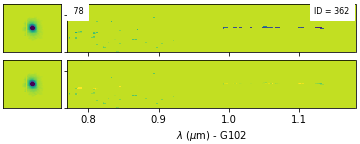

In [40]:
Image(filename='j113812m1134_00362.stack.png')
#Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

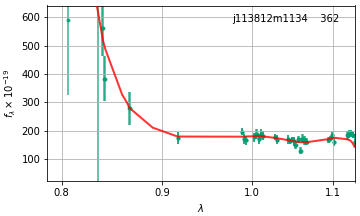

In [41]:
# 1D spectrum with polynomial model
Image(filename='j113812m1134_00362.1D.png')
#Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

### Redshift fit ###

The redshift fit is performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:


### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

The emission line maps are generated by subtracting the best-fit continuum model, assuming that the direct image is representative of the continuum morphology.  This should be a reasonable assumption for objects other than, perhaps, those with extreme line equivalent widths.


Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 399
Run 164
Run 26
Run 1
Run 1
Run 30
Run 26
Run 26
Run 124
Run 174
Run 67
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
R

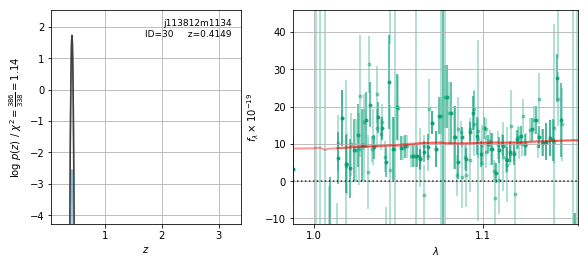

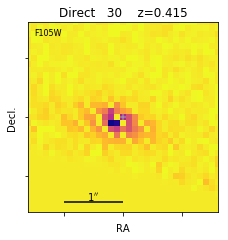

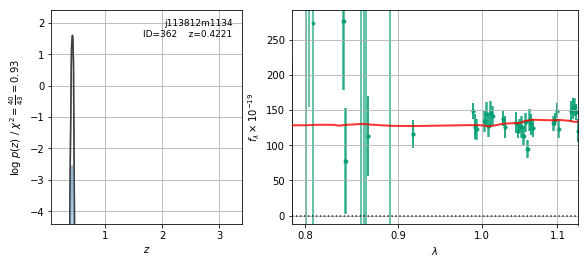

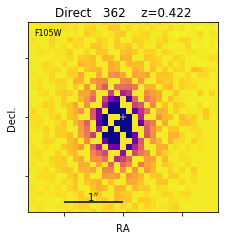

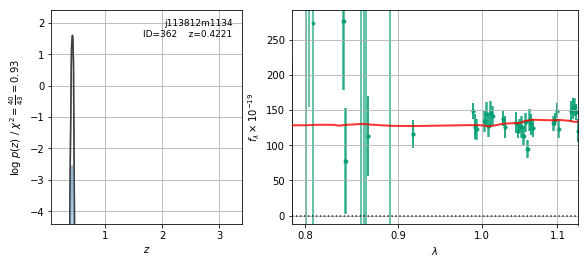

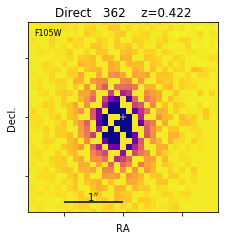

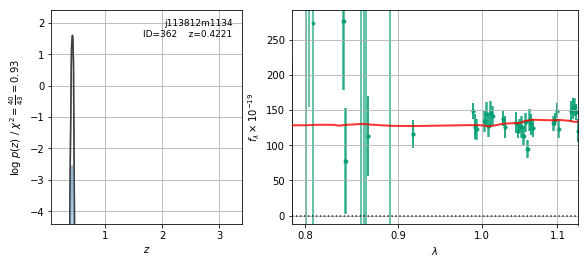

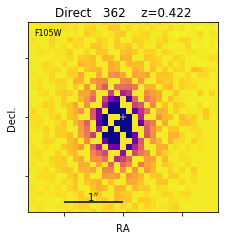

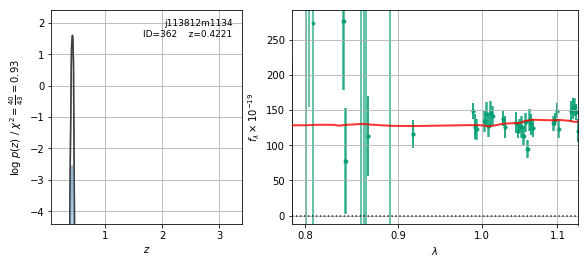

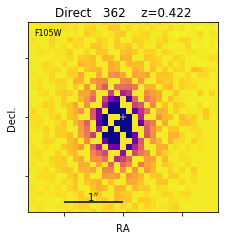

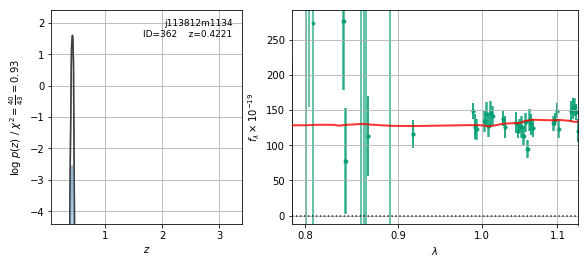

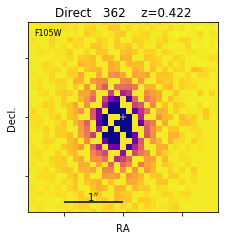

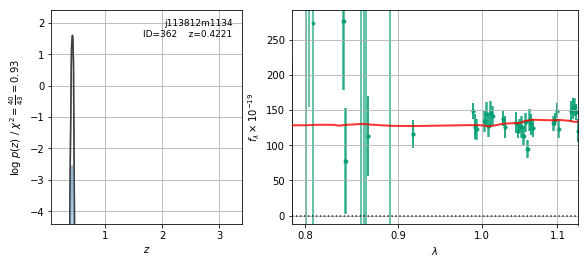

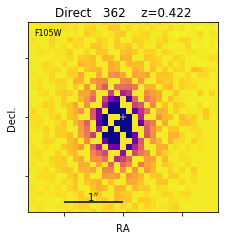

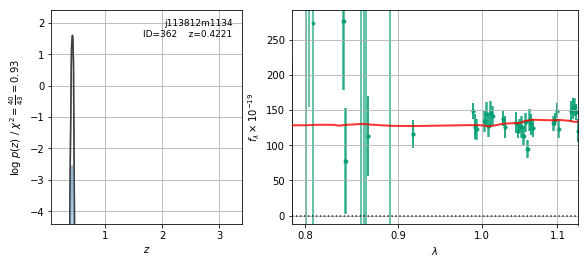

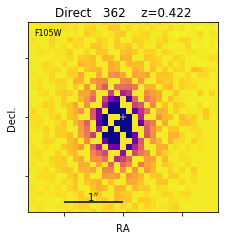

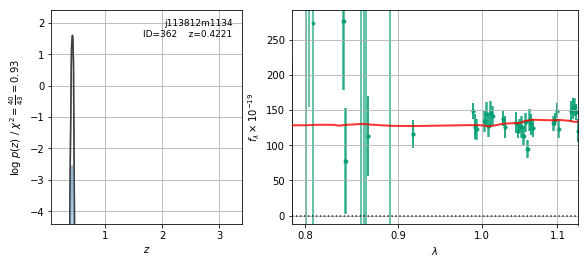

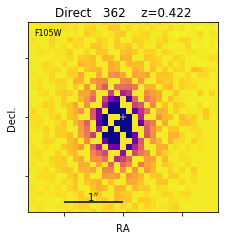

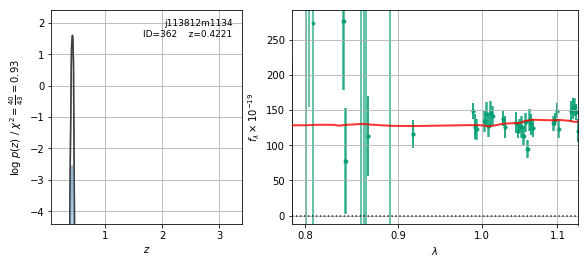

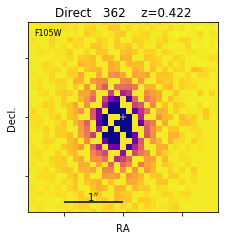

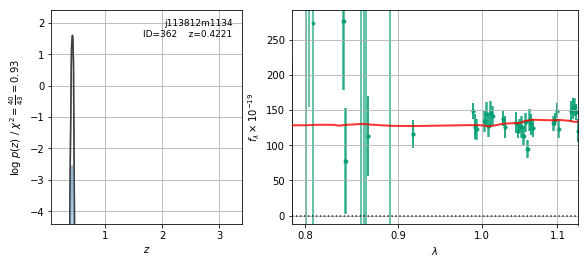

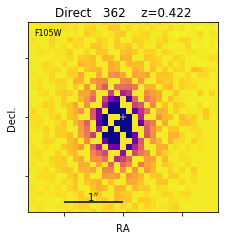

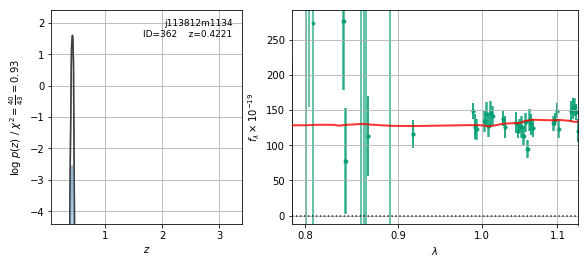

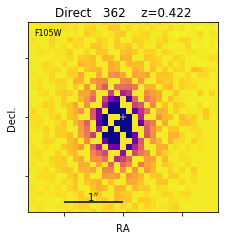

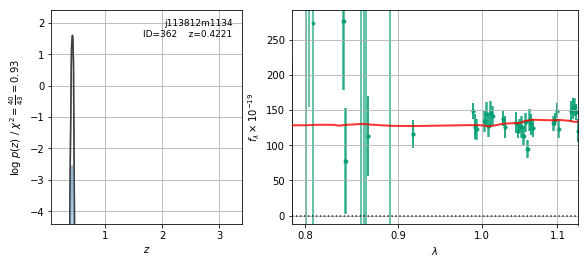

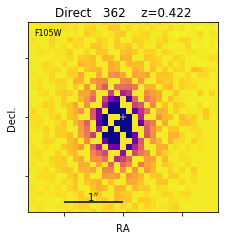

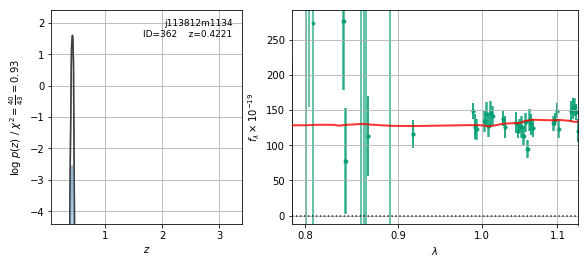

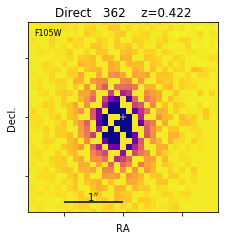

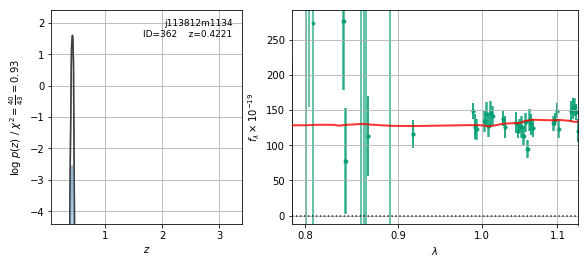

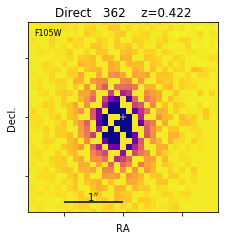

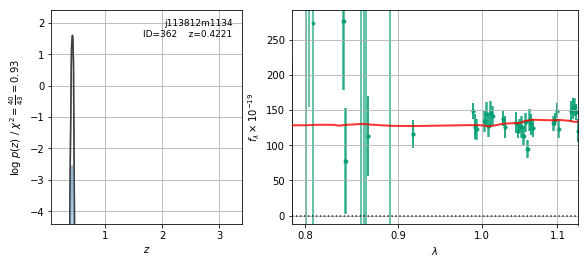

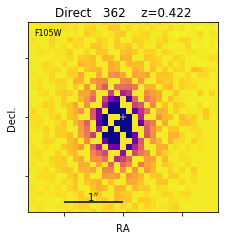

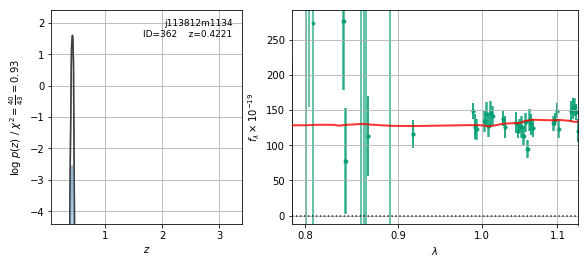

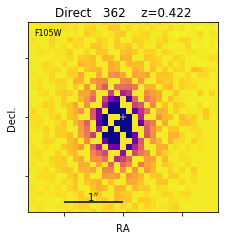

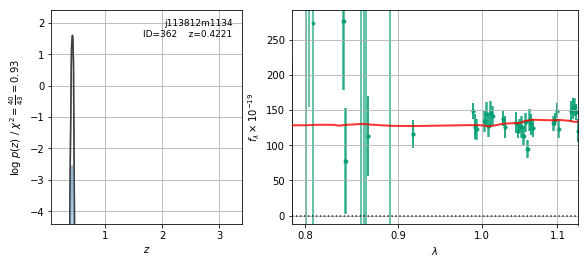

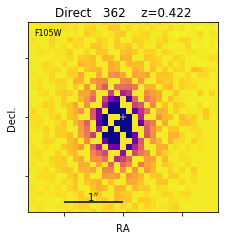

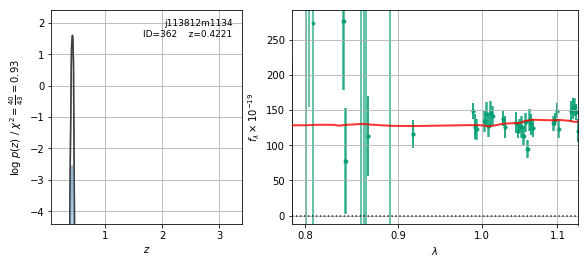

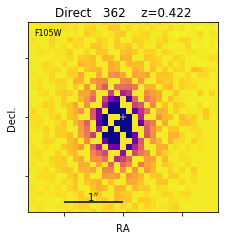

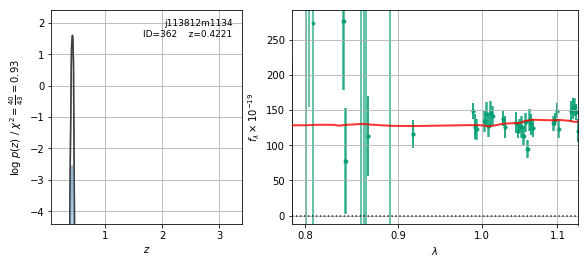

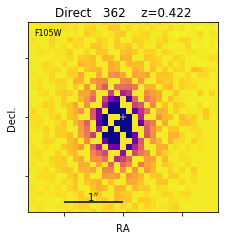

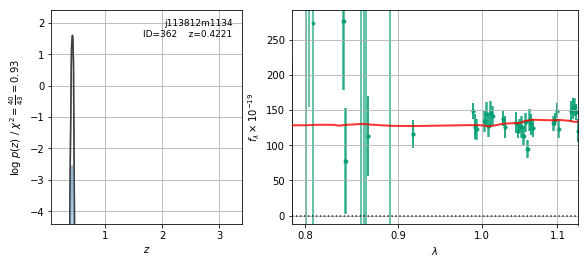

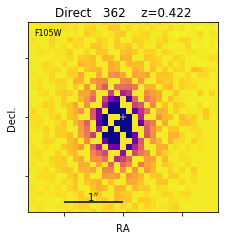

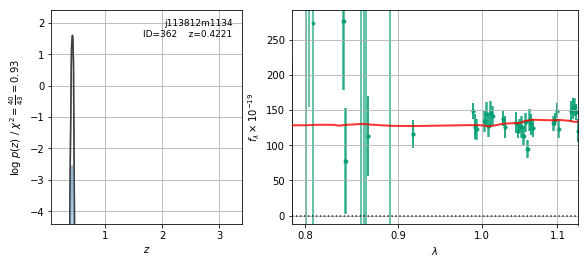

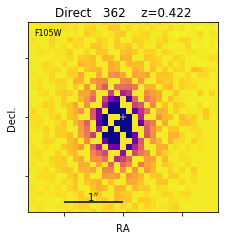

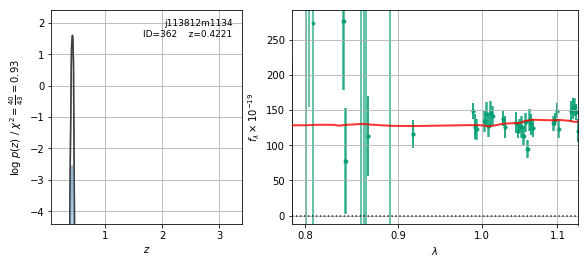

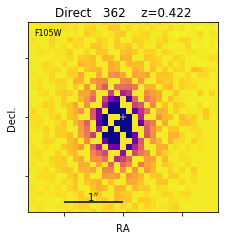

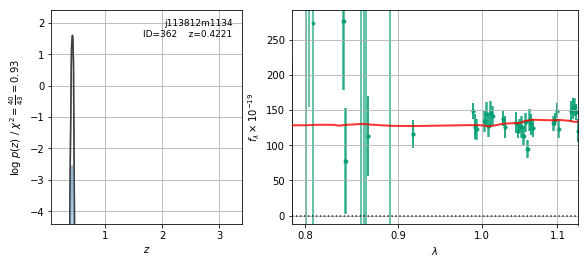

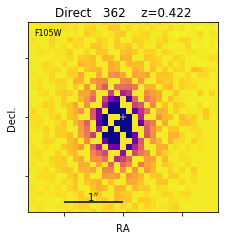

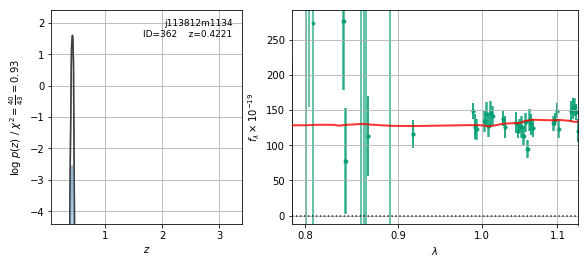

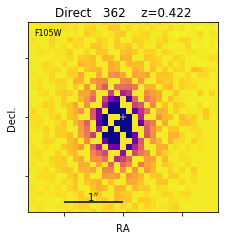

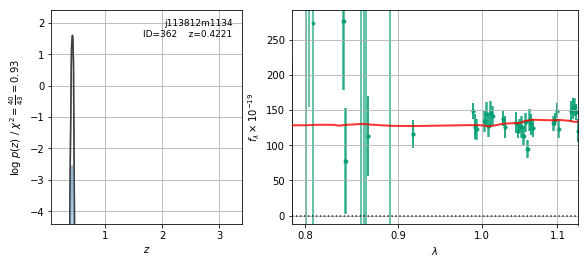

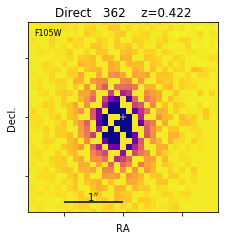

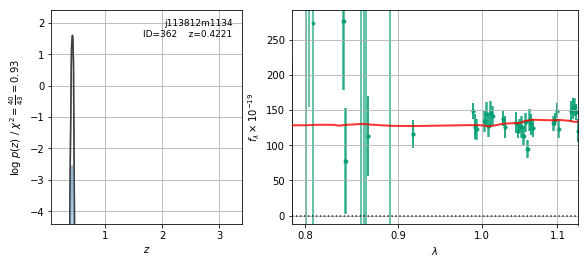

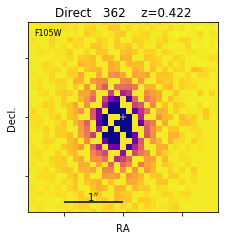

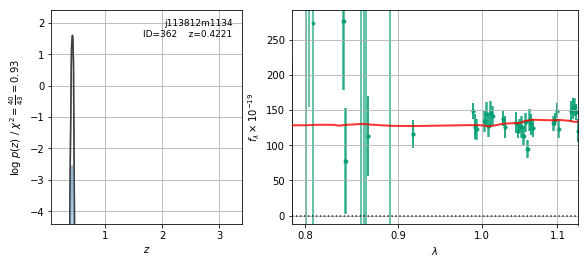

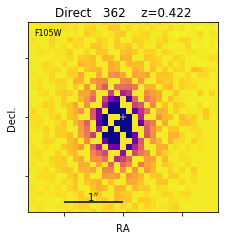

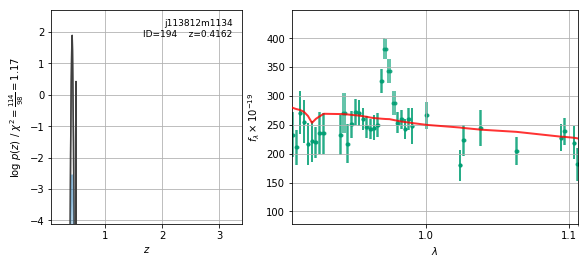

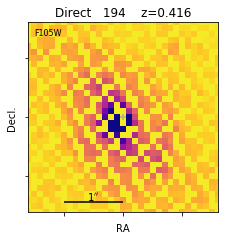

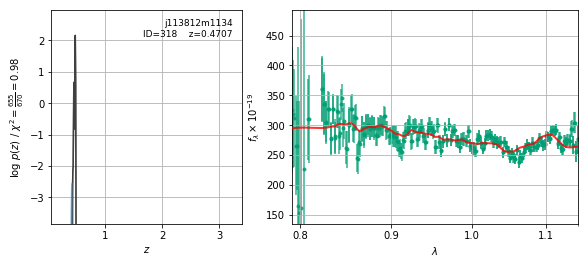

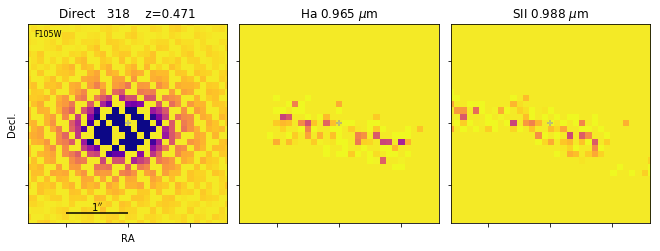

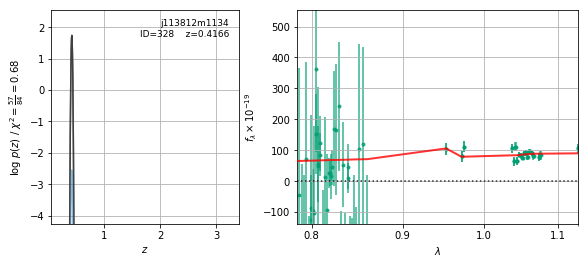

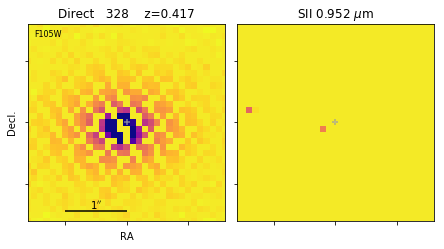

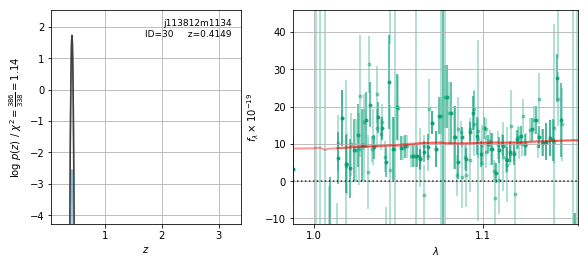

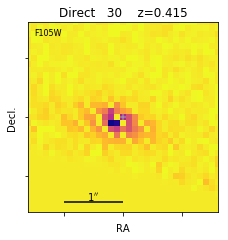

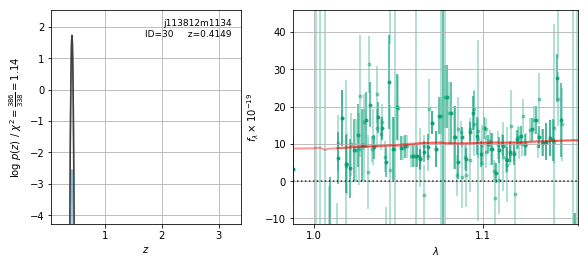

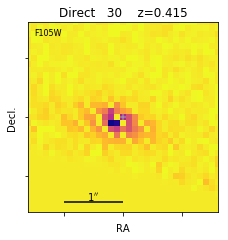

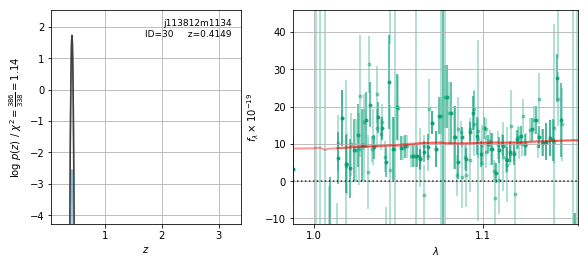

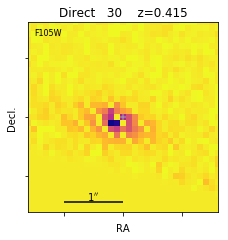

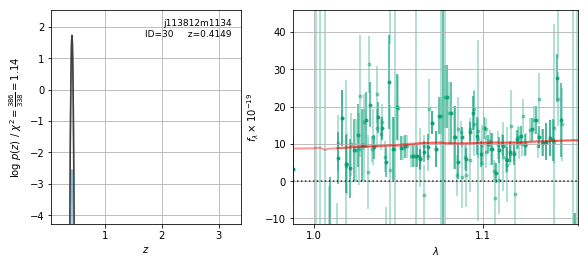

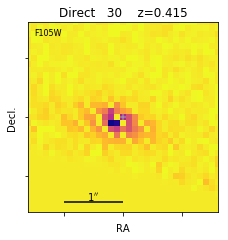

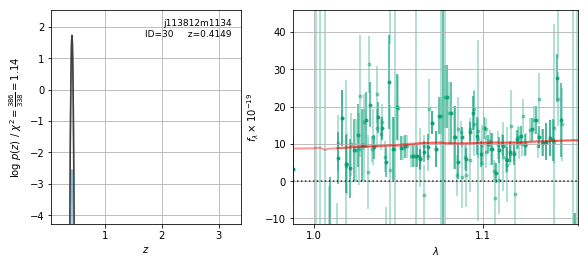

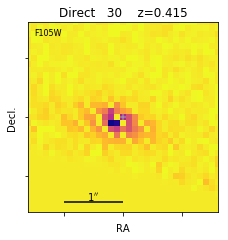

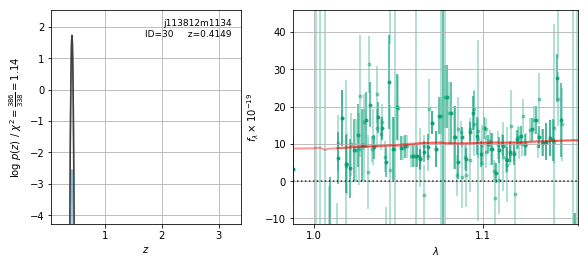

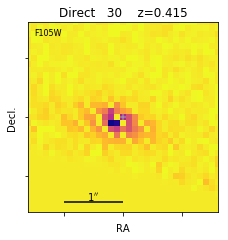

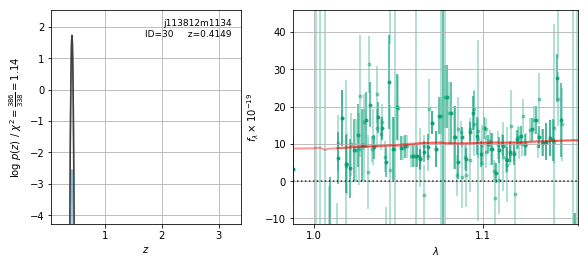

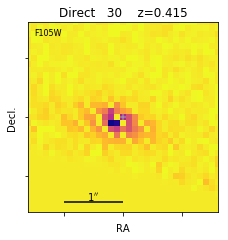

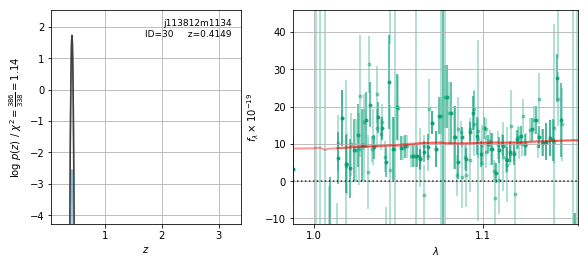

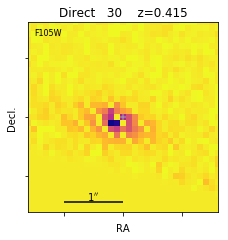

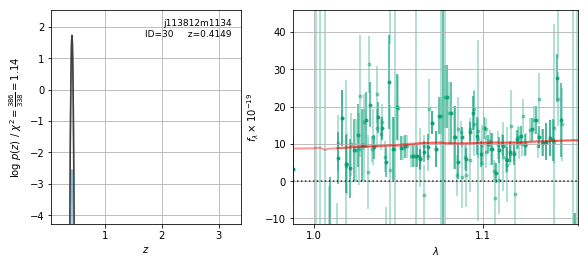

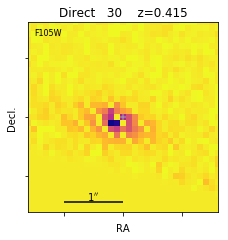

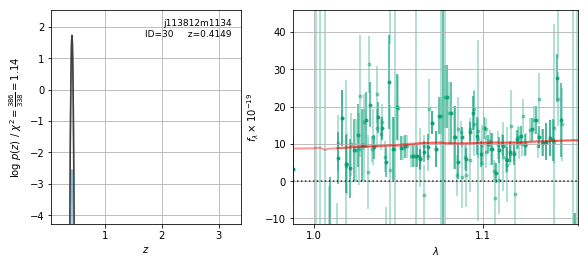

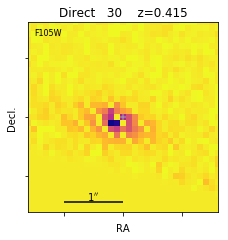

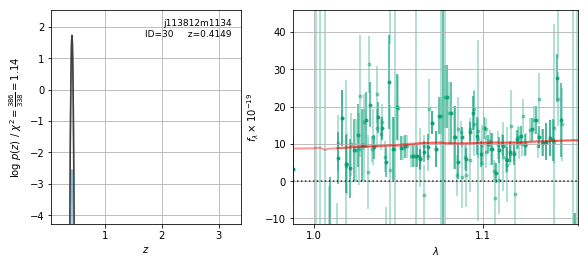

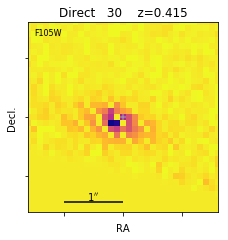

In [44]:
# Fit it.  The "run_all_parallel" function defaults to all of the parameters set in 'fit_args.npy'
for id_i in source_ids:
    fitting.run_all_parallel(id_i)

### Fit products ###

A number of files are produced that contain the results of the redshift fit.  The [`NewSpectrumFits.ipynb`](https://github.com/gbrammer/grizli/blob/master/examples/NewSpectrumFits.ipynb) notebook describes how to interact with these products in some greater detail.  

In [154]:
files = glob.glob('*{0:05d}*'.format(id))
for file in files:
    print(file)

j113812m1134_00399.log_par


In [155]:
for file in files:
    if not file.endswith('.fits'):
        continue
        
    im = pyfits.open(file)
    print('\n\n{1}\n{0}\n{1}\n\n'.format(file, '='*len(file)))
    im.info()

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

In [156]:
# Continuum source
id=source_ids[0:512]
#id=np.array(id)
auto_script.extract(field_root=root, ids=id, MW_EBV=tabs[0].meta['MW_EBV'], 
                    pline=pline, run_fit=False, grp=grp, diff=True)

0/512: 399 0
5/512: 399 0
7/512: 399 0
8/512: 399 0
9/512: 399 0
10/512: 399 0
21/512: 399 0
22/512: 399 0
80/512: 399 0
88/512: 399 0
89/512: 399 0
91/512: 399 0
96/512: 399 0
97/512: 399 0
98/512: 399 0
101/512: 399 0
102/512: 399 0
110/512: 399 0
111/512: 399 0
112/512: 399 0
118/512: 399 0
120/512: 399 0
122/512: 399 0
123/512: 399 0
125/512: 399 0
127/512: 399 0
128/512: 399 0
129/512: 399 0
130/512: 399 0
133/512: 399 0
134/512: 399 0
136/512: 399 0
141/512: 399 0
143/512: 399 0
144/512: 399 0
148/512: 399 0
149/512: 399 0
150/512: 399 0
168/512: 399 0
169/512: 399 0
171/512: 399 0
176/512: 399 0
177/512: 399 0
178/512: 399 0
179/512: 399 0
180/512: 399 0
181/512: 399 0
183/512: 399 0
184/512: 399 0
188/512: 399 0
189/512: 399 0
191/512: 399 0
196/512: 399 0
199/512: 399 0
200/512: 399 0
201/512: 399 0
204/512: 399 0
205/512: 399 0
208/512: 399 0
209/512: 399 0
210/512: 399 0
211/512: 399 0
212/512: 399 0
213/512: 399 0
214/512: 399 0
215/512: 399 0
216/512: 399 0
221/512: 399 0


True

In [142]:
# Stacked 2D spectrum
Image(filename='{0}_{1:05d}.stack.png'.format(root, id)) 

TypeError: unsupported format string passed to Column.__format__

In [143]:
# 1D spectrum with polynomial model
Image(filename='{0}_{1:05d}.1D.png'.format(root, id)) 

TypeError: unsupported format string passed to Column.__format__

Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 399
Run 164
Run 26
Run 1
Run 1
Run 30
Run 26
Run 26
Run 124
Run 174
Run 67
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 124
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
Run 322
R

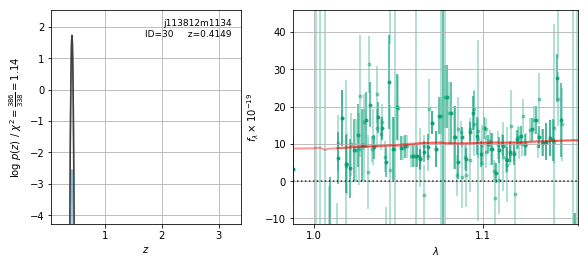

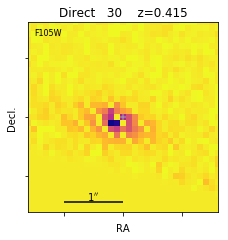

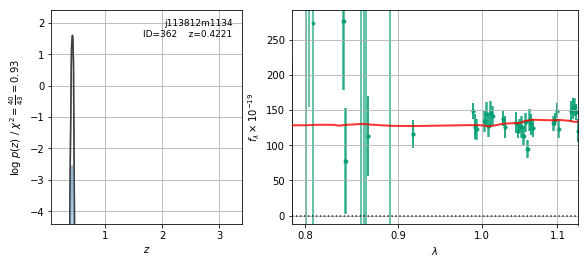

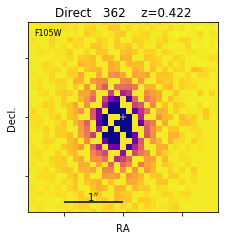

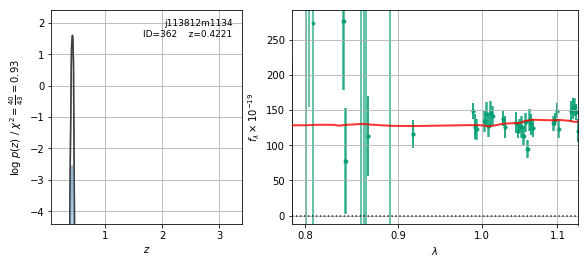

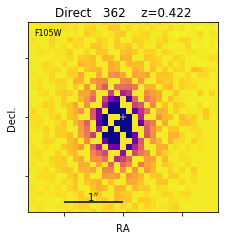

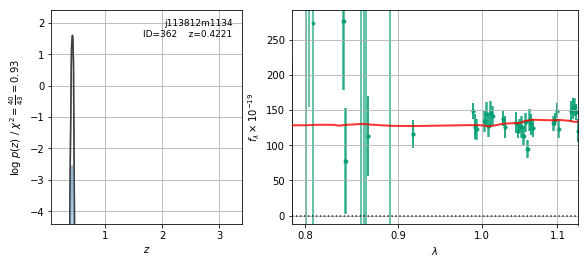

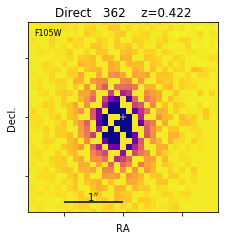

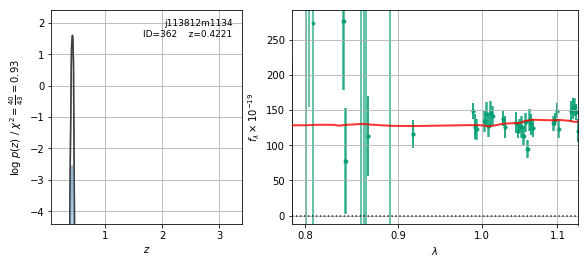

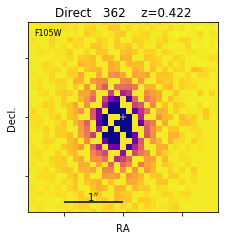

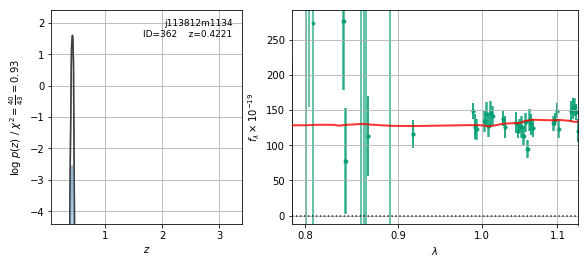

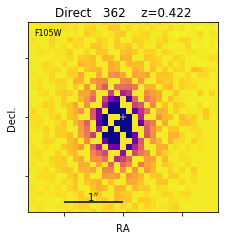

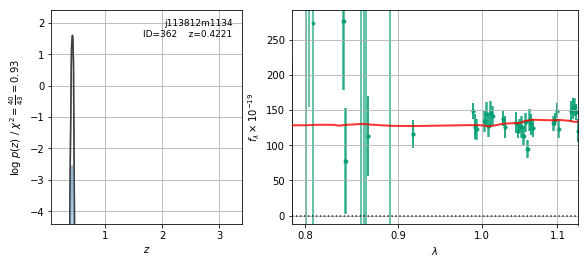

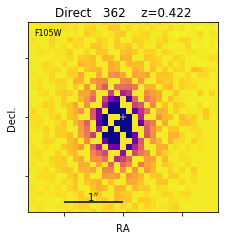

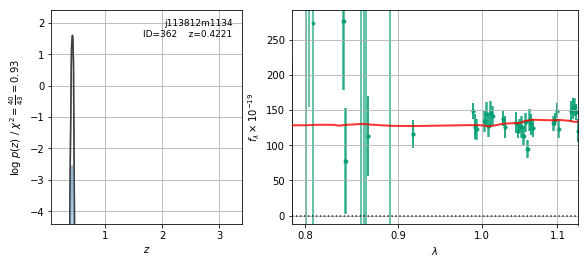

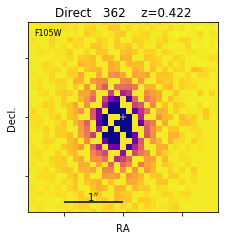

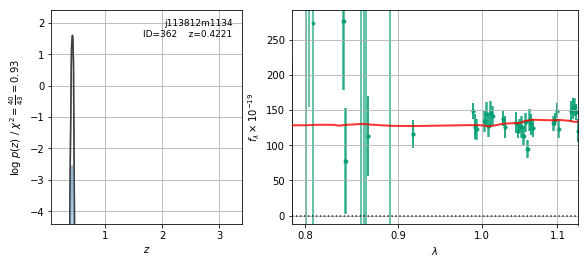

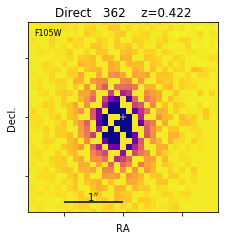

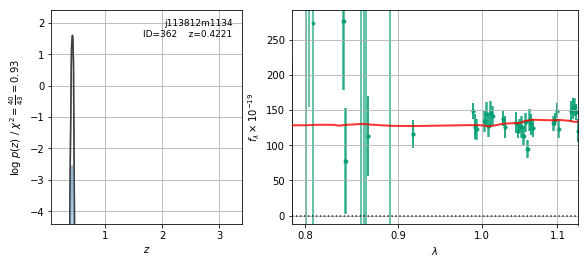

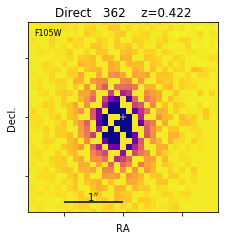

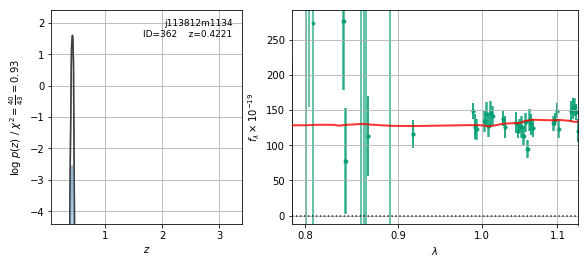

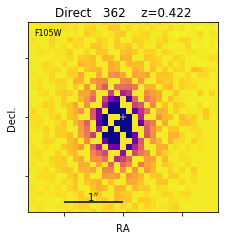

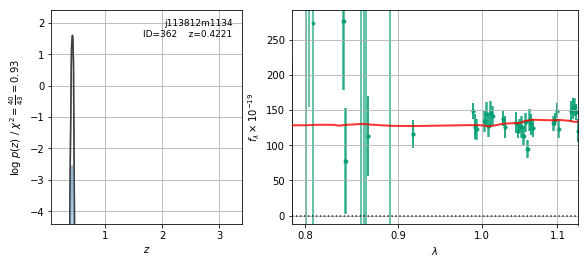

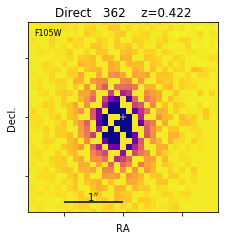

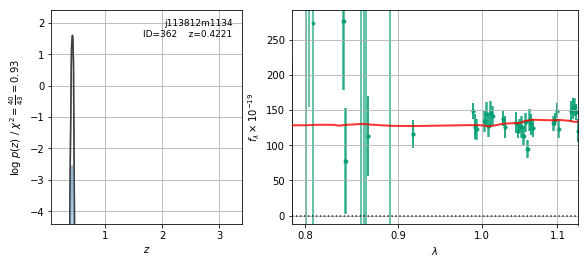

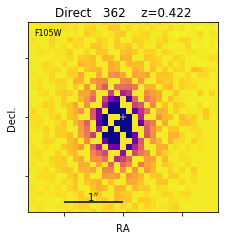

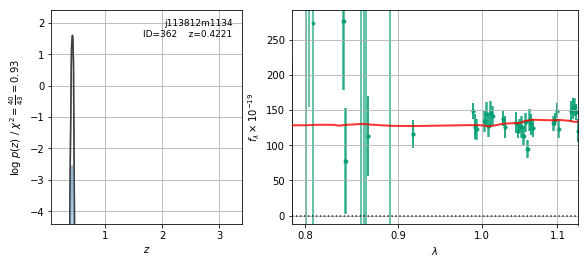

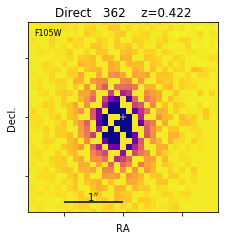

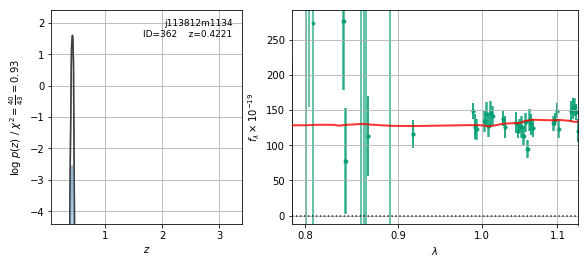

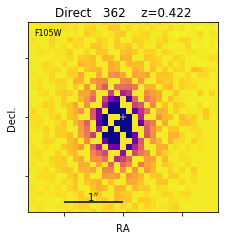

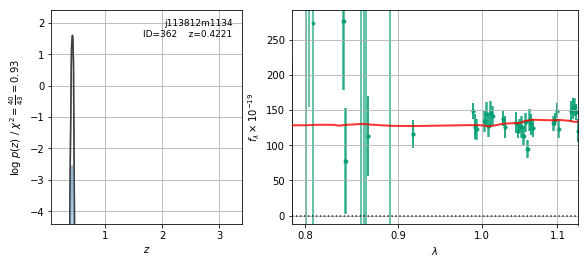

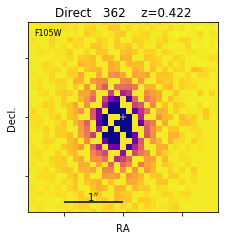

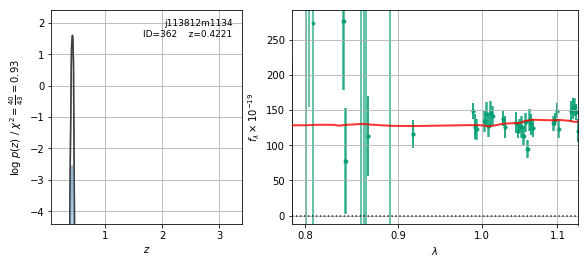

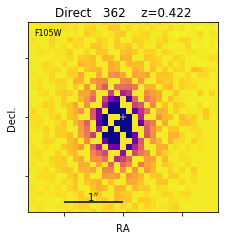

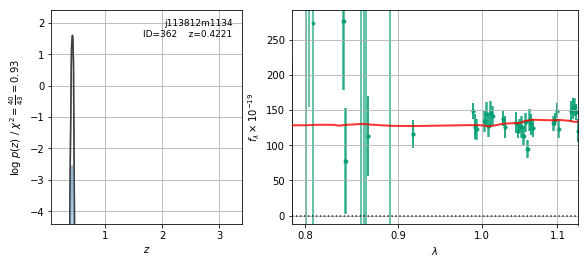

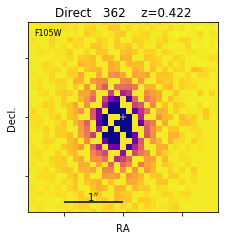

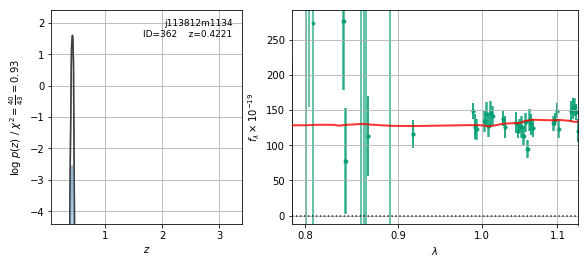

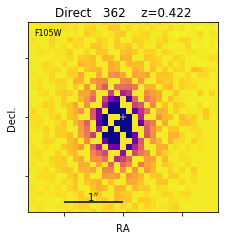

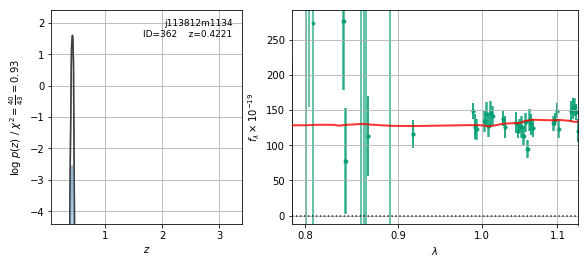

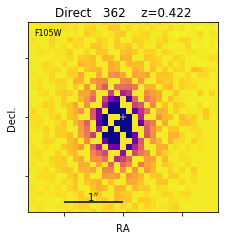

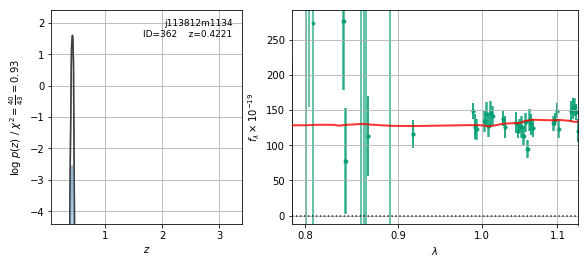

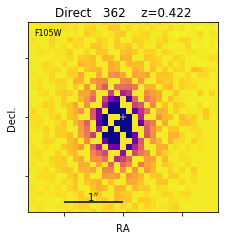

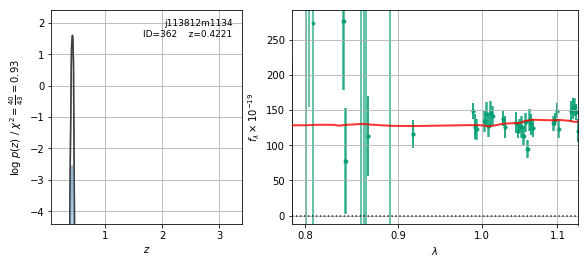

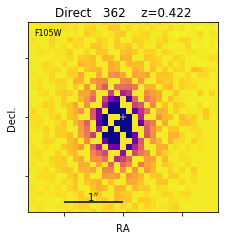

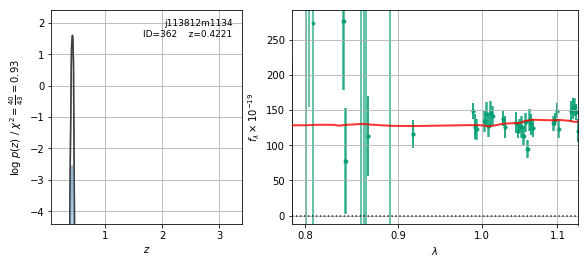

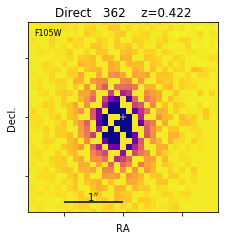

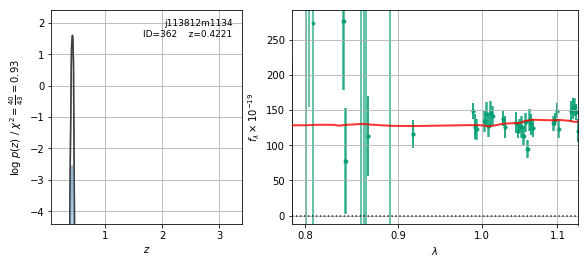

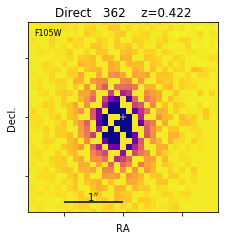

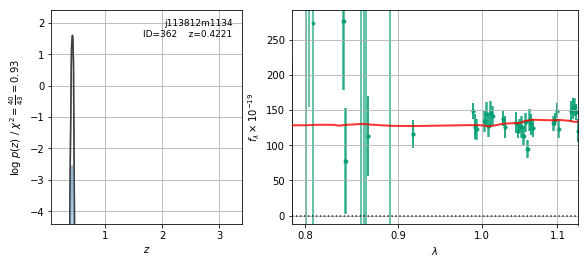

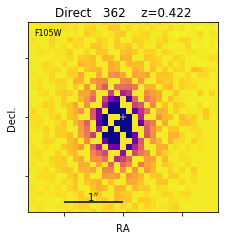

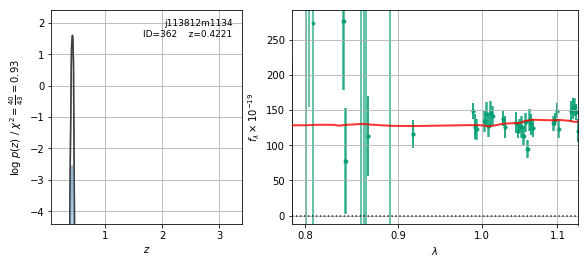

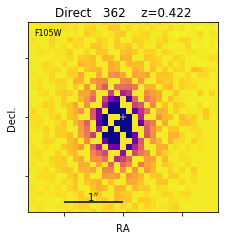

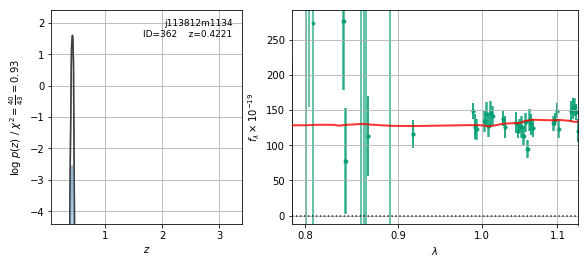

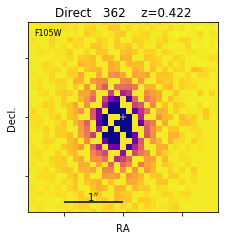

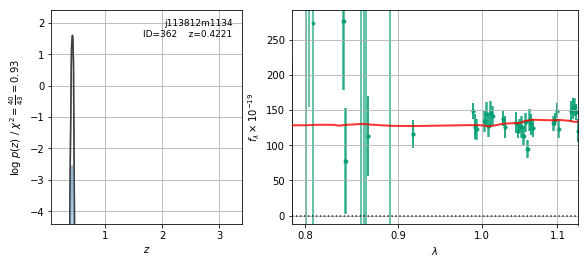

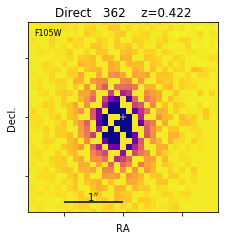

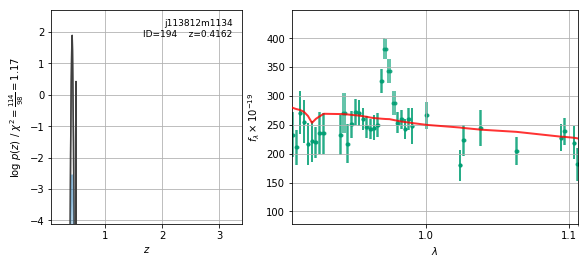

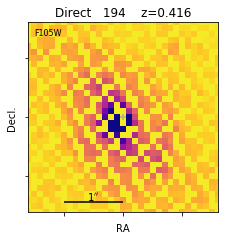

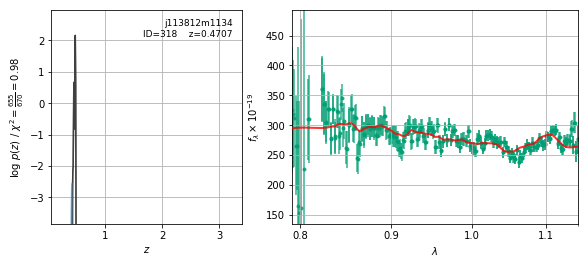

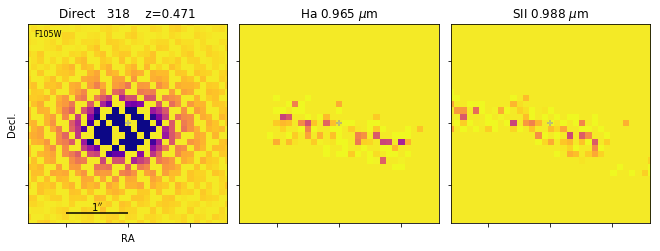

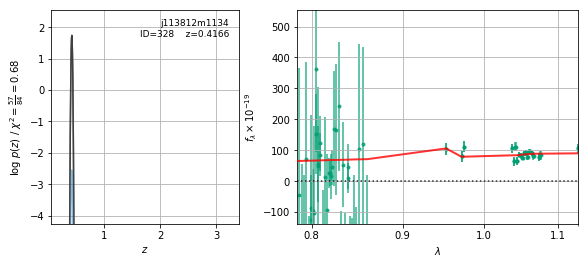

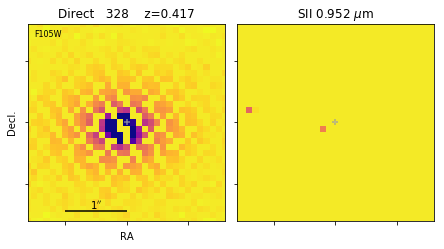

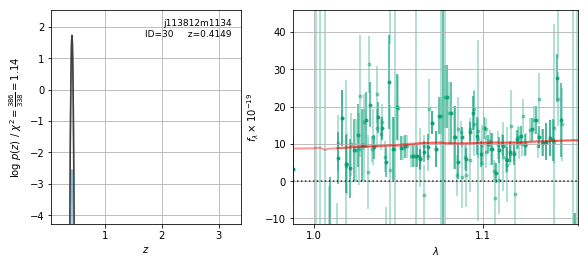

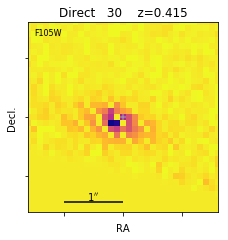

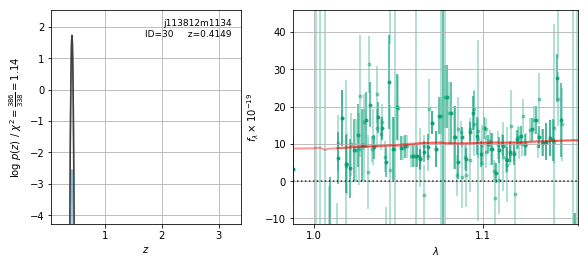

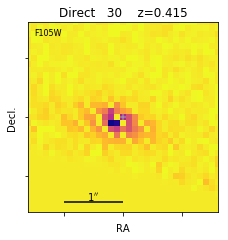

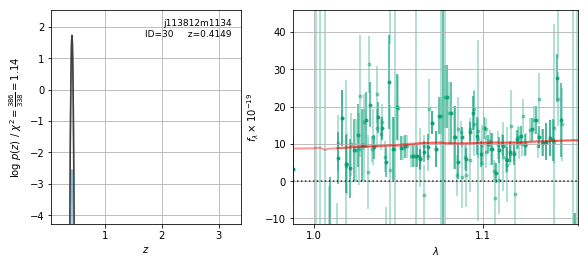

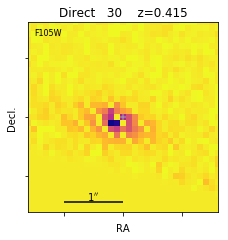

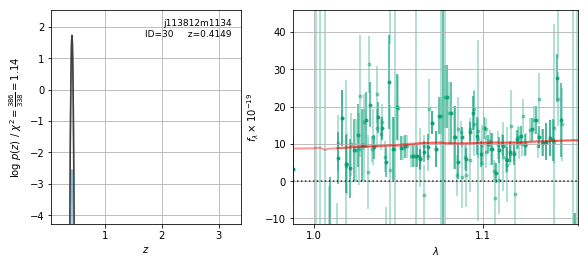

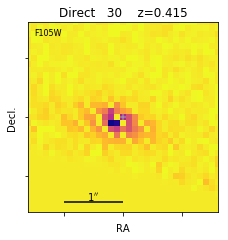

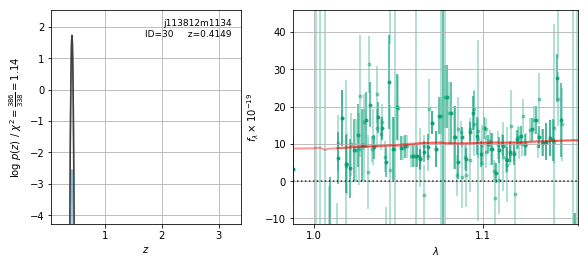

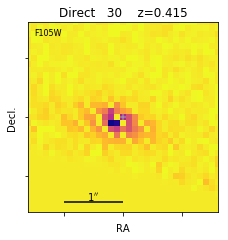

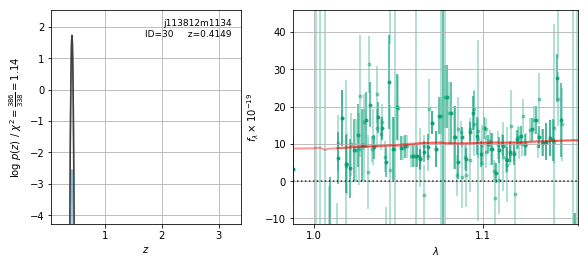

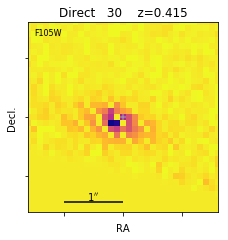

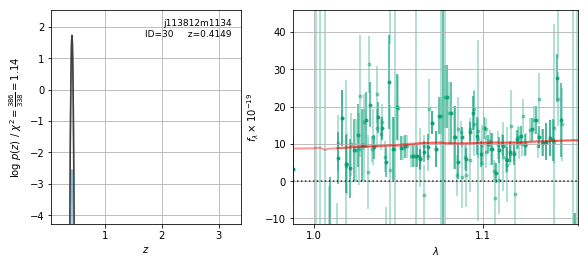

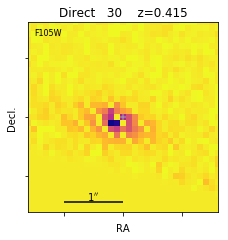

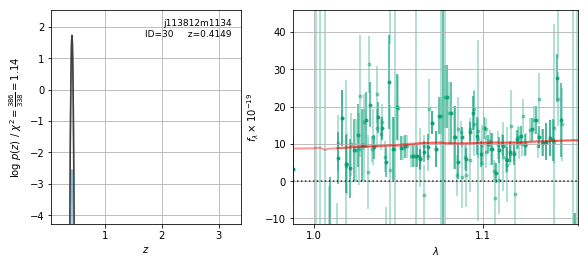

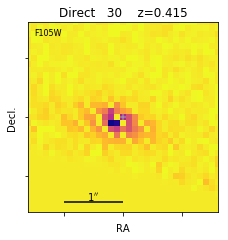

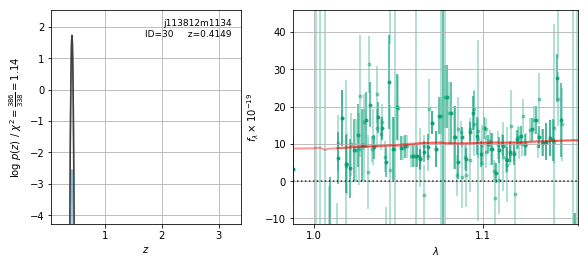

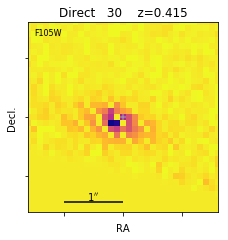

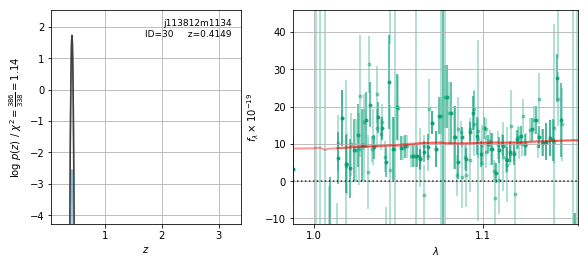

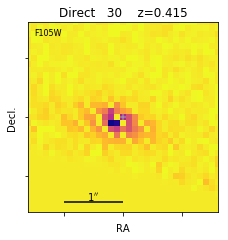

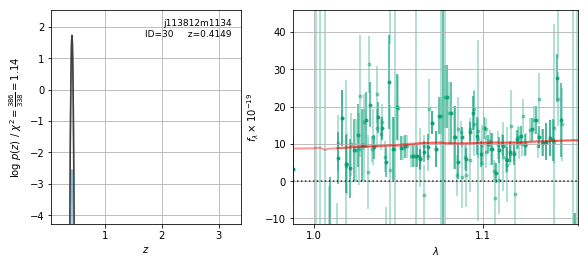

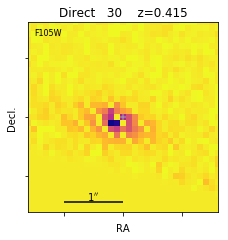

In [45]:
## Run the fit
for id_i in source_ids:
    fitting.run_all_parallel(id_i)

### Fit grism with photometry

Another option is fitting the grism spectra along with ancillary photometry, described here: [Fit-with-Photometry.ipynb](https://github.com/gbrammer/grizli/blob/master/examples/Fit-with-Photometry.ipynb).